In [1]:
pip install medmnist

Note: you may need to restart the kernel to use updated packages.


In [20]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import manifold

In [3]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


In [4]:
data_flag = 'bloodmnist'
download = True

BATCH_SIZE = 128


info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

Read the MedMNIST data, preprocess and encapsulate into dataloader form

In [5]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\anany\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\anany\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\anany\.medmnist\bloodmnist.npz


In [6]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BloodMNIST (bloodmnist)
    Number of datapoints: 11959
    Root location: C:\Users\anany\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC BY 

In [7]:
# visualization

train_dataset.montage(length=1)

C:\Users\anany\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\medmnist\utils.py:25: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


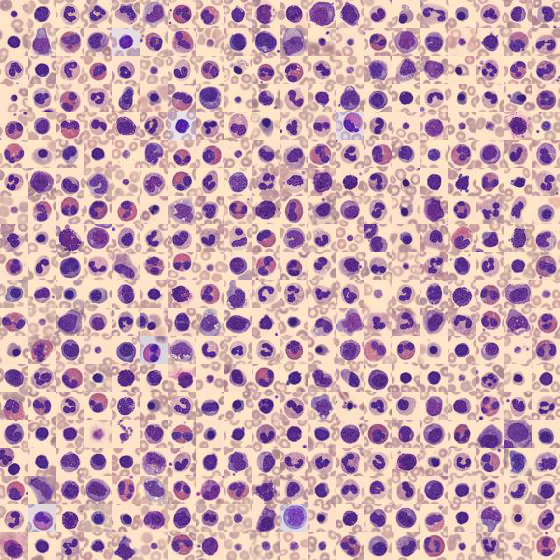

In [8]:
# visualization

train_dataset.montage(length=20)

In [9]:
train_dataset

Dataset BloodMNIST (bloodmnist)
    Number of datapoints: 11959
    Root location: C:\Users\anany\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC BY 

In [10]:
train_dataset.info

{'python_class': 'BloodMNIST',
 'description': 'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.',
 'url': 'https://zenodo.org/record/6496656/files/bloodmnist.npz?download=1',
 'MD5': '7053d0359d879ad8a5505303e11de1dc',
 'task': 'multi-class',
 'label': {'0': 'basophil',
  '1': 'eosinophil',
  '2': 'erythroblast',
  '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)',
  '4': 'lymphocyte',
  '5': 'monocyte',
  '6': 'neutrophil',
  '7': 'platelet'},
 'n_channels': 3,
 'n_samples': {'train': 11959, 'val': 1712, 'test': 3421},
 '

In [11]:
train_dataset.imgs.shape

(11959, 28, 28, 3)

In [12]:
train_dataset.labels.shape

(11959, 1)

In [13]:
list(train_dataset.info.keys())

['python_class',
 'description',
 'url',
 'MD5',
 'task',
 'label',
 'n_channels',
 'n_samples',
 'license']

In [82]:
x_train = np.array([x.flatten() for x in train_dataset.imgs])
y_train=train_dataset.labels

In [83]:
x_train.shape

(11959, 2352)

### Class Imbalance

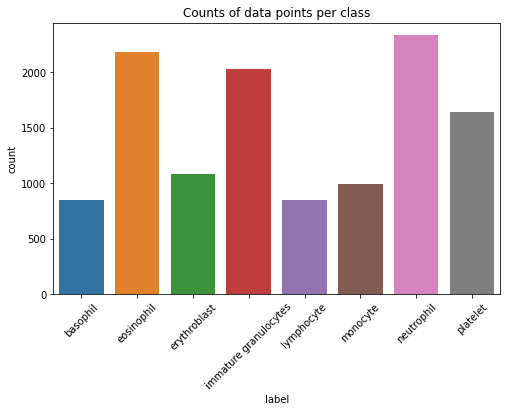

In [21]:
plt.figure(figsize=(8,5))
plt.title('Counts of data points per class')
y_train=pd.DataFrame(y_train)
label_map = train_dataset.info['label']
sns.countplot(x = y_train.iloc[:, 0])
old_xaxis = [int(x) for x in list(label_map.keys())]
new_axis = list(label_map.values())
new_axis[3] = 'immature granulocytes'
plt.xticks(old_xaxis, new_axis, rotation=45)
plt.xlabel('label')
plt.show()

### t-SNE

In [17]:
tsne = manifold.TSNE(n_components=2, perplexity=30.0, n_iter=1000, verbose=1).fit_transform(x_train)

c:\Users\Kirthana\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\Kirthana\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11959 samples in 0.048s...
[t-SNE] Computed neighbors for 11959 samples in 24.315s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11959
[t-SNE] Computed conditional probabilities for sample 2000 / 11959
[t-SNE] Computed conditional probabilities for sample 3000 / 11959
[t-SNE] Computed conditional probabilities for sample 4000 / 11959
[t-SNE] Computed conditional probabilities for sample 5000 / 11959
[t-SNE] Computed conditional probabilities for sample 6000 / 11959
[t-SNE] Computed conditional probabilities for sample 7000 / 11959
[t-SNE] Computed conditional probabilities for sample 8000 / 11959
[t-SNE] Computed conditional probabilities for sample 9000 / 11959
[t-SNE] Computed conditional probabilities for sample 10000 / 11959
[t-SNE] Computed conditional probabilities for sample 11000 / 11959
[t-SNE] Computed conditional probabilities for sample 11959 / 11959
[t-SNE] Mean sigma: 385.645257
[t-SNE] KL diverge

In [22]:
x_train=pd.DataFrame(x_train)
y_train=np.array(y_train)

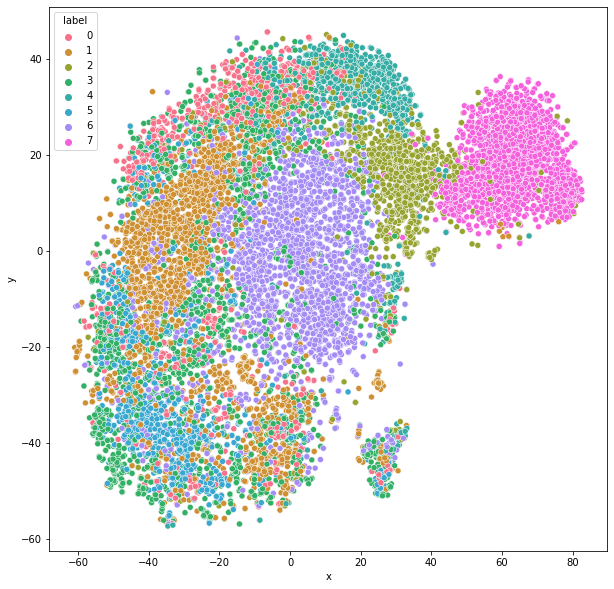

In [23]:
df_tsne= pd.DataFrame(columns = ["x", "y", "label"] )
df_tsne["x"] = tsne[:,0]
df_tsne["y"] = tsne[:,1]
df_tsne["label"] = y_train

plt.figure(figsize = (10,10))
sns.scatterplot(x = df_tsne["x"], y = df_tsne["y"], hue = df_tsne["label"],  palette = sns.color_palette("husl",8))
plt.show()

### PCA

In [24]:
x_train=pd.DataFrame(x_train)
y_train=pd.DataFrame(y_train)

In [25]:
from sklearn.decomposition import PCA

feature_selector = PCA(120, random_state=0)
x_train = feature_selector.fit_transform(x_train)

pca_plot_df = pd.DataFrame(data=x_train[:,0:2], columns=['PC 1', 'PC 2'])
pca_plot_df = pd.concat([pca_plot_df, y_train], axis=1)

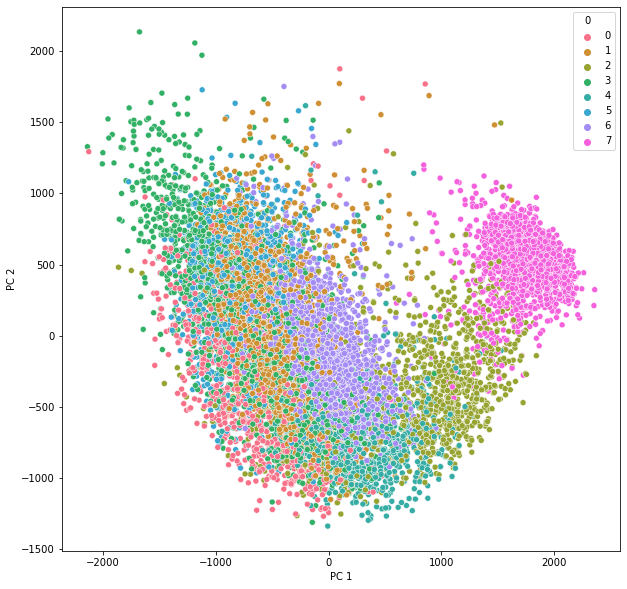

In [26]:
plt.figure(figsize = (10,10))
sns.scatterplot(x = pca_plot_df['PC 1'], y = pca_plot_df['PC 2'], hue = pca_plot_df.iloc[:,2],  palette = sns.color_palette("husl", 8))
plt.show()

### 3D PCA

In [46]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [109]:
import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
components = pca.fit_transform(x_train)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=y_train.iloc[:, 0],
    title='PCA: '+f'Total Explained Variance is {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [110]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.26463844 0.09115098 0.04929541]


### 3D t-SNE

In [56]:
import plotly.express as px

tsne_components = manifold.TSNE(n_components=3, perplexity=30.0, n_iter=1000, verbose=1).fit_transform(x_train)

c:\Users\Kirthana\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\Kirthana\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11959 samples in 0.009s...
[t-SNE] Computed neighbors for 11959 samples in 4.599s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11959
[t-SNE] Computed conditional probabilities for sample 2000 / 11959
[t-SNE] Computed conditional probabilities for sample 3000 / 11959
[t-SNE] Computed conditional probabilities for sample 4000 / 11959
[t-SNE] Computed conditional probabilities for sample 5000 / 11959
[t-SNE] Computed conditional probabilities for sample 6000 / 11959
[t-SNE] Computed conditional probabilities for sample 7000 / 11959
[t-SNE] Computed conditional probabilities for sample 8000 / 11959
[t-SNE] Computed conditional probabilities for sample 9000 / 11959
[t-SNE] Computed conditional probabilities for sample 10000 / 11959
[t-SNE] Computed conditional probabilities for sample 11000 / 11959
[t-SNE] Computed conditional probabilities for sample 11959 / 11959
[t-SNE] Mean sigma: 376.124457
[t-SNE] KL divergen

In [65]:
fig = px.scatter_3d(
    tsne_components, x=0, y=1, z=2, color=y_train.iloc[:, 0],
    title='tSNE',
    labels={'0': 'x', '1': 'y', '2': 'z'}
)
fig.show()

In [72]:
import matplotlib.pyplot as plt

In [84]:
x_train=pd.DataFrame(x_train)
x_train.shape

(11959, 2352)

In [85]:
y_train=pd.DataFrame(y_train)
y_train.shape

(11959, 1)

In [86]:
y_train

0
0      7
1      3
2      6
3      6
4      7
...   ..
11954  6
11955  2
11956  1
11957  6
11958  4

[11959 rows x 1 columns]

In [99]:
def get_class_arrays(class_index):
    x = x_train[y_train.iloc[:, 0] == class_index]
    y=y_train[y_train.iloc[:, 0] == class_index]
    return x,y

In [100]:
number_classes=1

(852, 2352)


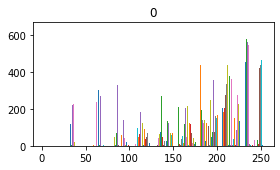

In [101]:
figure = plt.figure(figsize=(25,5))

def get_histogram():
    for i in range(number_classes):
        class_arrayX,class_arrayY = get_class_arrays(i)
        plt.subplot(2,5,i+1)
        _ = plt.hist(class_arrayX)
        plt.title(i)
get_histogram()

(852, 2352)
(852, 2352)
[174.28457650665902]
[174.28457650665902]


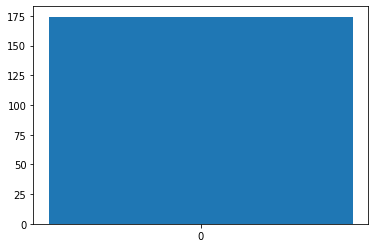

In [105]:
def get_mean_barchart():
    mean_values =[]
    for i in range(number_classes):
        class_arrayX,class_arrayY = get_class_arrays(i)
        mean_values.append(class_arrayX.mean().mean())
    plt.bar(np.arange(number_classes),mean_values, align='center')
    plt.xticks(np.arange(number_classes))

get_mean_barchart()

In [107]:
embeddings =embeddings =manifold.TSNE(n_components=2, perplexity=30.0, n_iter=1000, verbose=1).fit_transform(x_train)

C:\Users\anany\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\anany\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11959 samples in 0.040s...
[t-SNE] Computed neighbors for 11959 samples in 18.889s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11959
[t-SNE] Computed conditional probabilities for sample 2000 / 11959
[t-SNE] Computed conditional probabilities for sample 3000 / 11959
[t-SNE] Computed conditional probabilities for sample 4000 / 11959
[t-SNE] Computed conditional probabilities for sample 5000 / 11959
[t-SNE] Computed conditional probabilities for sample 6000 / 11959
[t-SNE] Computed conditional probabilities for sample 7000 / 11959
[t-SNE] Computed conditional probabilities for sample 8000 / 11959
[t-SNE] Computed conditional probabilities for sample 9000 / 11959
[t-SNE] Computed conditional probabilities for sample 10000 / 11959
[t-SNE] Computed conditional probabilities for sample 11000 / 11959
[t-SNE] Computed conditional probabilities for sample 11959 / 11959
[t-SNE] Mean sigma: 385.645257
[t-SNE] KL diverge

UNDERSTAND: https://medium.com/datadl-ai/mnist-exploration-to-execution-25136ca00570

In [108]:
def get_class_embeddings_arrays(class_index):
    x = embeddings[y_train.iloc[:, 0] == class_index]
    y=y_train[y_train.iloc[:, 0] == class_index]
    return x,y

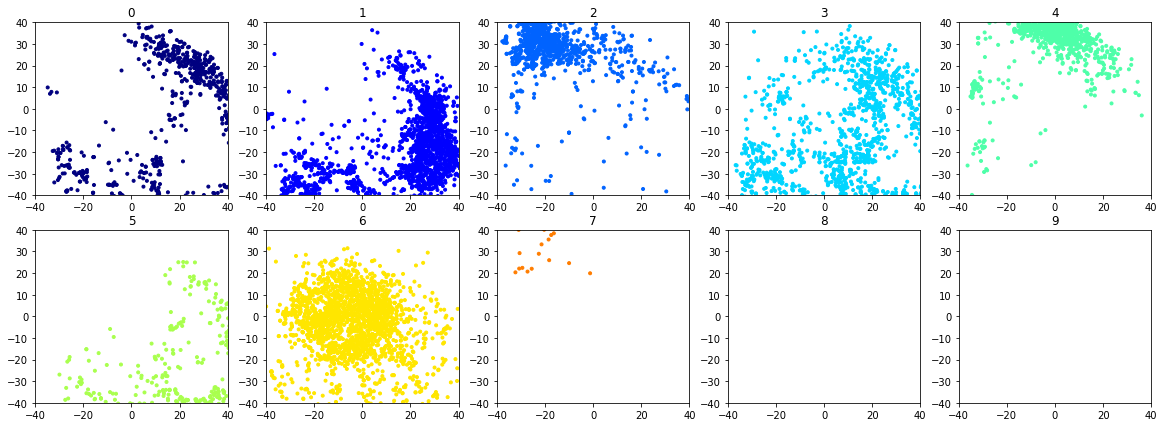

In [109]:
figure = plt.figure(figsize=(20,7))

for i in range(number_classes):
    plt.subplot(2,5,i+1)
    class_embeddings_arrayX,class_embeddings_arrayY = get_class_embeddings_arrays(i)
    plt.scatter(class_embeddings_arrayX[:, 0], class_embeddings_arrayX[:, 1], c=class_embeddings_arrayY, 
                cmap=plt.cm.get_cmap("jet", 10), marker='.')
    plt.clim(-0.5, 9.5)
    plt.axis([-40, 40, -40, 40])
    plt.title(i)

In [111]:
pip install bokeh

Note: you may need to restart the kernel to use updated packages.


     ---------------------------------------- 16.5/16.5 MB 8.4 MB/s eta 0:00:00
     -------------------------------------- 151.7/151.7 kB 8.8 MB/s eta 0:00:00
     ---------------------------------------- 55.9/55.9 kB ? eta 0:00:00
     -------------------------------------- 163.6/163.6 kB 9.6 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [121]:
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

In [122]:
df=pd.DataFrame(x_train)
df['label']=y_train.astype('str')

In [123]:
df = df.astype(str)

In [124]:
df.head()

0    1    2    3    4    5    6    7    8    9  ... 2343 2344 2345 2346  \
0  250  223  206  255  229  212  251  222  206  229  ...  254  226  204  255   
1  255  232  213  254  227  206  251  225  200  254  ...  182  145  139  188   
2  185  145  154  185  149  153  202  167  165  228  ...  220  180  180  213   
3  226  192  167  231  196  176  221  188  173  201  ...  255  230  203  255   
4  227  194  185  220  187  178  213  179  170  216  ...  255  229  202  255   

  2347 2348 2349 2350 2351 label  
0  227  203  255  228  201     7  
1  151  145  176  141  137     3  
2  173  173  214  174  175     6  
3  230  203  255  229  202     6  
4  228  204  255  228  204     7  

[5 rows x 2353 columns]

In [125]:
# define hover tool
from bokeh.models import HoverTool
hover = HoverTool(
    # we print the class label 
    # and the index in the dataframe
    # in the tooltip
    tooltips = [('label','@label'),
               ('index', '$index')]
)

# create figure
fig_scat = figure(tools=[hover, 'box_zoom', 'crosshair', 'undo'], 
                  width=600)

# bokeh data source from the dataframe
source = ColumnDataSource(df)


ValueError: failed to validate ColumnDataSource(id='p1143', ...).data: expected an element of ColumnData(String, Seq(Any)), got {0: array(['250', '255', '185', ..., '242', '205', '196'], dtype=object), 1: array(['223', '232', '145', ..., '239', '169', '159'], dtype=object), 2: array(['206', '213', '154', ..., '172', '173', '153'], dtype=object), 3: array(['255', '254', '185', ..., '238', '217', '192'], dtype=object), 4: array(['229', '227', '149', ..., '233', '181', '154'], dtype=object), 5: array(['212', '206', '153', ..., '175', '181', '153'], dtype=object), 6: array(['251', '251', '202', ..., '249', '236', '193'], dtype=object), 7: array(['222', '225', '167', ..., '237', '201', '154'], dtype=object), 8: array(['206', '200', '165', ..., '195', '195', '159'], dtype=object), 9: array(['229', '254', '228', ..., '255', '241', '199'], dtype=object), 10: array(['197', '229', '198', ..., '239', '207', '159'], dtype=object), 11: array(['182', '199', '187', ..., '214', '195', '170'], dtype=object), 12: array(['206', '255', '251', ..., '251', '219', '201'], dtype=object), 13: array(['170', '233', '224', ..., '228', '186', '163'], dtype=object), 14: array(['156', '197', '203', ..., '220', '167', '176'], dtype=object), 15: array(['196', '255', '255', ..., '253', '190', '200'], dtype=object), 16: array(['158', '233', '233', ..., '224', '158', '162'], dtype=object), 17: array(['145', '192', '205', ..., '226', '137', '173'], dtype=object), 18: array(['202', '254', '253', ..., '255', '185', '198'], dtype=object), 19: array(['162', '231', '232', ..., '228', '153', '162'], dtype=object), 20: array(['150', '187', '201', ..., '231', '132', '164'], dtype=object), 21: array(['209', '253', '252', ..., '255', '198', '197'], dtype=object), 22: array(['170', '231', '231', ..., '227', '165', '164'], dtype=object), 23: array(['155', '184', '200', ..., '224', '150', '155'], dtype=object), 24: array(['212', '255', '248', ..., '255', '193', '190'], dtype=object), 25: array(['173', '235', '227', ..., '228', '159', '159'], dtype=object), 26: array(['158', '188', '196', ..., '212', '150', '139'], dtype=object), 27: array(['201', '251', '250', ..., '255', '187', '188'], dtype=object), 28: array(['162', '228', '229', ..., '229', '151', '158'], dtype=object), 29: array(['145', '184', '198', ..., '200', '151', '130'], dtype=object), 30: array(['196', '251', '254', ..., '254', '200', '223'], dtype=object), 31: array(['159', '228', '231', ..., '231', '163', '194'], dtype=object), 32: array(['140', '187', '199', ..., '189', '170', '164'], dtype=object), 33: array(['200', '255', '255', ..., '250', '228', '255'], dtype=object), 34: array(['165', '234', '231', ..., '233', '191', '229'], dtype=object), 35: array(['145', '198', '195', ..., '181', '199', '202'], dtype=object), 36: array(['209', '255', '255', ..., '249', '239', '255'], dtype=object), 37: array(['179', '234', '230', ..., '236', '201', '227'], dtype=object), 38: array(['155', '203', '189', ..., '181', '212', '211'], dtype=object), 39: array(['233', '255', '255', ..., '248', '224', '253'], dtype=object), 40: array(['206', '229', '230', ..., '239', '186', '222'], dtype=object), 41: array(['179', '202', '183', ..., '182', '197', '219'], dtype=object), 42: array(['251', '255', '255', ..., '243', '205', '255'], dtype=object), 43: array(['225', '229', '233', ..., '236', '168', '223'], dtype=object), 44: array(['198', '204', '180', ..., '181', '176', '232'], dtype=object), 45: array(['249', '255', '255', ..., '239', '199', '248'], dtype=object), 46: array(['223', '234', '236', ..., '232', '162', '214'], dtype=object), 47: array(['196', '211', '180', ..., '178', '169', '230'], dtype=object), 48: array(['236', '255', '250', ..., '255', '214', '255'], dtype=object), 49: array(['217', '233', '226', ..., '230', '178', '229'], dtype=object), 50: array(['159', '207', '202', ..., '195', '180', '200'], dtype=object), 51: array(['229', '255', '254', ..., '255', '213', '252'], dtype=object), 52: array(['209', '234', '230', ..., '227', '178', '225'], dtype=object), 53: array(['158', '206', '204', ..., '192', '174', '195'], dtype=object), 54: array(['228', '251', '252', ..., '255', '217', '253'], dtype=object), 55: array(['206', '226', '231', ..., '233', '183', '227'], dtype=object), 56: array(['165', '196', '200', ..., '197', '171', '194'], dtype=object), 57: array(['227', '255', '250', ..., '255', '220', '253'], dtype=object), 58: array(['204', '228', '230', ..., '234', '188', '227'], dtype=object), 59: array(['173', '198', '195', ..., '197', '165', '192'], dtype=object), 60: array(['230', '244', '250', ..., '252', '212', '240'], dtype=object), 61: array(['205', '215', '230', ..., '226', '181', '214'], dtype=object), 62: array(['183', '185', '195', ..., '191', '150', '179'], dtype=object), 63: array(['247', '255', '253', ..., '255', '206', '218'], dtype=object), 64: array(['221', '224', '233', ..., '228', '176', '189'], dtype=object), 65: array(['204', '196', '198', ..., '199', '142', '157'], dtype=object), 66: array(['255', '255', '255', ..., '255', '222', '201'], dtype=object), 67: array(['233', '235', '234', ..., '232', '191', '171'], dtype=object), 68: array(['213', '215', '203', ..., '209', '162', '145'], dtype=object), 69: array(['251', '217', '253', ..., '252', '246', '197'], dtype=object), 70: array(['227', '179', '233', ..., '224', '213', '166'], dtype=object), 71: array(['201', '168', '206', ..., '212', '194', '146'], dtype=object), 72: array(['255', '189', '247', ..., '255', '255', '205'], dtype=object), 73: array(['234', '149', '226', ..., '228', '234', '172'], dtype=object), 74: array(['197', '149', '205', ..., '224', '225', '163'], dtype=object), 75: array(['255', '175', '249', ..., '250', '255', '216'], dtype=object), 76: array(['238', '134', '227', ..., '220', '219', '181'], dtype=object), 77: array(['195', '142', '213', ..., '220', '223', '179'], dtype=object), 78: array(['251', '161', '249', ..., '247', '244', '227'], dtype=object), 79: array(['230', '119', '230', ..., '215', '206', '191'], dtype=object), 80: array(['185', '131', '216', ..., '218', '217', '193'], dtype=object), 81: array(['255', '156', '248', ..., '248', '243', '232'], dtype=object), 82: array(['234', '115', '229', ..., '216', '205', '196'], dtype=object), 83: array(['191', '131', '214', ..., '217', '216', '198'], dtype=object), 84: array(['255', '253', '185', ..., '249', '193', '197'], dtype=object), 85: array(['229', '227', '146', ..., '240', '156', '161'], dtype=object), 86: array(['210', '202', '151', ..., '183', '163', '147'], dtype=object), 87: array(['255', '255', '194', ..., '247', '203', '192'], dtype=object), 88: array(['229', '230', '158', ..., '237', '167', '155'], dtype=object), 89: array(['210', '205', '158', ..., '186', '169', '146'], dtype=object), 90: array(['244', '255', '218', ..., '251', '223', '192'], dtype=object), 91: array(['215', '232', '185', ..., '237', '188', '153'], dtype=object), 92: array(['199', '205', '178', ..., '198', '184', '154'], dtype=object), 93: array(['218', '255', '244', ..., '251', '239', '197'], dtype=object), 94: array(['186', '232', '215', ..., '231', '205', '157'], dtype=object), 95: array(['171', '202', '199', ..., '206', '195', '166'], dtype=object), 96: array(['198', '255', '255', ..., '245', '232', '199'], dtype=object), 97: array(['162', '233', '232', ..., '222', '199', '161'], dtype=object), 98: array(['148', '199', '209', ..., '208', '180', '176'], dtype=object), 99: array(['198', '255', '255', ..., '254', '210', '198'], dtype=object), 100: array(['160', '233', '235', ..., '225', '178', '159'], dtype=object), 101: array(['149', '197', '204', ..., '219', '157', '177'], dtype=object), 102: array(['215', '255', '252', ..., '255', '197', '197'], dtype=object), 103: array(['175', '232', '232', ..., '229', '165', '159'], dtype=object), 104: array(['165', '196', '199', ..., '224', '144', '170'], dtype=object), 105: array(['230', '255', '252', ..., '252', '199', '197'], dtype=object), 106: array(['190', '231', '232', ..., '222', '166', '163'], dtype=object), 107: array(['180', '195', '199', ..., '211', '149', '164'], dtype=object), 108: array(['225', '249', '248', ..., '255', '196', '192'], dtype=object), 109: array(['185', '225', '227', ..., '225', '162', '159'], dtype=object), 110: array(['173', '189', '196', ..., '205', '152', '150'], dtype=object), 111: array(['211', '255', '251', ..., '255', '204', '197'], dtype=object), 112: array(['171', '241', '230', ..., '229', '169', '166'], dtype=object), 113: array(['159', '210', '201', ..., '199', '165', '146'], dtype=object), 114: array(['202', '255', '255', ..., '255', '223', '227'], dtype=object), 115: array(['165', '244', '234', ..., '233', '187', '197'], dtype=object), 116: array(['149', '217', '203', ..., '195', '187', '171'], dtype=object), 117: array(['198', '254', '255', ..., '255', '236', '250'], dtype=object), 118: array(['162', '228', '235', ..., '234', '200', '223'], dtype=object), 119: array(['146', '205', '204', ..., '189', '204', '196'], dtype=object), 120: array(['203', '242', '255', ..., '252', '224', '247'], dtype=object), 121: array(['172', '215', '235', ..., '234', '188', '219'], dtype=object), 122: array(['152', '196', '198', ..., '188', '192', '197'], dtype=object), 123: array(['227', '247', '255', ..., '251', '198', '249'], dtype=object), 124: array(['199', '219', '234', ..., '237', '162', '220'], dtype=object), 125: array(['177', '205', '191', ..., '190', '164', '206'], dtype=object), 126: array(['248', '254', '255', ..., '253', '190', '255'], dtype=object), 127: array(['222', '226', '231', ..., '240', '154', '228'], dtype=object), 128: array(['199', '215', '183', ..., '196', '154', '220'], dtype=object), 129: array(['250', '253', '255', ..., '255', '199', '254'], dtype=object), 130: array(['224', '224', '229', ..., '242', '163', '223'], dtype=object), 131: array(['201', '216', '179', ..., '198', '163', '221'], dtype=object), 132: array(['254', '250', '255', ..., '255', '202', '255'], dtype=object), 133: array(['234', '224', '238', ..., '235', '165', '228'], dtype=object), 134: array(['184', '209', '214', ..., '202', '172', '201'], dtype=object), 135: array(['248', '255', '254', ..., '255', '210', '253'], dtype=object), 136: array(['227', '229', '230', ..., '228', '174', '226'], dtype=object), 137: array(['182', '212', '204', ..., '195', '174', '197'], dtype=object), 138: array(['246', '255', '248', ..., '255', '218', '255'], dtype=object), 139: array(['223', '231', '227', ..., '229', '184', '229'], dtype=object), 140: array(['189', '212', '196', ..., '195', '175', '199'], dtype=object), 141: array(['245', '255', '253', ..., '255', '215', '255'], dtype=object), 142: array(['221', '236', '233', ..., '227', '183', '231'], dtype=object), 143: array(['197', '214', '200', ..., '193', '162', '196'], dtype=object), 144: array(['243', '245', '255', ..., '250', '204', '246'], dtype=object), 145: array(['217', '214', '237', ..., '224', '173', '220'], dtype=object), 146: array(['202', '193', '200', ..., '191', '145', '185'], dtype=object), 147: array(['249', '240', '254', ..., '255', '204', '229'], dtype=object), 148: array(['222', '207', '234', ..., '230', '173', '200'], dtype=object), 149: array(['211', '188', '199', ..., '201', '142', '168'], dtype=object), 150: array(['252', '246', '251', ..., '255', '226', '214'], dtype=object), 151: array(['226', '210', '231', ..., '236', '195', '184'], dtype=object), 152: array(['213', '196', '198', ..., '213', '167', '158'], dtype=object), 153: array(['244', '199', '250', ..., '254', '252', '209'], dtype=object), 154: array(['219', '160', '229', ..., '227', '219', '178'], dtype=object), 155: array(['197', '153', '202', ..., '210', '200', '158'], dtype=object), 156: array(['249', '175', '255', ..., '233', '238', '207'], dtype=object), 157: array(['226', '135', '234', ..., '204', '204', '175'], dtype=object), 158: array(['195', '136', '213', ..., '196', '195', '164'], dtype=object), 159: array(['254', '165', '251', ..., '225', '226', '215'], dtype=object), 160: array(['232', '124', '230', ..., '196', '190', '180'], dtype=object), 161: array(['193', '132', '213', ..., '192', '192', '176'], dtype=object), 162: array(['254', '158', '248', ..., '221', '216', '223'], dtype=object), 163: array(['233', '116', '226', ..., '190', '179', '187'], dtype=object), 164: array(['190', '130', '212', ..., '188', '186', '187'], dtype=object), 165: array(['255', '158', '246', ..., '221', '214', '226'], dtype=object), 166: array(['242', '117', '225', ..., '190', '177', '190'], dtype=object), 167: array(['201', '133', '208', ..., '188', '185', '192'], dtype=object), 168: array(['255', '249', '205', ..., '249', '193', '199'], dtype=object), 169: array(['231', '224', '167', ..., '231', '155', '165'], dtype=object), 170: array(['208', '193', '164', ..., '191', '166', '138'], dtype=object), 171: array(['255', '255', '218', ..., '251', '194', '194'], dtype=object), 172: array(['227', '232', '184', ..., '231', '157', '159'], dtype=object), 173: array(['205', '201', '175', ..., '194', '164', '140'], dtype=object), 174: array(['238', '255', '239', ..., '255', '208', '192'], dtype=object), 175: array(['210', '234', '207', ..., '236', '172', '155'], dtype=object), 176: array(['189', '203', '192', ..., '203', '172', '147'], dtype=object), 177: array(['211', '254', '255', ..., '254', '230', '193'], dtype=object), 178: array(['180', '229', '227', ..., '230', '196', '156'], dtype=object), 179: array(['162', '198', '205', ..., '202', '187', '163'], dtype=object), 180: array(['194', '254', '255', ..., '250', '243', '195'], dtype=object), 181: array(['158', '229', '234', ..., '224', '210', '156'], dtype=object), 182: array(['144', '199', '204', ..., '201', '193', '174'], dtype=object), 183: array(['202', '255', '254', ..., '255', '238', '194'], dtype=object), 184: array(['164', '233', '231', ..., '233', '206', '154'], dtype=object), 185: array(['153', '206', '197', ..., '212', '185', '178'], dtype=object), 186: array(['228', '255', '251', ..., '255', '228', '195'], dtype=object), 187: array(['190', '234', '231', ..., '237', '196', '155'], dtype=object), 188: array(['181', '209', '196', ..., '215', '175', '179'], dtype=object), 189: array(['249', '255', '254', ..., '255', '223', '196'], dtype=object), 190: array(['208', '229', '234', ..., '224', '190', '160'], dtype=object), 191: array(['202', '208', '201', ..., '203', '171', '174'], dtype=object), 192: array(['244', '255', '255', ..., '255', '224', '187'], dtype=object), 193: array(['203', '235', '234', ..., '232', '191', '152'], dtype=object), 194: array(['197', '218', '205', ..., '206', '176', '156'], dtype=object), 195: array(['225', '253', '253', ..., '255', '236', '208'], dtype=object), 196: array(['186', '225', '232', ..., '227', '202', '175'], dtype=object), 197: array(['179', '214', '205', ..., '199', '193', '166'], dtype=object), 198: array(['209', '229', '252', ..., '250', '253', '241'], dtype=object), 199: array(['170', '200', '228', ..., '223', '218', '213'], dtype=object), 200: array(['163', '194', '204', ..., '194', '212', '191'], dtype=object), 201: array(['197', '201', '251', ..., '252', '255', '255'], dtype=object), 202: array(['160', '171', '225', ..., '225', '220', '231'], dtype=object), 203: array(['151', '171', '200', ..., '196', '216', '202'], dtype=object), 204: array(['195', '190', '252', ..., '255', '230', '254'], dtype=object), 205: array(['163', '159', '225', ..., '230', '195', '227'], dtype=object), 206: array(['150', '165', '196', ..., '203', '189', '197'], dtype=object), 207: array(['218', '196', '255', ..., '255', '199', '255'], dtype=object), 208: array(['189', '164', '227', ..., '231', '165', '228'], dtype=object), 209: array(['173', '175', '195', ..., '206', '156', '198'], dtype=object), 210: array(['246', '197', '255', ..., '250', '194', '255'], dtype=object), 211: array(['217', '165', '230', ..., '226', '160', '231'], dtype=object), 212: array(['201', '178', '194', ..., '202', '150', '202'], dtype=object), 213: array(['252', '190', '255', ..., '244', '207', '250'], dtype=object), 214: array(['225', '158', '232', ..., '219', '173', '223'], dtype=object), 215: array(['206', '173', '193', ..., '197', '161', '196'], dtype=object), 216: array(['255', '207', '254', ..., '255', '192', '251'], dtype=object), 217: array(['234', '178', '232', ..., '226', '154', '223'], dtype=object), 218: array(['195', '182', '211', ..., '199', '167', '201'], dtype=object), 219: array(['253', '214', '251', ..., '255', '201', '251'], dtype=object), 220: array(['230', '185', '229', ..., '221', '164', '223'], dtype=object), 221: array(['198', '187', '206', ..., '194', '171', '199'], dtype=object), 222: array(['253', '229', '254', ..., '255', '206', '253'], dtype=object), 223: array(['229', '199', '233', ..., '226', '171', '226'], dtype=object), 224: array(['205', '197', '204', ..., '197', '167', '197'], dtype=object), 225: array(['255', '245', '255', ..., '255', '203', '253'], dtype=object), 226: array(['229', '214', '239', ..., '229', '170', '226'], dtype=object), 227: array(['216', '209', '206', ..., '197', '155', '196'], dtype=object), 228: array(['255', '230', '254', ..., '255', '204', '243'], dtype=object), 229: array(['228', '197', '234', ..., '229', '172', '217'], dtype=object), 230: array(['224', '190', '199', ..., '196', '149', '184'], dtype=object), 231: array(['255', '222', '246', ..., '255', '217', '225'], dtype=object), 232: array(['227', '187', '226', ..., '233', '185', '199'], dtype=object), 233: array(['226', '181', '189', ..., '203', '160', '166'], dtype=object), 234: array(['255', '229', '249', ..., '255', '236', '208'], dtype=object), 235: array(['227', '191', '229', ..., '231', '204', '178'], dtype=object), 236: array(['224', '188', '194', ..., '204', '181', '150'], dtype=object), 237: array(['254', '203', '255', ..., '242', '248', '198'], dtype=object), 238: array(['227', '164', '239', ..., '215', '215', '167'], dtype=object), 239: array(['216', '165', '210', ..., '194', '198', '147'], dtype=object), 240: array(['255', '175', '249', ..., '215', '211', '209'], dtype=object), 241: array(['230', '134', '227', ..., '187', '177', '177'], dtype=object), 242: array(['208', '140', '203', ..., '173', '168', '164'], dtype=object), 243: array(['255', '169', '245', ..., '208', '204', '211'], dtype=object), 244: array(['233', '127', '222', ..., '180', '169', '176'], dtype=object), 245: array(['202', '139', '204', ..., '169', '167', '170'], dtype=object), 246: array(['251', '167', '241', ..., '204', '197', '214'], dtype=object), 247: array(['229', '126', '218', ..., '174', '161', '179'], dtype=object), 248: array(['192', '142', '202', ..., '166', '163', '177'], dtype=object), 249: array(['255', '174', '240', ..., '204', '196', '216'], dtype=object), 250: array(['242', '133', '217', ..., '174', '160', '180'], dtype=object), 251: array(['203', '151', '199', ..., '164', '162', '180'], dtype=object), 252: array(['253', '252', '240', ..., '254', '203', '203'], dtype=object), 253: array(['226', '229', '207', ..., '223', '165', '170'], dtype=object), 254: array(['197', '188', '192', ..., '203', '180', '139'], dtype=object), 255: array(['251', '255', '247', ..., '251', '194', '195'], dtype=object), 256: array(['224', '233', '214', ..., '223', '156', '163'], dtype=object), 257: array(['197', '192', '197', ..., '199', '167', '140'], dtype=object), 258: array(['239', '254', '254', ..., '255', '192', '192'], dtype=object), 259: array(['208', '230', '224', ..., '233', '156', '158'], dtype=object), 260: array(['187', '194', '200', ..., '206', '158', '148'], dtype=object), 261: array(['213', '249', '255', ..., '255', '209', '192'], dtype=object), 262: array(['180', '224', '228', ..., '236', '174', '156'], dtype=object), 263: array(['161', '193', '198', ..., '206', '168', '160'], dtype=object), 264: array(['195', '254', '252', ..., '255', '233', '191'], dtype=object), 265: array(['162', '228', '228', ..., '229', '200', '152'], dtype=object), 266: array(['147', '203', '192', ..., '194', '185', '171'], dtype=object), 267: array(['205', '255', '250', ..., '255', '251', '189'], dtype=object), 268: array(['168', '235', '228', ..., '229', '218', '149'], dtype=object), 269: array(['160', '218', '189', ..., '192', '199', '176'], dtype=object), 270: array(['231', '255', '254', ..., '255', '255', '189'], dtype=object), 271: array(['192', '227', '232', ..., '232', '224', '150'], dtype=object), 272: array(['187', '216', '195', ..., '195', '203', '177'], dtype=object), 273: array(['252', '240', '255', ..., '252', '255', '193'], dtype=object), 274: array(['212', '210', '237', ..., '226', '222', '155'], dtype=object), 275: array(['212', '208', '204', ..., '193', '203', '178'], dtype=object), 276: array(['255', '237', '251', ..., '255', '255', '194'], dtype=object), 277: array(['216', '206', '230', ..., '228', '226', '158'], dtype=object), 278: array(['216', '212', '203', ..., '199', '209', '168'], dtype=object), 279: array(['236', '204', '254', ..., '255', '255', '223'], dtype=object), 280: array(['196', '172', '229', ..., '226', '224', '190'], dtype=object), 281: array(['196', '187', '209', ..., '205', '212', '185'], dtype=object), 282: array(['214', '178', '255', ..., '255', '255', '250'], dtype=object), 283: array(['176', '145', '229', ..., '228', '226', '221'], dtype=object), 284: array(['175', '166', '214', ..., '213', '214', '203'], dtype=object), 285: array(['195', '174', '254', ..., '255', '255', '255'], dtype=object), 286: array(['160', '139', '226', ..., '230', '223', '229'], dtype=object), 287: array(['156', '169', '212', ..., '221', '211', '200'], dtype=object), 288: array(['191', '170', '253', ..., '255', '235', '252'], dtype=object), 289: array(['156', '135', '224', ..., '228', '202', '226'], dtype=object), 290: array(['150', '168', '210', ..., '224', '187', '189'], dtype=object), 291: array(['215', '159', '255', ..., '255', '204', '254'], dtype=object), 292: array(['182', '123', '224', ..., '225', '171', '229'], dtype=object), 293: array(['173', '161', '206', ..., '225', '152', '188'], dtype=object), 294: array(['245', '160', '255', ..., '255', '187', '252'], dtype=object), 295: array(['215', '123', '227', ..., '225', '155', '229'], dtype=object), 296: array(['204', '166', '206', ..., '227', '132', '185'], dtype=object), 297: array(['255', '171', '255', ..., '255', '186', '243'], dtype=object), 298: array(['225', '134', '230', ..., '227', '154', '220'], dtype=object), 299: array(['214', '177', '207', ..., '230', '129', '176'], dtype=object), 300: array(['251', '162', '249', ..., '255', '196', '252'], dtype=object), 301: array(['225', '132', '226', ..., '228', '157', '224'], dtype=object), 302: array(['200', '160', '210', ..., '212', '175', '210'], dtype=object), 303: array(['249', '163', '249', ..., '255', '195', '252'], dtype=object), 304: array(['222', '130', '226', ..., '228', '157', '225'], dtype=object), 305: array(['201', '157', '208', ..., '209', '170', '206'], dtype=object), 306: array(['249', '180', '250', ..., '255', '191', '253'], dtype=object), 307: array(['221', '147', '228', ..., '233', '155', '225'], dtype=object), 308: array(['210', '168', '204', ..., '212', '159', '203'], dtype=object), 309: array(['254', '198', '250', ..., '255', '195', '255'], dtype=object), 310: array(['224', '165', '229', ..., '232', '160', '228'], dtype=object), 311: array(['224', '182', '200', ..., '208', '154', '201'], dtype=object), 312: array(['254', '193', '248', ..., '253', '216', '254'], dtype=object), 313: array(['223', '160', '228', ..., '226', '183', '227'], dtype=object), 314: array(['231', '171', '193', ..., '199', '168', '197'], dtype=object), 315: array(['241', '195', '250', ..., '255', '238', '246'], dtype=object), 316: array(['209', '158', '227', ..., '228', '206', '219'], dtype=object), 317: array(['220', '166', '193', ..., '199', '185', '189'], dtype=object), 318: array(['233', '208', '251', ..., '249', '238', '232'], dtype=object), 319: array(['202', '171', '228', ..., '223', '206', '202'], dtype=object), 320: array(['210', '178', '194', ..., '196', '185', '174'], dtype=object), 321: array(['240', '210', '254', ..., '231', '223', '217'], dtype=object), 322: array(['210', '170', '231', ..., '205', '190', '186'], dtype=object), 323: array(['212', '179', '200', ..., '180', '173', '165'], dtype=object), 324: array(['255', '173', '234', ..., '208', '202', '215'], dtype=object), 325: array(['227', '133', '210', ..., '182', '168', '183'], dtype=object), 326: array(['219', '144', '184', ..., '159', '158', '168'], dtype=object), 327: array(['255', '166', '237', ..., '205', '202', '213'], dtype=object), 328: array(['235', '125', '212', ..., '178', '167', '180'], dtype=object), 329: array(['216', '139', '190', ..., '159', '163', '171'], dtype=object), 330: array(['249', '164', '242', ..., '205', '203', '212'], dtype=object), 331: array(['223', '123', '215', ..., '176', '168', '177'], dtype=object), 332: array(['196', '139', '198', ..., '160', '166', '173'], dtype=object), 333: array(['255', '170', '246', ..., '208', '205', '212'], dtype=object), 334: array(['230', '129', '219', ..., '179', '170', '177'], dtype=object), 335: array(['199', '147', '200', ..., '163', '166', '173'], dtype=object), 336: array(['253', '255', '255', ..., '255', '211', '205'], dtype=object), 337: array(['226', '234', '230', ..., '228', '173', '173'], dtype=object), 338: array(['196', '185', '207', ..., '223', '188', '150'], dtype=object), 339: array(['252', '255', '255', ..., '255', '198', '199'], dtype=object), 340: array(['225', '232', '231', ..., '219', '160', '166'], dtype=object), 341: array(['196', '188', '203', ..., '208', '171', '149'], dtype=object), 342: array(['240', '253', '255', ..., '255', '186', '194'], dtype=object), 343: array(['210', '229', '230', ..., '227', '150', '159'], dtype=object), 344: array(['186', '191', '198', ..., '205', '154', '153'], dtype=object), 345: array(['214', '254', '254', ..., '255', '190', '192'], dtype=object), 346: array(['181', '229', '228', ..., '237', '155', '155'], dtype=object), 347: array(['162', '199', '191', ..., '203', '151', '162'], dtype=object), 348: array(['195', '255', '252', ..., '255', '215', '189'], dtype=object), 349: array(['161', '232', '229', ..., '229', '181', '150'], dtype=object), 350: array(['149', '213', '188', ..., '184', '171', '168'], dtype=object), 351: array(['203', '255', '254', ..., '245', '244', '184'], dtype=object), 352: array(['166', '226', '231', ..., '221', '211', '146'], dtype=object), 353: array(['160', '220', '190', ..., '173', '194', '167'], dtype=object), 354: array(['227', '229', '255', ..., '250', '255', '185'], dtype=object), 355: array(['187', '198', '233', ..., '228', '227', '147'], dtype=object), 356: array(['187', '204', '196', ..., '181', '208', '168'], dtype=object), 357: array(['246', '200', '255', ..., '254', '255', '190'], dtype=object), 358: array(['205', '167', '232', ..., '230', '231', '153'], dtype=object), 359: array(['209', '186', '204', ..., '192', '214', '170'], dtype=object), 360: array(['255', '171', '248', ..., '255', '255', '206'], dtype=object), 361: array(['214', '136', '223', ..., '231', '222', '171'], dtype=object), 362: array(['220', '166', '203', ..., '208', '207', '177'], dtype=object), 363: array(['236', '157', '254', ..., '255', '252', '233'], dtype=object), 364: array(['195', '120', '227', ..., '229', '219', '203'], dtype=object), 365: array(['201', '161', '216', ..., '221', '204', '195'], dtype=object), 366: array(['216', '152', '255', ..., '255', '254', '250'], dtype=object), 367: array(['177', '114', '230', ..., '220', '220', '221'], dtype=object), 368: array(['180', '163', '228', ..., '226', '208', '203'], dtype=object), 369: array(['197', '150', '255', ..., '237', '255', '247'], dtype=object), 370: array(['161', '111', '230', ..., '198', '226', '220'], dtype=object), 371: array(['161', '168', '230', ..., '216', '211', '191'], dtype=object), 372: array(['194', '128', '255', ..., '212', '253', '247'], dtype=object), 373: array(['159', '88', '224', ..., '168', '220', '221'], dtype=object), 374: array(['155', '150', '227', ..., '191', '201', '186'], dtype=object), 375: array(['217', '98', '254', ..., '197', '236', '253'], dtype=object), 376: array(['184', '57', '220', ..., '151', '204', '229'], dtype=object), 377: array(['177', '123', '221', ..., '177', '179', '191'], dtype=object), 378: array(['246', '100', '253', ..., '210', '223', '255'], dtype=object), 379: array(['216', '59', '219', ..., '162', '192', '233'], dtype=object), 380: array(['206', '127', '218', ..., '188', '163', '192'], dtype=object), 381: array(['255', '124', '254', ..., '230', '218', '254'], dtype=object), 382: array(['226', '83', '218', ..., '180', '187', '231'], dtype=object), 383: array(['215', '153', '218', ..., '207', '156', '190'], dtype=object), 384: array(['251', '136', '255', ..., '250', '213', '251'], dtype=object), 385: array(['224', '101', '232', ..., '212', '174', '222'], dtype=object), 386: array(['205', '155', '227', ..., '209', '195', '216'], dtype=object), 387: array(['253', '129', '255', ..., '255', '213', '250'], dtype=object), 388: array(['225', '95', '232', ..., '219', '174', '222'], dtype=object), 389: array(['213', '146', '222', ..., '213', '192', '211'], dtype=object), 390: array(['251', '144', '249', ..., '255', '209', '246'], dtype=object), 391: array(['222', '108', '226', ..., '231', '172', '219'], dtype=object), 392: array(['218', '154', '210', ..., '222', '180', '202'], dtype=object), 393: array(['252', '159', '244', ..., '255', '213', '246'], dtype=object), 394: array(['221', '122', '222', ..., '231', '178', '218'], dtype=object), 395: array(['227', '163', '199', ..., '218', '176', '196'], dtype=object), 396: array(['240', '163', '253', ..., '252', '233', '254'], dtype=object), 397: array(['208', '126', '229', ..., '224', '199', '227'], dtype=object), 398: array(['223', '159', '201', ..., '203', '189', '200'], dtype=object), 399: array(['198', '172', '255', ..., '253', '247', '255'], dtype=object), 400: array(['165', '134', '239', ..., '225', '214', '235'], dtype=object), 401: array(['184', '159', '207', ..., '203', '199', '206'], dtype=object), 402: array(['167', '187', '253', ..., '246', '230', '255'], dtype=object), 403: array(['134', '148', '228', ..., '220', '197', '231'], dtype=object), 404: array(['153', '169', '197', ..., '193', '180', '202'], dtype=object), 405: array(['172', '207', '235', ..., '227', '199', '249'], dtype=object), 406: array(['140', '166', '210', ..., '201', '166', '219'], dtype=object), 407: array(['153', '184', '180', ..., '174', '151', '195'], dtype=object), 408: array(['214', '184', '234', ..., '203', '202', '232'], dtype=object), 409: array(['184', '143', '208', ..., '177', '168', '201'], dtype=object), 410: array(['186', '157', '183', ..., '150', '158', '183'], dtype=object), 411: array(['253', '173', '240', ..., '204', '210', '228'], dtype=object), 412: array(['224', '132', '212', ..., '178', '176', '196'], dtype=object), 413: array(['216', '146', '191', ..., '151', '167', '183'], dtype=object), 414: array(['254', '163', '246', ..., '211', '220', '223'], dtype=object), 415: array(['227', '122', '217', ..., '183', '185', '190'], dtype=object), 416: array(['208', '136', '199', ..., '159', '179', '181'], dtype=object), 417: array(['251', '160', '250', ..., '219', '225', '224'], dtype=object), 418: array(['225', '122', '219', ..., '191', '191', '189'], dtype=object), 419: array(['198', '137', '201', ..., '169', '182', '183'], dtype=object), 420: array(['255', '254', '255', ..., '255', '216', '205'], dtype=object), 421: array(['233', '234', '230', ..., '228', '178', '170'], dtype=object), 422: array(['200', '181', '200', ..., '233', '193', '166'], dtype=object), 423: array(['255', '254', '255', ..., '255', '206', '200'], dtype=object), 424: array(['230', '234', '231', ..., '215', '168', '165'], dtype=object), 425: array(['200', '184', '199', ..., '212', '179', '163'], dtype=object), 426: array(['243', '255', '255', ..., '255', '193', '196'], dtype=object), 427: array(['213', '235', '232', ..., '221', '157', '160'], dtype=object), 428: array(['187', '196', '195', ..., '202', '161', '162'], dtype=object), 429: array(['215', '255', '255', ..., '255', '191', '194'], dtype=object), 430: array(['182', '237', '232', ..., '234', '156', '157'], dtype=object), 431: array(['163', '211', '191', ..., '196', '152', '164'], dtype=object), 432: array(['194', '254', '255', ..., '255', '211', '189'], dtype=object), 433: array(['160', '227', '236', ..., '234', '177', '152'], dtype=object), 434: array(['148', '216', '194', ..., '184', '167', '160'], dtype=object), 435: array(['198', '229', '255', ..., '254', '240', '183'], dtype=object), 436: array(['161', '200', '238', ..., '234', '206', '148'], dtype=object), 437: array(['155', '205', '197', ..., '181', '194', '155'], dtype=object), 438: array(['219', '191', '255', ..., '255', '255', '185'], dtype=object), 439: array(['180', '159', '233', ..., '241', '223', '150'], dtype=object), 440: array(['181', '180', '201', ..., '195', '208', '156'], dtype=object), 441: array(['238', '162', '249', ..., '255', '255', '190'], dtype=object), 442: array(['197', '128', '225', ..., '240', '222', '156'], dtype=object), 443: array(['201', '165', '201', ..., '208', '210', '155'], dtype=object), 444: array(['241', '180', '255', ..., '242', '252', '197'], dtype=object), 445: array(['200', '143', '233', ..., '217', '218', '167'], dtype=object), 446: array(['206', '194', '222', ..., '210', '208', '157'], dtype=object), 447: array(['225', '165', '246', ..., '214', '252', '237'], dtype=object), 448: array(['186', '126', '217', ..., '183', '218', '208'], dtype=object), 449: array(['191', '189', '219', ..., '198', '209', '192'], dtype=object), 450: array(['212', '144', '227', ..., '181', '255', '255'], dtype=object), 451: array(['173', '104', '195', ..., '144', '221', '233'], dtype=object), 452: array(['176', '175', '208', ..., '177', '212', '212'], dtype=object), 453: array(['202', '121', '212', ..., '158', '255', '255'], dtype=object), 454: array(['167', '80', '179', ..., '115', '224', '234'], dtype=object), 455: array(['165', '158', '198', ..., '160', '214', '211'], dtype=object), 456: array(['203', '102', '209', ..., '144', '254', '255'], dtype=object), 457: array(['168', '60', '174', ..., '94', '221', '233'], dtype=object), 458: array(['162', '142', '198', ..., '145', '206', '212'], dtype=object), 459: array(['226', '90', '218', ..., '137', '245', '255'], dtype=object), 460: array(['194', '48', '180', ..., '83', '213', '228'], dtype=object), 461: array(['183', '132', '205', ..., '133', '192', '209'], dtype=object), 462: array(['252', '90', '229', ..., '144', '241', '250'], dtype=object), 463: array(['220', '48', '191', ..., '87', '210', '222'], dtype=object), 464: array(['207', '134', '216', ..., '132', '182', '208'], dtype=object), 465: array(['255', '96', '237', ..., '154', '244', '252'], dtype=object), 466: array(['226', '54', '199', ..., '95', '213', '224'], dtype=object), 467: array(['210', '140', '222', ..., '139', '184', '212'], dtype=object), 468: array(['247', '96', '227', ..., '174', '228', '255'], dtype=object), 469: array(['220', '59', '200', ..., '133', '189', '226'], dtype=object), 470: array(['203', '136', '207', ..., '147', '210', '231'], dtype=object), 471: array(['253', '94', '245', ..., '198', '238', '255'], dtype=object), 472: array(['225', '56', '219', ..., '158', '199', '232'], dtype=object), 473: array(['213', '131', '222', ..., '169', '217', '232'], dtype=object), 474: array(['253', '116', '255', ..., '232', '245', '255'], dtype=object), 475: array(['223', '76', '233', ..., '195', '207', '228'], dtype=object), 476: array(['221', '146', '229', ..., '202', '218', '222'], dtype=object), 477: array(['255', '131', '255', ..., '255', '248', '245'], dtype=object), 478: array(['224', '93', '233', ..., '221', '212', '217'], dtype=object), 479: array(['230', '154', '220', ..., '220', '214', '203'], dtype=object), 480: array(['233', '148', '254', ..., '255', '252', '243'], dtype=object), 481: array(['200', '108', '229', ..., '231', '217', '217'], dtype=object), 482: array(['217', '160', '207', ..., '223', '211', '194'], dtype=object), 483: array(['164', '168', '255', ..., '255', '249', '253'], dtype=object), 484: array(['131', '127', '229', ..., '237', '215', '226'], dtype=object), 485: array(['152', '169', '204', ..., '223', '205', '199'], dtype=object), 486: array(['112', '186', '253', ..., '249', '226', '255'], dtype=object), 487: array(['78', '147', '227', ..., '222', '192', '228'], dtype=object), 488: array(['102', '178', '200', ..., '201', '180', '199'], dtype=object), 489: array(['114', '220', '249', ..., '219', '198', '249'], dtype=object), 490: array(['81', '180', '222', ..., '193', '164', '222'], dtype=object), 491: array(['100', '204', '195', ..., '166', '152', '195'], dtype=object), 492: array(['164', '200', '248', ..., '204', '207', '251'], dtype=object), 493: array(['132', '161', '217', ..., '179', '173', '220'], dtype=object), 494: array(['143', '179', '196', ..., '149', '163', '199'], dtype=object), 495: array(['238', '185', '244', ..., '208', '221', '248'], dtype=object), 496: array(['208', '147', '213', ..., '183', '187', '216'], dtype=object), 497: array(['208', '158', '195', ..., '152', '178', '201'], dtype=object), 498: array(['255', '169', '237', ..., '219', '236', '244'], dtype=object), 499: array(['233', '132', '204', ..., '192', '202', '212'], dtype=object), 500: array(['222', '140', '189', ..., '163', '193', '199'], dtype=object), 501: array(['255', '163', '227', ..., '230', '241', '244'], dtype=object), 502: array(['228', '126', '194', ..., '203', '207', '210'], dtype=object), 503: array(['209', '134', '179', ..., '176', '197', '200'], dtype=object), 504: array(['255', '252', '253', ..., '255', '213', '201'], dtype=object), 505: array(['229', '232', '224', ..., '221', '178', '162'], dtype=object), 506: array(['199', '179', '192', ..., '227', '185', '180'], dtype=object), 507: array(['255', '255', '255', ..., '255', '207', '198'], dtype=object), 508: array(['231', '234', '229', ..., '218', '172', '160'], dtype=object), 509: array(['203', '187', '195', ..., '215', '178', '175'], dtype=object), 510: array(['251', '255', '255', ..., '255', '195', '196'], dtype=object), 511: array(['221', '238', '233', ..., '223', '161', '158'], dtype=object), 512: array(['197', '201', '193', ..., '204', '162', '171'], dtype=object), 513: array(['226', '255', '255', ..., '255', '193', '194'], dtype=object), 514: array(['193', '231', '233', ..., '230', '160', '159'], dtype=object), 515: array(['176', '209', '192', ..., '191', '155', '165'], dtype=object), 516: array(['202', '229', '255', ..., '255', '215', '190'], dtype=object), 517: array(['168', '201', '235', ..., '238', '182', '156'], dtype=object), 518: array(['158', '198', '195', ..., '188', '173', '155'], dtype=object), 519: array(['199', '191', '255', ..., '255', '245', '185'], dtype=object), 520: array(['162', '160', '236', ..., '247', '213', '152'], dtype=object), 521: array(['156', '176', '200', ..., '198', '202', '145'], dtype=object), 522: array(['210', '167', '254', ..., '248', '255', '188'], dtype=object), 523: array(['172', '133', '228', ..., '234', '224', '156'], dtype=object), 524: array(['171', '168', '201', ..., '199', '215', '143'], dtype=object), 525: array(['221', '161', '245', ..., '218', '252', '191'], dtype=object), 526: array(['182', '124', '217', ..., '202', '219', '163'], dtype=object), 527: array(['185', '176', '203', ..., '189', '214', '142'], dtype=object), 528: array(['221', '158', '248', ..., '161', '255', '205'], dtype=object), 529: array(['182', '119', '218', ..., '138', '226', '177'], dtype=object), 530: array(['185', '186', '218', ..., '154', '225', '155'], dtype=object), 531: array(['210', '123', '207', ..., '128', '250', '247'], dtype=object), 532: array(['171', '82', '175', ..., '97', '216', '219'], dtype=object), 533: array(['172', '160', '190', ..., '139', '217', '197'], dtype=object), 534: array(['207', '89', '155', ..., '99', '236', '255'], dtype=object), 535: array(['169', '47', '121', ..., '60', '201', '236'], dtype=object), 536: array(['168', '133', '148', ..., '123', '205', '219'], dtype=object), 537: array(['207', '80', '125', ..., '101', '223', '247'], dtype=object), 538: array(['173', '37', '87', ..., '55', '189', '218'], dtype=object), 539: array(['164', '127', '126', ..., '128', '190', '210'], dtype=object), 540: array(['215', '88', '125', ..., '121', '211', '222'], dtype=object), 541: array(['181', '44', '86', ..., '67', '177', '192'], dtype=object), 542: array(['169', '139', '131', ..., '142', '175', '194'], dtype=object), 543: array(['237', '94', '144', ..., '139', '199', '189'], dtype=object), 544: array(['206', '50', '105', ..., '80', '166', '157'], dtype=object), 545: array(['188', '145', '152', ..., '148', '157', '172'], dtype=object), 546: array(['255', '95', '165', ..., '150', '193', '171'], dtype=object), 547: array(['225', '51', '123', ..., '89', '161', '137'], dtype=object), 548: array(['204', '146', '173', ..., '148', '148', '161'], dtype=object), 549: array(['255', '95', '174', ..., '159', '191', '180'], dtype=object), 550: array(['226', '51', '132', ..., '94', '160', '146'], dtype=object), 551: array(['202', '146', '182', ..., '148', '142', '173'], dtype=object), 552: array(['244', '68', '146', ..., '125', '211', '214'], dtype=object), 553: array(['218', '29', '116', ..., '81', '172', '181'], dtype=object), 554: array(['195', '122', '140', ..., '114', '190', '198'], dtype=object), 555: array(['252', '72', '167', ..., '147', '223', '245'], dtype=object), 556: array(['225', '33', '138', ..., '104', '185', '213'], dtype=object), 557: array(['208', '124', '158', ..., '134', '198', '226'], dtype=object), 558: array(['251', '96', '205', ..., '184', '239', '255'], dtype=object), 559: array(['222', '56', '177', ..., '144', '202', '235'], dtype=object), 560: array(['214', '142', '189', ..., '170', '210', '240'], dtype=object), 561: array(['255', '103', '241', ..., '219', '252', '255'], dtype=object), 562: array(['225', '62', '213', ..., '182', '216', '231'], dtype=object), 563: array(['225', '140', '212', ..., '200', '218', '223'], dtype=object), 564: array(['236', '120', '251', ..., '245', '255', '251'], dtype=object), 565: array(['204', '79', '224', ..., '212', '224', '224'], dtype=object), 566: array(['215', '145', '213', ..., '221', '222', '207'], dtype=object), 567: array(['161', '149', '247', ..., '255', '251', '253'], dtype=object), 568: array(['128', '109', '220', ..., '235', '216', '227'], dtype=object), 569: array(['145', '162', '203', ..., '233', '210', '202'], dtype=object), 570: array(['108', '176', '252', ..., '255', '226', '255'], dtype=object), 571: array(['75', '135', '224', ..., '227', '192', '229'], dtype=object), 572: array(['96', '175', '203', ..., '216', '182', '202'], dtype=object), 573: array(['119', '223', '255', ..., '223', '201', '252'], dtype=object), 574: array(['86', '184', '236', ..., '196', '167', '225'], dtype=object), 575: array(['105', '211', '216', ..., '175', '157', '198'], dtype=object), 576: array(['168', '217', '241', ..., '210', '208', '255'], dtype=object), 577: array(['136', '178', '210', ..., '184', '174', '228'], dtype=object), 578: array(['151', '196', '192', ..., '157', '164', '204'], dtype=object), 579: array(['239', '203', '228', ..., '214', '224', '255'], dtype=object), 580: array(['208', '166', '195', ..., '189', '190', '226'], dtype=object), 581: array(['214', '174', '180', ..., '158', '181', '206'], dtype=object), 582: array(['255', '189', '212', ..., '225', '238', '255'], dtype=object), 583: array(['228', '155', '176', ..., '198', '204', '223'], dtype=object), 584: array(['224', '156', '164', ..., '168', '195', '208'], dtype=object), 585: array(['253', '184', '200', ..., '234', '241', '255'], dtype=object), 586: array(['225', '150', '162', ..., '207', '207', '223'], dtype=object), 587: array(['213', '151', '153', ..., '178', '197', '208'], dtype=object), 588: array(['251', '251', '252', ..., '255', '206', '195'], dtype=object), 589: array(['219', '230', '225', ..., '220', '172', '156'], dtype=object), 590: array(['196', '183', '195', ..., '219', '173', '183'], dtype=object), 591: array(['255', '255', '255', ..., '255', '199', '194'], dtype=object), 592: array(['229', '233', '232', ..., '228', '165', '156'], dtype=object), 593: array(['208', '192', '199', ..., '217', '164', '179'], dtype=object), 594: array(['255', '255', '255', ..., '255', '187', '194'], dtype=object), 595: array(['227', '235', '233', ..., '231', '154', '158'], dtype=object), 596: array(['208', '204', '198', ..., '208', '149', '172'], dtype=object), 597: array(['240', '244', '255', ..., '250', '186', '195'], dtype=object), 598: array(['207', '218', '229', ..., '226', '153', '160'], dtype=object), 599: array(['192', '205', '192', ..., '190', '146', '164'], dtype=object), 600: array(['215', '202', '253', ..., '248', '212', '191'], dtype=object), 601: array(['181', '173', '227', ..., '231', '179', '158'], dtype=object), 602: array(['171', '178', '192', ..., '188', '172', '151'], dtype=object), 603: array(['201', '162', '255', ..., '251', '247', '188'], dtype=object), 604: array(['166', '130', '228', ..., '238', '214', '157'], dtype=object), 605: array(['160', '154', '198', ..., '203', '209', '139'], dtype=object), 606: array(['200', '161', '251', ..., '210', '255', '189'], dtype=object), 607: array(['165', '125', '224', ..., '198', '226', '162'], dtype=object), 608: array(['161', '169', '205', ..., '182', '225', '135'], dtype=object), 609: array(['204', '182', '245', ..., '146', '253', '195'], dtype=object), 610: array(['169', '144', '216', ..., '130', '218', '168'], dtype=object), 611: array(['165', '205', '210', ..., '143', '224', '139'], dtype=object), 612: array(['205', '146', '204', ..., '79', '240', '240'], dtype=object), 613: array(['170', '105', '172', ..., '57', '204', '213'], dtype=object), 614: array(['166', '181', '185', ..., '103', '218', '186'], dtype=object), 615: array(['198', '108', '155', ..., '76', '218', '255'], dtype=object), 616: array(['163', '66', '120', ..., '46', '181', '236'], dtype=object), 617: array(['157', '152', '150', ..., '120', '199', '217'], dtype=object), 618: array(['201', '92', '98', ..., '78', '196', '248'], dtype=object), 619: array(['167', '49', '59', ..., '39', '158', '219'], dtype=object), 620: array(['157', '141', '104', ..., '130', '181', '215'], dtype=object), 621: array(['210', '109', '68', ..., '88', '189', '193'], dtype=object), 622: array(['177', '65', '27', ..., '40', '151', '161'], dtype=object), 623: array(['160', '160', '85', ..., '139', '174', '174'], dtype=object), 624: array(['223', '112', '72', ..., '96', '195', '134'], dtype=object), 625: array(['191', '68', '30', ..., '41', '158', '99'], dtype=object), 626: array(['170', '165', '94', ..., '132', '176', '131'], dtype=object), 627: array(['246', '90', '87', ..., '108', '198', '80'], dtype=object), 628: array(['214', '46', '44', ..., '50', '162', '42'], dtype=object), 629: array(['189', '143', '113', ..., '127', '176', '91'], dtype=object), 630: array(['255', '85', '92', ..., '137', '194', '62'], dtype=object), 631: array(['230', '41', '49', ..., '75', '159', '23'], dtype=object), 632: array(['201', '136', '120', ..., '138', '166', '86'], dtype=object), 633: array(['255', '102', '89', ..., '167', '188', '83'], dtype=object), 634: array(['225', '58', '46', ..., '104', '153', '43'], dtype=object), 635: array(['194', '153', '118', ..., '157', '159', '113'], dtype=object), 636: array(['254', '75', '76', ..., '155', '176', '104'], dtype=object), 637: array(['227', '37', '43', ..., '109', '139', '71'], dtype=object), 638: array(['197', '138', '86', ..., '158', '147', '102'], dtype=object), 639: array(['255', '80', '67', ..., '151', '181', '166'], dtype=object), 640: array(['231', '40', '35', ..., '105', '144', '134'], dtype=object), 641: array(['204', '139', '74', ..., '152', '152', '158'], dtype=object), 642: array(['251', '95', '104', ..., '154', '198', '228'], dtype=object), 643: array(['223', '55', '74', ..., '111', '162', '196'], dtype=object), 644: array(['202', '151', '100', ..., '156', '166', '211'], dtype=object), 645: array(['254', '80', '190', ..., '171', '226', '248'], dtype=object), 646: array(['224', '40', '159', ..., '131', '190', '218'], dtype=object), 647: array(['214', '128', '174', ..., '168', '192', '220'], dtype=object), 648: array(['239', '84', '252', ..., '204', '251', '247'], dtype=object), 649: array(['208', '43', '222', ..., '168', '216', '219'], dtype=object), 650: array(['206', '121', '224', ..., '194', '214', '208'], dtype=object), 651: array(['171', '111', '255', ..., '248', '250', '251'], dtype=object), 652: array(['138', '71', '230', ..., '214', '215', '224'], dtype=object), 653: array(['145', '134', '222', ..., '230', '211', '203'], dtype=object), 654: array(['127', '139', '249', ..., '255', '222', '255'], dtype=object), 655: array(['93', '100', '219', ..., '231', '187', '230'], dtype=object), 656: array(['107', '147', '208', ..., '233', '181', '203'], dtype=object), 657: array(['150', '196', '251', ..., '242', '194', '255'], dtype=object), 658: array(['116', '157', '219', ..., '214', '159', '229'], dtype=object), 659: array(['132', '188', '206', ..., '203', '153', '202'], dtype=object), 660: array(['209', '252', '222', ..., '211', '201', '253'], dtype=object), 661: array(['175', '216', '188', ..., '184', '167', '226'], dtype=object), 662: array(['191', '230', '176', ..., '163', '158', '199'], dtype=object), 663: array(['252', '241', '208', ..., '214', '217', '253'], dtype=object), 664: array(['219', '207', '171', ..., '188', '182', '225'], dtype=object), 665: array(['228', '208', '162', ..., '161', '176', '203'], dtype=object), 666: array(['247', '234', '192', ..., '223', '229', '255'], dtype=object), 667: array(['215', '201', '153', ..., '196', '194', '224'], dtype=object), 668: array(['218', '194', '148', ..., '166', '188', '204'], dtype=object), 669: array(['246', '233', '190', ..., '231', '228', '255'], dtype=object), 670: array(['215', '203', '149', ..., '204', '193', '224'], dtype=object), 671: array(['210', '193', '145', ..., '177', '187', '206'], dtype=object), 672: array(['255', '245', '237', ..., '255', '189', '202'], dtype=object), 673: array(['223', '226', '211', ..., '230', '156', '164'], dtype=object), 674: array(['206', '186', '184', ..., '216', '149', '187'], dtype=object), 675: array(['251', '255', '255', ..., '255', '196', '192'], dtype=object), 676: array(['218', '238', '235', ..., '229', '163', '155'], dtype=object), 677: array(['201', '205', '205', ..., '208', '154', '172'], dtype=object), 678: array(['252', '253', '255', ..., '255', '189', '197'], dtype=object), 679: array(['219', '231', '230', ..., '228', '156', '162'], dtype=object), 680: array(['204', '208', '200', ..., '199', '147', '169'], dtype=object), 681: array(['255', '243', '247', ..., '255', '207', '201'], dtype=object), 682: array(['221', '218', '220', ..., '235', '174', '167'], dtype=object), 683: array(['209', '211', '190', ..., '202', '165', '165'], dtype=object), 684: array(['241', '149', '255', ..., '248', '233', '188'], dtype=object), 685: array(['207', '121', '233', ..., '233', '200', '156'], dtype=object), 686: array(['197', '133', '203', ..., '202', '193', '143'], dtype=object), 687: array(['215', '154', '255', ..., '241', '249', '188'], dtype=object), 688: array(['181', '123', '232', ..., '229', '215', '160'], dtype=object), 689: array(['171', '154', '210', ..., '213', '214', '139'], dtype=object), 690: array(['199', '161', '239', ..., '131', '251', '217'], dtype=object), 691: array(['165', '127', '209', ..., '119', '216', '189'], dtype=object), 692: array(['155', '177', '198', ..., '129', '223', '165'], dtype=object), 693: array(['198', '176', '230', ..., '64', '226', '243'], dtype=object), 694: array(['164', '140', '198', ..., '47', '189', '215'], dtype=object), 695: array(['154', '204', '203', ..., '89', '207', '194'], dtype=object), 696: array(['205', '118', '191', ..., '78', '193', '249'], dtype=object), 697: array(['171', '80', '156', ..., '56', '154', '221'], dtype=object), 698: array(['159', '157', '178', ..., '131', '183', '209'], dtype=object), 699: array(['195', '84', '79', ..., '66', '139', '255'], dtype=object), 700: array(['162', '44', '41', ..., '36', '98', '232'], dtype=object), 701: array(['147', '130', '82', ..., '136', '138', '234'], dtype=object), 702: array(['209', '93', '90', ..., '71', '104', '201'], dtype=object), 703: array(['176', '53', '49', ..., '31', '63', '168'], dtype=object), 704: array(['157', '142', '107', ..., '146', '107', '187'], dtype=object), 705: array(['222', '99', '79', ..., '85', '95', '106'], dtype=object), 706: array(['190', '58', '36', ..., '38', '53', '69'], dtype=object), 707: array(['167', '150', '107', ..., '152', '99', '110'], dtype=object), 708: array(['243', '105', '72', ..., '94', '133', '71'], dtype=object), 709: array(['212', '64', '27', ..., '42', '92', '33'], dtype=object), 710: array(['184', '156', '108', ..., '142', '136', '94'], dtype=object), 711: array(['255', '74', '112', ..., '112', '189', '83'], dtype=object), 712: array(['229', '34', '66', ..., '55', '148', '42'], dtype=object), 713: array(['198', '123', '154', ..., '134', '188', '120'], dtype=object), 714: array(['254', '87', '83', ..., '132', '196', '86'], dtype=object), 715: array(['224', '47', '39', ..., '72', '156', '43'], dtype=object), 716: array(['188', '135', '128', ..., '132', '191', '133'], dtype=object), 717: array(['255', '96', '78', ..., '138', '184', '82'], dtype=object), 718: array(['230', '56', '34', ..., '79', '144', '38'], dtype=object), 719: array(['194', '142', '123', ..., '127', '178', '135'], dtype=object), 720: array(['255', '87', '72', ..., '133', '175', '65'], dtype=object), 721: array(['230', '49', '36', ..., '84', '139', '29'], dtype=object), 722: array(['189', '152', '98', ..., '149', '143', '75'], dtype=object), 723: array(['255', '74', '78', ..., '120', '174', '90'], dtype=object), 724: array(['241', '36', '43', ..., '71', '138', '55'], dtype=object), 725: array(['201', '139', '99', ..., '136', '142', '95'], dtype=object), 726: array(['254', '74', '86', ..., '119', '174', '138'], dtype=object), 727: array(['228', '34', '50', ..., '73', '138', '105'], dtype=object), 728: array(['195', '133', '94', ..., '135', '142', '132'], dtype=object), 729: array(['255', '110', '90', ..., '91', '200', '234'], dtype=object), 730: array(['228', '69', '57', ..., '48', '164', '204'], dtype=object), 731: array(['204', '163', '86', ..., '102', '166', '216'], dtype=object), 732: array(['251', '91', '213', ..., '98', '202', '251'], dtype=object), 733: array(['222', '49', '181', ..., '59', '166', '222'], dtype=object), 734: array(['208', '135', '196', ..., '104', '168', '218'], dtype=object), 735: array(['226', '83', '255', ..., '157', '216', '247'], dtype=object), 736: array(['195', '41', '226', ..., '120', '180', '220'], dtype=object), 737: array(['190', '113', '229', ..., '153', '180', '203'], dtype=object), 738: array(['218', '100', '255', ..., '253', '246', '246'], dtype=object), 739: array(['186', '60', '232', ..., '220', '211', '220'], dtype=object), 740: array(['189', '113', '227', ..., '237', '209', '195'], dtype=object), 741: array(['213', '156', '230', ..., '254', '212', '255'], dtype=object), 742: array(['180', '119', '196', ..., '224', '177', '229'], dtype=object), 743: array(['189', '152', '187', ..., '226', '173', '202'], dtype=object), 744: array(['248', '195', '205', ..., '221', '196', '252'], dtype=object), 745: array(['215', '159', '171', ..., '193', '161', '225'], dtype=object), 746: array(['226', '173', '162', ..., '181', '157', '196'], dtype=object), 747: array(['240', '244', '196', ..., '214', '203', '252'], dtype=object), 748: array(['207', '210', '159', ..., '188', '168', '225'], dtype=object), 749: array(['216', '208', '153', ..., '165', '164', '198'], dtype=object), 750: array(['229', '255', '195', ..., '214', '215', '252'], dtype=object), 751: array(['197', '239', '155', ..., '187', '180', '224'], dtype=object), 752: array(['202', '225', '155', ..., '160', '176', '202'], dtype=object), 753: array(['223', '255', '205', ..., '220', '223', '254'], dtype=object), 754: array(['192', '229', '163', ..., '192', '188', '223'], dtype=object), 755: array(['190', '211', '165', ..., '168', '186', '202'], dtype=object), 756: array(['237', '247', '224', ..., '248', '195', '208'], dtype=object), 757: array(['201', '226', '197', ..., '218', '166', '174'], dtype=object), 758: array(['189', '197', '176', ..., '190', '150', '175'], dtype=object), 759: array(['234', '255', '253', ..., '255', '203', '193'], dtype=object), 760: array(['198', '239', '227', ..., '235', '174', '159'], dtype=object), 761: array(['186', '215', '204', ..., '205', '158', '157'], dtype=object), 762: array(['235', '246', '255', ..., '255', '203', '193'], dtype=object), 763: array(['199', '223', '232', ..., '233', '174', '160'], dtype=object), 764: array(['187', '209', '207', ..., '201', '158', '153'], dtype=object), 765: array(['240', '192', '254', ..., '251', '228', '203'], dtype=object), 766: array(['206', '166', '227', ..., '234', '198', '171'], dtype=object), 767: array(['194', '167', '200', ..., '206', '187', '160'], dtype=object), 768: array(['242', '151', '255', ..., '241', '250', '209'], dtype=object), 769: array(['208', '122', '232', ..., '225', '220', '180'], dtype=object), 770: array(['196', '140', '208', ..., '209', '212', '166'], dtype=object), 771: array(['234', '170', '247', ..., '197', '246', '225'], dtype=object), 772: array(['202', '139', '218', ..., '185', '214', '196'], dtype=object), 773: array(['187', '173', '200', ..., '189', '217', '182'], dtype=object), 774: array(['226', '180', '219', ..., '91', '216', '244'], dtype=object), 775: array(['194', '146', '186', ..., '76', '182', '214'], dtype=object), 776: array(['179', '197', '181', ..., '109', '198', '206'], dtype=object), 777: array(['223', '155', '207', ..., '69', '163', '251'], dtype=object), 778: array(['192', '119', '171', ..., '48', '126', '221'], dtype=object), 779: array(['174', '183', '181', ..., '115', '157', '223'], dtype=object), 780: array(['205', '99', '176', ..., '71', '93', '248'], dtype=object), 781: array(['174', '61', '137', ..., '45', '54', '215'], dtype=object), 782: array(['154', '136', '166', ..., '142', '99', '232'], dtype=object), 783: array(['217', '80', '93', ..., '66', '83', '204'], dtype=object), 784: array(['186', '41', '51', ..., '33', '42', '169'], dtype=object), 785: array(['165', '122', '99', ..., '150', '98', '202'], dtype=object), 786: array(['240', '92', '90', ..., '75', '88', '123'], dtype=object), 787: array(['210', '52', '48', ..., '35', '46', '85'], dtype=object), 788: array(['186', '138', '114', ..., '160', '110', '136'], dtype=object), 789: array(['241', '94', '96', ..., '87', '80', '70'], dtype=object), 790: array(['209', '54', '51', ..., '39', '37', '31'], dtype=object), 791: array(['184', '140', '132', ..., '159', '106', '98'], dtype=object), 792: array(['249', '104', '81', ..., '88', '84', '78'], dtype=object), 793: array(['218', '65', '34', ..., '37', '41', '36'], dtype=object), 794: array(['190', '148', '126', ..., '138', '110', '118'], dtype=object), 795: array(['255', '88', '83', ..., '100', '113', '93'], dtype=object), 796: array(['232', '49', '37', ..., '46', '71', '49'], dtype=object), 797: array(['204', '130', '135', ..., '122', '135', '144'], dtype=object), 798: array(['254', '94', '76', ..., '121', '149', '89'], dtype=object), 799: array(['221', '55', '30', ..., '67', '108', '44'], dtype=object), 800: array(['190', '134', '129', ..., '119', '168', '147'], dtype=object), 801: array(['248', '84', '83', ..., '132', '193', '86'], dtype=object), 802: array(['215', '45', '36', ..., '75', '152', '40'], dtype=object), 803: array(['184', '124', '138', ..., '116', '210', '148'], dtype=object), 804: array(['248', '88', '79', ..., '103', '203', '94'], dtype=object), 805: array(['224', '52', '38', ..., '52', '167', '56'], dtype=object), 806: array(['176', '150', '117', ..., '127', '169', '117'], dtype=object), 807: array(['255', '84', '78', ..., '94', '193', '71'], dtype=object), 808: array(['236', '48', '38', ..., '43', '157', '34'], dtype=object), 809: array(['190', '148', '109', ..., '118', '161', '88'], dtype=object), 810: array(['249', '83', '82', ..., '101', '187', '89'], dtype=object), 811: array(['224', '45', '44', ..., '53', '151', '54'], dtype=object), 812: array(['183', '144', '103', ..., '127', '155', '94'], dtype=object), 813: array(['254', '95', '83', ..., '79', '167', '182'], dtype=object), 814: array(['228', '55', '46', ..., '33', '130', '150'], dtype=object), 815: array(['193', '152', '89', ..., '105', '137', '173'], dtype=object), 816: array(['255', '85', '190', ..., '80', '165', '255'], dtype=object), 817: array(['231', '45', '156', ..., '38', '128', '228'], dtype=object), 818: array(['202', '134', '180', ..., '101', '135', '232'], dtype=object), 819: array(['244', '86', '242', ..., '98', '206', '255'], dtype=object), 820: array(['215', '45', '209', ..., '58', '169', '230'], dtype=object), 821: array(['197', '123', '218', ..., '108', '176', '219'], dtype=object), 822: array(['242', '97', '255', ..., '181', '239', '255'], dtype=object), 823: array(['212', '57', '231', ..., '146', '203', '230'], dtype=object), 824: array(['202', '117', '232', ..., '178', '207', '209'], dtype=object), 825: array(['238', '124', '237', ..., '254', '242', '249'], dtype=object), 826: array(['207', '86', '202', ..., '222', '206', '223'], dtype=object), 827: array(['205', '123', '198', ..., '237', '208', '196'], dtype=object), 828: array(['230', '169', '195', ..., '239', '201', '252'], dtype=object), 829: array(['198', '135', '160', ..., '210', '166', '227'], dtype=object), 830: array(['203', '151', '154', ..., '206', '164', '197'], dtype=object), 831: array(['218', '219', '192', ..., '224', '197', '253'], dtype=object), 832: array(['185', '188', '154', ..., '197', '162', '226'], dtype=object), 833: array(['192', '183', '151', ..., '180', '160', '199'], dtype=object), 834: array(['202', '254', '197', ..., '212', '198', '253'], dtype=object), 835: array(['169', '225', '157', ..., '184', '163', '225'], dtype=object), 836: array(['176', '207', '158', ..., '162', '161', '201'], dtype=object), 837: array(['194', '255', '211', ..., '211', '203', '253'], dtype=object), 838: array(['162', '230', '169', ..., '183', '167', '225'], dtype=object), 839: array(['163', '203', '173', ..., '161', '167', '203'], dtype=object), 840: array(['217', '255', '218', ..., '246', '221', '237'], dtype=object), 841: array(['178', '237', '192', ..., '224', '193', '207'], dtype=object), 842: array(['171', '216', '177', ..., '183', '171', '181'], dtype=object), 843: array(['215', '247', '249', ..., '255', '231', '224'], dtype=object), 844: array(['178', '224', '223', ..., '243', '203', '194'], dtype=object), 845: array(['170', '210', '206', ..., '204', '181', '168'], dtype=object), 846: array(['215', '224', '255', ..., '252', '235', '219'], dtype=object), 847: array(['178', '199', '232', ..., '233', '207', '191'], dtype=object), 848: array(['169', '194', '211', ..., '200', '186', '167'], dtype=object), 849: array(['220', '159', '255', ..., '252', '252', '226'], dtype=object), 850: array(['186', '132', '230', ..., '234', '223', '198'], dtype=object), 851: array(['174', '139', '207', ..., '212', '209', '177'], dtype=object), 852: array(['236', '164', '255', ..., '243', '254', '237'], dtype=object), 853: array(['203', '135', '229', ..., '225', '223', '208'], dtype=object), 854: array(['186', '157', '208', ..., '221', '218', '194'], dtype=object), 855: array(['249', '152', '236', ..., '170', '229', '251'], dtype=object), 856: array(['218', '120', '204', ..., '151', '196', '220'], dtype=object), 857: array(['198', '157', '191', ..., '171', '203', '218'], dtype=object), 858: array(['252', '167', '205', ..., '69', '182', '248'], dtype=object), 859: array(['221', '133', '171', ..., '46', '147', '216'], dtype=object), 860: array(['200', '183', '169', ..., '98', '171', '229'], dtype=object), 861: array(['245', '154', '198', ..., '78', '112', '229'], dtype=object), 862: array(['217', '118', '162', ..., '51', '74', '194'], dtype=object), 863: array(['193', '180', '174', ..., '132', '115', '226'], dtype=object), 864: array(['239', '107', '193', ..., '65', '66', '162'], dtype=object), 865: array(['211', '70', '154', ..., '32', '25', '124'], dtype=object), 866: array(['187', '140', '185', ..., '139', '83', '175'], dtype=object), 867: array(['242', '97', '116', ..., '63', '67', '117'], dtype=object), 868: array(['212', '59', '74', ..., '25', '24', '76'], dtype=object), 869: array(['188', '136', '124', ..., '147', '96', '144'], dtype=object), 870: array(['255', '95', '71', ..., '74', '82', '72'], dtype=object), 871: array(['227', '56', '26', ..., '30', '37', '30'], dtype=object), 872: array(['203', '137', '95', ..., '154', '118', '112'], dtype=object), 873: array(['255', '78', '88', ..., '80', '81', '71'], dtype=object), 874: array(['224', '39', '43', ..., '31', '36', '28'], dtype=object), 875: array(['203', '120', '126', ..., '146', '121', '120'], dtype=object), 876: array(['255', '81', '104', ..., '79', '80', '89'], dtype=object), 877: array(['226', '42', '59', ..., '28', '34', '45'], dtype=object), 878: array(['205', '121', '152', ..., '121', '122', '142'], dtype=object), 879: array(['255', '90', '103', ..., '93', '87', '85'], dtype=object), 880: array(['233', '52', '57', ..., '42', '42', '40'], dtype=object), 881: array(['214', '129', '156', ..., '109', '125', '141'], dtype=object), 882: array(['255', '111', '103', ..., '122', '115', '78'], dtype=object), 883: array(['223', '73', '58', ..., '70', '70', '36'], dtype=object), 884: array(['207', '148', '161', ..., '116', '151', '136'], dtype=object), 885: array(['255', '105', '100', ..., '138', '174', '93'], dtype=object), 886: array(['229', '67', '55', ..., '87', '130', '51'], dtype=object), 887: array(['213', '140', '158', ..., '120', '209', '151'], dtype=object), 888: array(['252', '78', '87', ..., '135', '198', '102'], dtype=object), 889: array(['225', '45', '44', ..., '84', '161', '64'], dtype=object), 890: array(['182', '136', '136', ..., '163', '169', '141'], dtype=object), 891: array(['255', '86', '70', ..., '100', '178', '70'], dtype=object), 892: array(['240', '51', '28', ..., '48', '140', '33'], dtype=object), 893: array(['197', '145', '112', ..., '130', '151', '102'], dtype=object), 894: array(['254', '90', '78', ..., '97', '193', '84'], dtype=object), 895: array(['226', '53', '37', ..., '48', '155', '47'], dtype=object), 896: array(['186', '149', '107', ..., '130', '168', '99'], dtype=object), 897: array(['255', '77', '91', ..., '88', '185', '159'], dtype=object), 898: array(['227', '39', '53', ..., '41', '147', '125'], dtype=object), 899: array(['188', '138', '104', ..., '122', '162', '158'], dtype=object), 900: array(['255', '86', '181', ..., '98', '181', '253'], dtype=object), 901: array(['232', '45', '144', ..., '54', '142', '223'], dtype=object), 902: array(['198', '141', '175', ..., '129', '160', '235'], dtype=object), 903: array(['255', '96', '225', ..., '83', '183', '246'], dtype=object), 904: array(['225', '54', '191', ..., '41', '145', '218'], dtype=object), 905: array(['197', '138', '205', ..., '105', '160', '214'], dtype=object), 906: array(['253', '104', '246', ..., '124', '183', '255'], dtype=object), 907: array(['222', '65', '212', ..., '86', '145', '228'], dtype=object), 908: array(['202', '132', '213', ..., '133', '158', '209'], dtype=object), 909: array(['243', '98', '216', ..., '241', '235', '252'], dtype=object), 910: array(['210', '61', '183', ..., '207', '198', '226'], dtype=object), 911: array(['201', '105', '178', ..., '232', '205', '201'], dtype=object), 912: array(['216', '143', '196', ..., '253', '223', '252'], dtype=object), 913: array(['182', '110', '161', ..., '222', '187', '227'], dtype=object), 914: array(['181', '129', '155', ..., '227', '189', '197'], dtype=object), 915: array(['208', '195', '195', ..., '232', '208', '252'], dtype=object), 916: array(['173', '166', '157', ..., '204', '173', '227'], dtype=object), 917: array(['177', '162', '154', ..., '192', '171', '197'], dtype=object), 918: array(['199', '239', '200', ..., '210', '194', '253'], dtype=object), 919: array(['164', '212', '162', ..., '182', '159', '226'], dtype=object), 920: array(['170', '191', '161', ..., '161', '155', '199'], dtype=object), 921: array(['196', '255', '212', ..., '201', '194', '253'], dtype=object), 922: array(['162', '230', '172', ..., '173', '159', '225'], dtype=object), 923: array(['163', '199', '173', ..., '151', '157', '201'], dtype=object), 924: array(['211', '255', '232', ..., '255', '247', '254'], dtype=object), 925: array(['172', '232', '205', ..., '240', '220', '230'], dtype=object), 926: array(['167', '220', '194', ..., '192', '193', '184'], dtype=object), 927: array(['215', '249', '255', ..., '255', '255', '253'], dtype=object), 928: array(['176', '224', '229', ..., '237', '228', '229'], dtype=object), 929: array(['169', '217', '214', ..., '194', '204', '185'], dtype=object), 930: array(['212', '221', '255', ..., '245', '255', '255'], dtype=object), 931: array(['175', '195', '233', ..., '226', '229', '229'], dtype=object), 932: array(['166', '196', '216', ..., '193', '208', '192'], dtype=object), 933: array(['207', '156', '255', ..., '253', '255', '253'], dtype=object), 934: array(['174', '128', '228', ..., '232', '227', '226'], dtype=object), 935: array(['157', '140', '207', ..., '215', '213', '199'], dtype=object), 936: array(['222', '166', '252', ..., '243', '231', '250'], dtype=object), 937: array(['190', '136', '224', ..., '220', '200', '220'], dtype=object), 938: array(['169', '160', '203', ..., '226', '197', '209'], dtype=object), 939: array(['246', '138', '230', ..., '171', '199', '245'], dtype=object), 940: array(['216', '106', '198', ..., '146', '166', '214'], dtype=object), 941: array(['192', '143', '185', ..., '176', '177', '220'], dtype=object), 942: array(['255', '150', '207', ..., '92', '160', '213'], dtype=object), 943: array(['229', '116', '174', ..., '63', '124', '178'], dtype=object), 944: array(['200', '166', '169', ..., '121', '152', '208'], dtype=object), 945: array(['252', '159', '213', ..., '87', '95', '166'], dtype=object), 946: array(['225', '123', '175', ..., '52', '56', '127'], dtype=object), 947: array(['196', '184', '186', ..., '136', '103', '180'], dtype=object), 948: array(['255', '97', '212', ..., '87', '90', '82'], dtype=object), 949: array(['244', '60', '171', ..., '46', '48', '40'], dtype=object), 950: array(['217', '129', '201', ..., '148', '114', '114'], dtype=object), 951: array(['245', '99', '187', ..., '83', '81', '71'], dtype=object), 952: array(['217', '61', '145', ..., '39', '36', '28'], dtype=object), 953: array(['195', '134', '193', ..., '150', '117', '118'], dtype=object), 954: array(['251', '107', '150', ..., '91', '83', '74'], dtype=object), 955: array(['220', '69', '105', ..., '43', '36', '29'], dtype=object), 956: array(['202', '146', '170', ..., '153', '128', '130'], dtype=object), 957: array(['255', '99', '114', ..., '96', '81', '90'], dtype=object), 958: array(['222', '61', '70', ..., '46', '33', '45'], dtype=object), 959: array(['213', '138', '149', ..., '145', '132', '150'], dtype=object), 960: array(['246', '90', '94', ..., '99', '89', '93'], dtype=object), 961: array(['211', '52', '50', ..., '48', '41', '48'], dtype=object), 962: array(['209', '129', '137', ..., '127', '140', '151'], dtype=object), 963: array(['228', '92', '87', ..., '121', '87', '75'], dtype=object), 964: array(['189', '54', '42', ..., '70', '40', '33'], dtype=object), 965: array(['194', '131', '137', ..., '129', '136', '131'], dtype=object), 966: array(['216', '99', '91', ..., '156', '83', '74'], dtype=object), 967: array(['174', '61', '47', ..., '105', '36', '33'], dtype=object), 968: array(['184', '136', '144', ..., '146', '128', '125'], dtype=object), 969: array(['239', '90', '106', ..., '174', '114', '91'], dtype=object), 970: array(['197', '52', '62', ..., '123', '68', '51'], dtype=object), 971: array(['209', '127', '160', ..., '154', '158', '139'], dtype=object), 972: array(['243', '76', '99', ..., '153', '198', '84'], dtype=object), 973: array(['213', '44', '53', ..., '102', '159', '44'], dtype=object), 974: array(['185', '127', '152', ..., '179', '180', '133'], dtype=object), 975: array(['255', '85', '91', ..., '97', '195', '77'], dtype=object), 976: array(['239', '52', '46', ..., '45', '155', '38'], dtype=object), 977: array(['209', '139', '137', ..., '127', '179', '119'], dtype=object), 978: array(['255', '96', '128', ..., '93', '194', '89'], dtype=object), 979: array(['229', '61', '86', ..., '43', '154', '53'], dtype=object), 980: array(['195', '155', '160', ..., '128', '180', '117'], dtype=object), 981: array(['253', '74', '163', ..., '89', '181', '154'], dtype=object), 982: array(['225', '36', '124', ..., '41', '140', '118'], dtype=object), 983: array(['188', '135', '177', ..., '127', '170', '162'], dtype=object), 984: array(['255', '91', '212', ..., '94', '181', '234'], dtype=object), 985: array(['230', '51', '175', ..., '49', '140', '202'], dtype=object), 986: array(['193', '150', '208', ..., '132', '170', '223'], dtype=object), 987: array(['253', '96', '218', ..., '79', '170', '241'], dtype=object), 988: array(['224', '55', '184', ..., '36', '130', '213'], dtype=object), 989: array(['192', '147', '198', ..., '108', '157', '212'], dtype=object), 990: array(['247', '105', '237', ..., '91', '172', '251'], dtype=object), 991: array(['217', '64', '203', ..., '52', '133', '225'], dtype=object), 992: array(['191', '140', '202', ..., '107', '154', '210'], dtype=object), 993: array(['226', '86', '229', ..., '200', '231', '252'], dtype=object), 994: array(['194', '47', '196', ..., '165', '193', '226'], dtype=object), 995: array(['179', '100', '187', ..., '198', '206', '201'], dtype=object), 996: array(['206', '134', '211', ..., '255', '234', '253'], dtype=object), 997: array(['173', '100', '179', ..., '226', '198', '228'], dtype=object), 998: array(['166', '125', '168', ..., '237', '202', '198'], dtype=object), 999: array(['213', '185', '203', ..., '241', '217', '253'], dtype=object), 1000: array(['179', '155', '169', ..., '212', '182', '228'], dtype=object), 1001: array(['178', '155', '159', ..., '204', '178', '198'], dtype=object), 1002: array(['223', '234', '197', ..., '223', '199', '253'], dtype=object), 1003: array(['189', '207', '162', ..., '195', '164', '227'], dtype=object), 1004: array(['190', '188', '156', ..., '174', '158', '200'], dtype=object), 1005: array(['230', '255', '201', ..., '212', '193', '254'], dtype=object), 1006: array(['196', '233', '163', ..., '184', '158', '226'], dtype=object), 1007: array(['197', '201', '160', ..., '160', '152', '202'], dtype=object), 1008: array(['221', '238', '246', ..., '255', '255', '252'], dtype=object), 1009: array(['182', '215', '222', ..., '242', '228', '228'], dtype=object), 1010: array(['175', '209', '210', ..., '192', '201', '180'], dtype=object), 1011: array(['230', '255', '255', ..., '243', '255', '253'], dtype=object), 1012: array(['192', '241', '235', ..., '224', '229', '229'], dtype=object), 1013: array(['183', '239', '222', ..., '181', '205', '183'], dtype=object), 1014: array(['225', '227', '255', ..., '246', '255', '255'], dtype=object), 1015: array(['189', '202', '233', ..., '225', '227', '232'], dtype=object), 1016: array(['175', '206', '216', ..., '196', '206', '192'], dtype=object), 1017: array(['210', '157', '255', ..., '255', '246', '255'], dtype=object), 1018: array(['177', '131', '229', ..., '230', '216', '230'], dtype=object), 1019: array(['158', '144', '208', ..., '221', '205', '201'], dtype=object), 1020: array(['212', '156', '252', ..., '233', '213', '252'], dtype=object), 1021: array(['180', '128', '224', ..., '203', '182', '222'], dtype=object), 1022: array(['155', '151', '203', ..., '215', '180', '211'], dtype=object), 1023: array(['233', '161', '225', ..., '180', '186', '233'], dtype=object), 1024: array(['204', '131', '194', ..., '144', '152', '202'], dtype=object), 1025: array(['174', '165', '176', ..., '180', '168', '210'], dtype=object), 1026: array(['250', '154', '205', ..., '140', '154', '171'], dtype=object), 1027: array(['223', '123', '171', ..., '99', '117', '136'], dtype=object), 1028: array(['193', '167', '162', ..., '157', '150', '168'], dtype=object), 1029: array(['253', '152', '215', ..., '107', '85', '98'], dtype=object), 1030: array(['226', '119', '178', ..., '63', '45', '59'], dtype=object), 1031: array(['196', '174', '185', ..., '138', '98', '116'], dtype=object), 1032: array(['255', '117', '201', ..., '92', '91', '82'], dtype=object), 1033: array(['229', '82', '161', ..., '42', '48', '41'], dtype=object), 1034: array(['205', '146', '185', ..., '129', '119', '120'], dtype=object), 1035: array(['245', '96', '218', ..., '90', '87', '81'], dtype=object), 1036: array(['216', '60', '176', ..., '37', '41', '37'], dtype=object), 1037: array(['200', '130', '216', ..., '127', '129', '135'], dtype=object), 1038: array(['252', '86', '208', ..., '95', '93', '82'], dtype=object), 1039: array(['219', '49', '165', ..., '41', '46', '36'], dtype=object), 1040: array(['214', '126', '221', ..., '127', '142', '144'], dtype=object), 1041: array(['232', '91', '125', ..., '102', '85', '84'], dtype=object), 1042: array(['195', '54', '82', ..., '48', '37', '38'], dtype=object), 1043: array(['203', '132', '151', ..., '124', '137', '147'], dtype=object), 1044: array(['189', '87', '82', ..., '108', '84', '84'], dtype=object), 1045: array(['150', '50', '39', ..., '53', '36', '41'], dtype=object), 1046: array(['171', '130', '118', ..., '118', '136', '146'], dtype=object), 1047: array(['149', '88', '88', ..., '128', '84', '87'], dtype=object), 1048: array(['105', '51', '46', ..., '74', '36', '46'], dtype=object), 1049: array(['140', '131', '130', ..., '124', '135', '140'], dtype=object), 1050: array(['128', '84', '75', ..., '151', '72', '86'], dtype=object), 1051: array(['81', '47', '32', ..., '99', '25', '46'], dtype=object), 1052: array(['125', '127', '121', ..., '138', '119', '132'], dtype=object), 1053: array(['147', '77', '86', ..., '159', '82', '78'], dtype=object), 1054: array(['99', '40', '46', ..., '105', '35', '39'], dtype=object), 1055: array(['147', '120', '134', ..., '137', '127', '120'], dtype=object), 1056: array(['207', '84', '82', ..., '142', '137', '77'], dtype=object), 1057: array(['174', '56', '34', ..., '92', '95', '35'], dtype=object), 1058: array(['167', '130', '136', ..., '163', '133', '137'], dtype=object), 1059: array(['251', '90', '95', ..., '93', '206', '77'], dtype=object), 1060: array(['219', '59', '48', ..., '42', '164', '36'], dtype=object), 1061: array(['208', '139', '142', ..., '117', '204', '130'], dtype=object), 1062: array(['255', '102', '161', ..., '102', '198', '64'], dtype=object), 1063: array(['226', '67', '117', ..., '53', '155', '26'], dtype=object), 1064: array(['206', '157', '192', ..., '135', '200', '101'], dtype=object), 1065: array(['253', '85', '215', ..., '93', '170', '123'], dtype=object), 1066: array(['223', '47', '175', ..., '45', '127', '89'], dtype=object), 1067: array(['197', '148', '228', ..., '131', '173', '140'], dtype=object), 1068: array(['255', '96', '227', ..., '70', '179', '194'], dtype=object), 1069: array(['228', '55', '190', ..., '25', '136', '161'], dtype=object), 1070: array(['198', '161', '221', ..., '110', '182', '188'], dtype=object), 1071: array(['255', '87', '201', ..., '73', '187', '251'], dtype=object), 1072: array(['226', '45', '168', ..., '29', '144', '222'], dtype=object), 1073: array(['196', '145', '177', ..., '108', '187', '227'], dtype=object), 1074: array(['245', '92', '224', ..., '87', '189', '255'], dtype=object), 1075: array(['215', '52', '193', ..., '47', '148', '233'], dtype=object), 1076: array(['187', '138', '188', ..., '109', '180', '222'], dtype=object), 1077: array(['216', '81', '255', ..., '168', '181', '243'], dtype=object), 1078: array(['185', '42', '227', ..., '132', '142', '219'], dtype=object), 1079: array(['165', '105', '211', ..., '170', '161', '195'], dtype=object), 1080: array(['202', '130', '237', ..., '255', '248', '253'], dtype=object), 1081: array(['170', '96', '206', ..., '225', '211', '227'], dtype=object), 1082: array(['159', '131', '186', ..., '238', '218', '200'], dtype=object), 1083: array(['220', '183', '219', ..., '254', '241', '253'], dtype=object), 1084: array(['187', '153', '188', ..., '225', '206', '228'], dtype=object), 1085: array(['182', '161', '168', ..., '217', '200', '198'], dtype=object), 1086: array(['242', '233', '200', ..., '247', '230', '253'], dtype=object), 1087: array(['208', '207', '168', ..., '219', '196', '227'], dtype=object), 1088: array(['207', '194', '153', ..., '197', '184', '200'], dtype=object), 1089: array(['253', '255', '194', ..., '240', '223', '254'], dtype=object), 1090: array(['219', '232', '162', ..., '213', '190', '226'], dtype=object), 1091: array(['217', '204', '151', ..., '183', '175', '202'], dtype=object), 1092: array(['236', '242', '238', ..., '255', '254', '255'], dtype=object), 1093: array(['196', '218', '214', ..., '237', '228', '233'], dtype=object), 1094: array(['188', '216', '202', ..., '187', '203', '198'], dtype=object), 1095: array(['246', '250', '245', ..., '244', '250', '251'], dtype=object), 1096: array(['208', '226', '222', ..., '222', '224', '225'], dtype=object), 1097: array(['197', '226', '208', ..., '181', '201', '190'], dtype=object), 1098: array(['243', '201', '247', ..., '255', '248', '248'], dtype=object), 1099: array(['206', '176', '222', ..., '237', '221', '222'], dtype=object), 1100: array(['188', '180', '202', ..., '212', '202', '189'], dtype=object), 1101: array(['224', '169', '254', ..., '255', '243', '251'], dtype=object), 1102: array(['190', '143', '228', ..., '236', '215', '224'], dtype=object), 1103: array(['165', '156', '205', ..., '231', '204', '197'], dtype=object), 1104: array(['212', '164', '255', ..., '229', '213', '254'], dtype=object), 1105: array(['183', '136', '227', ..., '190', '183', '227'], dtype=object), 1106: array(['153', '158', '203', ..., '208', '183', '210'], dtype=object), 1107: array(['225', '170', '221', ..., '180', '195', '236'], dtype=object), 1108: array(['199', '141', '190', ..., '134', '162', '206'], dtype=object), 1109: array(['164', '172', '169', ..., '170', '179', '206'], dtype=object), 1110: array(['245', '147', '192', ..., '174', '167', '166'], dtype=object), 1111: array(['219', '116', '158', ..., '124', '132', '132'], dtype=object), 1112: array(['184', '158', '146', ..., '175', '165', '156'], dtype=object), 1113: array(['255', '155', '201', ..., '141', '92', '82'], dtype=object), 1114: array(['230', '122', '163', ..., '87', '53', '46'], dtype=object), 1115: array(['199', '175', '162', ..., '147', '108', '92'], dtype=object), 1116: array(['238', '168', '199', ..., '139', '80', '83'], dtype=object), 1117: array(['211', '134', '158', ..., '80', '38', '43'], dtype=object), 1118: array(['190', '195', '174', ..., '146', '110', '114'], dtype=object), 1119: array(['255', '111', '210', ..., '137', '68', '84'], dtype=object), 1120: array(['229', '75', '169', ..., '78', '24', '41'], dtype=object), 1121: array(['221', '145', '199', ..., '142', '111', '131'], dtype=object), 1122: array(['255', '66', '200', ..., '146', '84', '86'], dtype=object), 1123: array(['222', '29', '158', ..., '86', '39', '41'], dtype=object), 1124: array(['231', '107', '204', ..., '146', '134', '142'], dtype=object), 1125: array(['183', '76', '113', ..., '153', '84', '79'], dtype=object), 1126: array(['144', '38', '72', ..., '94', '38', '36'], dtype=object), 1127: array(['173', '121', '130', ..., '148', '137', '141'], dtype=object), 1128: array(['117', '80', '76', ..., '156', '78', '77'], dtype=object), 1129: array(['71', '42', '35', ..., '98', '32', '35'], dtype=object), 1130: array(['120', '129', '101', ..., '146', '130', '137'], dtype=object), 1131: array(['99', '93', '95', ..., '165', '86', '93'], dtype=object), 1132: array(['48', '54', '55', ..., '108', '41', '52'], dtype=object), 1133: array(['115', '143', '126', ..., '151', '134', '146'], dtype=object), 1134: array(['92', '87', '78', ..., '170', '79', '96'], dtype=object), 1135: array(['39', '48', '40', ..., '114', '35', '56'], dtype=object), 1136: array(['117', '139', '115', ..., '153', '124', '142'], dtype=object), 1137: array(['101', '84', '83', ..., '160', '74', '76'], dtype=object), 1138: array(['46', '45', '45', ..., '104', '30', '37'], dtype=object), 1139: array(['130', '136', '122', ..., '141', '117', '118'], dtype=object), 1140: array(['166', '82', '77', ..., '161', '130', '90'], dtype=object), 1141: array(['129', '56', '29', ..., '113', '85', '46'], dtype=object), 1142: array(['146', '121', '131', ..., '175', '142', '159'], dtype=object), 1143: array(['233', '83', '76', ..., '117', '168', '93'], dtype=object), 1144: array(['197', '53', '29', ..., '67', '123', '51'], dtype=object), 1145: array(['207', '127', '121', ..., '136', '182', '153'], dtype=object), 1146: array(['255', '92', '117', ..., '105', '118', '73'], dtype=object), 1147: array(['225', '59', '74', ..., '57', '72', '34'], dtype=object), 1148: array(['224', '146', '146', ..., '133', '136', '117'], dtype=object), 1149: array(['255', '93', '180', ..., '99', '84', '109'], dtype=object), 1150: array(['225', '56', '140', ..., '51', '38', '74'], dtype=object), 1151: array(['214', '159', '190', ..., '135', '103', '132'], dtype=object), 1152: array(['255', '96', '214', ..., '74', '100', '143'], dtype=object), 1153: array(['227', '57', '178', ..., '29', '54', '112'], dtype=object), 1154: array(['206', '166', '204', ..., '114', '118', '144'], dtype=object), 1155: array(['255', '85', '204', ..., '87', '128', '227'], dtype=object), 1156: array(['226', '43', '172', ..., '42', '83', '197'], dtype=object), 1157: array(['200', '153', '175', ..., '123', '138', '207'], dtype=object), 1158: array(['243', '88', '219', ..., '97', '179', '255'], dtype=object), 1159: array(['213', '47', '190', ..., '57', '136', '235'], dtype=object), 1160: array(['187', '143', '176', ..., '120', '179', '226'], dtype=object), 1161: array(['208', '92', '255', ..., '146', '196', '248'], dtype=object), 1162: array(['177', '51', '227', ..., '109', '156', '223'], dtype=object), 1163: array(['156', '127', '203', ..., '150', '182', '201'], dtype=object), 1164: array(['208', '120', '255', ..., '252', '251', '251'], dtype=object), 1165: array(['176', '84', '232', ..., '220', '214', '227'], dtype=object), 1166: array(['161', '130', '203', ..., '235', '221', '199'], dtype=object), 1167: array(['224', '179', '242', ..., '255', '255', '252'], dtype=object), 1168: array(['191', '148', '215', ..., '229', '222', '227'], dtype=object), 1169: array(['184', '164', '186', ..., '218', '213', '197'], dtype=object), 1170: array(['242', '232', '223', ..., '255', '255', '252'], dtype=object), 1171: array(['209', '205', '195', ..., '232', '225', '226'], dtype=object), 1172: array(['204', '198', '171', ..., '205', '206', '199'], dtype=object), 1173: array(['248', '251', '214', ..., '255', '254', '252'], dtype=object), 1174: array(['215', '229', '186', ..., '229', '222', '226'], dtype=object), 1175: array(['210', '205', '165', ..., '194', '199', '201'], dtype=object), 1176: array(['247', '255', '204', ..., '255', '253', '255'], dtype=object), 1177: array(['207', '233', '180', ..., '233', '227', '235'], dtype=object), 1178: array(['197', '231', '168', ..., '189', '204', '219'], dtype=object), 1179: array(['254', '232', '209', ..., '255', '252', '255'], dtype=object), 1180: array(['215', '208', '186', ..., '229', '225', '228'], dtype=object), 1181: array(['200', '208', '170', ..., '194', '204', '210'], dtype=object), 1182: array(['251', '186', '217', ..., '255', '253', '254'], dtype=object), 1183: array(['214', '161', '192', ..., '236', '226', '226'], dtype=object), 1184: array(['195', '167', '170', ..., '216', '209', '205'], dtype=object), 1185: array(['234', '180', '241', ..., '255', '240', '253'], dtype=object), 1186: array(['200', '154', '215', ..., '231', '211', '227'], dtype=object), 1187: array(['173', '167', '190', ..., '230', '203', '204'], dtype=object), 1188: array(['218', '173', '255', ..., '239', '200', '255'], dtype=object), 1189: array(['189', '145', '228', ..., '195', '170', '228'], dtype=object), 1190: array(['155', '167', '199', ..., '212', '172', '209'], dtype=object), 1191: array(['223', '158', '222', ..., '176', '194', '248'], dtype=object), 1192: array(['197', '129', '192', ..., '122', '161', '219'], dtype=object), 1193: array(['160', '160', '166', ..., '156', '178', '211'], dtype=object), 1194: array(['242', '142', '189', ..., '176', '193', '205'], dtype=object), 1195: array(['218', '111', '156', ..., '118', '157', '174'], dtype=object), 1196: array(['182', '153', '137', ..., '159', '193', '180'], dtype=object), 1197: array(['255', '169', '196', ..., '158', '136', '147'], dtype=object), 1198: array(['231', '137', '159', ..., '97', '97', '114'], dtype=object), 1199: array(['201', '187', '151', ..., '141', '152', '143'], dtype=object), 1200: array(['248', '173', '212', ..., '156', '100', '87'], dtype=object), 1201: array(['221', '139', '172', ..., '91', '58', '50'], dtype=object), 1202: array(['204', '200', '180', ..., '134', '130', '102'], dtype=object), 1203: array(['255', '133', '228', ..., '157', '65', '77'], dtype=object), 1204: array(['232', '97', '188', ..., '92', '21', '37'], dtype=object), 1205: array(['232', '169', '212', ..., '132', '106', '110'], dtype=object), 1206: array(['236', '99', '220', ..., '165', '88', '84'], dtype=object), 1207: array(['201', '62', '180', ..., '101', '43', '44'], dtype=object), 1208: array(['223', '142', '217', ..., '138', '136', '132'], dtype=object), 1209: array(['141', '115', '163', ..., '170', '98', '89'], dtype=object), 1210: array(['99', '77', '124', ..., '106', '53', '48'], dtype=object), 1211: array(['145', '164', '171', ..., '141', '148', '144'], dtype=object), 1212: array(['86', '106', '95', ..., '167', '78', '80'], dtype=object), 1213: array(['36', '67', '56', ..., '106', '33', '38'], dtype=object), 1214: array(['107', '160', '113', ..., '140', '126', '136'], dtype=object), 1215: array(['100', '107', '64', ..., '170', '80', '83'], dtype=object), 1216: array(['45', '67', '26', ..., '110', '36', '42'], dtype=object), 1217: array(['138', '164', '87', ..., '148', '125', '138'], dtype=object), 1218: array(['107', '82', '71', ..., '168', '80', '93'], dtype=object), 1219: array(['48', '41', '35', ..., '107', '37', '52'], dtype=object), 1220: array(['156', '143', '99', ..., '148', '119', '144'], dtype=object), 1221: array(['106', '69', '88', ..., '153', '69', '86'], dtype=object), 1222: array(['45', '28', '52', ..., '92', '26', '46'], dtype=object), 1223: array(['162', '130', '116', ..., '134', '106', '134'], dtype=object), 1224: array(['128', '72', '99', ..., '165', '105', '92'], dtype=object), 1225: array(['88', '46', '48', ..., '118', '58', '47'], dtype=object), 1226: array(['125', '107', '149', ..., '172', '130', '166'], dtype=object), 1227: array(['215', '72', '84', ..., '132', '94', '105'], dtype=object), 1228: array(['176', '45', '35', ..., '84', '46', '62'], dtype=object), 1229: array(['205', '116', '126', ..., '144', '120', '170'], dtype=object), 1230: array(['255', '75', '78', ..., '85', '70', '120'], dtype=object), 1231: array(['221', '42', '35', ..., '38', '21', '80'], dtype=object), 1232: array(['238', '129', '106', ..., '110', '100', '169'], dtype=object), 1233: array(['255', '92', '126', ..., '91', '73', '130'], dtype=object), 1234: array(['225', '55', '87', ..., '44', '24', '94'], dtype=object), 1235: array(['226', '160', '132', ..., '125', '105', '158'], dtype=object), 1236: array(['255', '91', '192', ..., '86', '86', '124'], dtype=object), 1237: array(['224', '51', '157', ..., '41', '38', '92'], dtype=object), 1238: array(['211', '166', '177', ..., '126', '114', '129'], dtype=object), 1239: array(['254', '92', '220', ..., '83', '88', '180'], dtype=object), 1240: array(['223', '49', '189', ..., '38', '42', '152'], dtype=object), 1241: array(['202', '165', '186', ..., '119', '107', '164'], dtype=object), 1242: array(['242', '90', '228', ..., '89', '126', '254'], dtype=object), 1243: array(['212', '47', '200', ..., '48', '82', '227'], dtype=object), 1244: array(['188', '152', '179', ..., '114', '133', '220'], dtype=object), 1245: array(['206', '100', '252', ..., '152', '183', '254'], dtype=object), 1246: array(['175', '58', '225', ..., '115', '142', '229'], dtype=object), 1247: array(['154', '142', '195', ..., '156', '172', '209'], dtype=object), 1248: array(['211', '105', '255', ..., '251', '233', '251'], dtype=object), 1249: array(['179', '68', '238', ..., '219', '196', '227'], dtype=object), 1250: array(['164', '122', '202', ..., '234', '204', '199'], dtype=object), 1251: array(['220', '173', '255', ..., '255', '245', '252'], dtype=object), 1252: array(['187', '141', '233', ..., '227', '211', '227'], dtype=object), 1253: array(['178', '165', '197', ..., '215', '201', '197'], dtype=object), 1254: array(['230', '231', '249', ..., '255', '254', '252'], dtype=object), 1255: array(['197', '203', '225', ..., '229', '222', '226'], dtype=object), 1256: array(['190', '202', '191', ..., '199', '197', '199'], dtype=object), 1257: array(['234', '248', '244', ..., '253', '253', '252'], dtype=object), 1258: array(['201', '226', '219', ..., '228', '222', '226'], dtype=object), 1259: array(['192', '205', '189', ..., '187', '191', '201'], dtype=object), 1260: array(['252', '255', '173', ..., '255', '251', '250'], dtype=object), 1261: array(['212', '233', '150', ..., '231', '224', '219'], dtype=object), 1262: array(['200', '233', '136', ..., '190', '203', '217'], dtype=object), 1263: array(['255', '247', '176', ..., '255', '255', '254'], dtype=object), 1264: array(['217', '222', '153', ..., '231', '230', '223'], dtype=object), 1265: array(['200', '225', '137', ..., '199', '211', '218'], dtype=object), 1266: array(['252', '212', '188', ..., '253', '255', '255'], dtype=object), 1267: array(['216', '187', '163', ..., '220', '231', '232'], dtype=object), 1268: array(['194', '193', '141', ..., '203', '217', '218'], dtype=object), 1269: array(['238', '178', '224', ..., '255', '229', '255'], dtype=object), 1270: array(['204', '152', '198', ..., '214', '200', '229'], dtype=object), 1271: array(['176', '165', '171', ..., '216', '192', '208'], dtype=object), 1272: array(['222', '164', '252', ..., '250', '170', '250'], dtype=object), 1273: array(['194', '136', '225', ..., '201', '139', '223'], dtype=object), 1274: array(['157', '158', '195', ..., '220', '144', '202'], dtype=object), 1275: array(['223', '158', '228', ..., '170', '173', '255'], dtype=object), 1276: array(['198', '129', '197', ..., '113', '140', '229'], dtype=object), 1277: array(['158', '159', '169', ..., '145', '159', '212'], dtype=object), 1278: array(['238', '160', '197', ..., '156', '209', '251'], dtype=object), 1279: array(['214', '129', '165', ..., '94', '173', '222'], dtype=object), 1280: array(['176', '170', '142', ..., '131', '209', '218'], dtype=object), 1281: array(['254', '173', '206', ..., '153', '182', '230'], dtype=object), 1282: array(['229', '141', '170', ..., '87', '143', '199'], dtype=object), 1283: array(['199', '191', '158', ..., '123', '198', '214'], dtype=object), 1284: array(['255', '181', '224', ..., '159', '150', '133'], dtype=object), 1285: array(['231', '147', '185', ..., '92', '109', '99'], dtype=object), 1286: array(['217', '208', '188', ..., '125', '179', '136'], dtype=object), 1287: array(['246', '161', '222', ..., '161', '109', '87'], dtype=object), 1288: array(['215', '125', '183', ..., '92', '66', '49'], dtype=object), 1289: array(['220', '197', '201', ..., '120', '148', '110'], dtype=object), 1290: array(['207', '133', '206', ..., '168', '142', '74'], dtype=object), 1291: array(['170', '95', '165', ..., '100', '97', '35'], dtype=object), 1292: array(['201', '178', '197', ..., '125', '188', '114'], dtype=object), 1293: array(['130', '132', '217', ..., '167', '151', '90'], dtype=object), 1294: array(['87', '93', '178', ..., '102', '106', '50'], dtype=object), 1295: array(['143', '184', '222', ..., '126', '199', '139'], dtype=object), 1296: array(['99', '98', '172', ..., '163', '96', '85'], dtype=object), 1297: array(['47', '58', '134', ..., '98', '52', '44'], dtype=object), 1298: array(['130', '155', '185', ..., '128', '141', '140'], dtype=object), 1299: array(['116', '96', '97', ..., '169', '78', '79'], dtype=object), 1300: array(['59', '55', '60', ..., '105', '34', '37'], dtype=object), 1301: array(['166', '159', '114', ..., '140', '119', '135'], dtype=object), 1302: array(['110', '81', '89', ..., '171', '90', '88'], dtype=object), 1303: array(['48', '39', '54', ..., '108', '47', '47'], dtype=object), 1304: array(['173', '147', '112', ..., '151', '126', '143'], dtype=object), 1305: array(['96', '80', '74', ..., '158', '95', '92'], dtype=object), 1306: array(['33', '38', '39', ..., '96', '53', '51'], dtype=object), 1307: array(['166', '146', '97', ..., '143', '129', '145'], dtype=object), 1308: array(['95', '75', '88', ..., '140', '112', '79'], dtype=object), 1309: array(['53', '50', '38', ..., '94', '63', '33'], dtype=object), 1310: array(['101', '108', '137', ..., '143', '145', '157'], dtype=object), 1311: array(['195', '75', '93', ..., '139', '85', '91'], dtype=object), 1312: array(['154', '48', '44', ..., '92', '35', '47'], dtype=object), 1313: array(['194', '117', '133', ..., '147', '120', '160'], dtype=object), 1314: array(['250', '69', '76', ..., '83', '86', '143'], dtype=object), 1315: array(['212', '36', '31', ..., '36', '36', '102'], dtype=object), 1316: array(['237', '123', '100', ..., '104', '123', '194'], dtype=object), 1317: array(['255', '90', '91', ..., '98', '80', '150'], dtype=object), 1318: array(['220', '53', '52', ..., '51', '30', '113'], dtype=object), 1319: array(['227', '158', '96', ..., '131', '117', '180'], dtype=object), 1320: array(['254', '83', '150', ..., '96', '87', '138'], dtype=object), 1321: array(['221', '42', '116', ..., '51', '38', '106'], dtype=object), 1322: array(['214', '160', '133', ..., '134', '120', '145'], dtype=object), 1323: array(['255', '94', '195', ..., '68', '100', '163'], dtype=object), 1324: array(['226', '50', '164', ..., '24', '53', '135'], dtype=object), 1325: array(['208', '171', '159', ..., '103', '125', '149'], dtype=object), 1326: array(['250', '84', '216', ..., '91', '121', '250'], dtype=object), 1327: array(['219', '40', '188', ..., '50', '76', '223'], dtype=object), 1328: array(['198', '151', '164', ..., '116', '131', '216'], dtype=object), 1329: array(['216', '90', '248', ..., '205', '187', '245'], dtype=object), 1330: array(['185', '50', '224', ..., '168', '146', '220'], dtype=object), 1331: array(['164', '138', '188', ..., '209', '178', '200'], dtype=object), 1332: array(['205', '94', '249', ..., '255', '237', '250'], dtype=object), 1333: array(['173', '56', '226', ..., '226', '200', '226'], dtype=object), 1334: array(['158', '117', '184', ..., '239', '208', '200'], dtype=object), 1335: array(['211', '168', '255', ..., '255', '250', '251'], dtype=object), 1336: array(['179', '135', '232', ..., '229', '216', '226'], dtype=object), 1337: array(['168', '164', '190', ..., '217', '204', '196'], dtype=object), 1338: array(['218', '228', '255', ..., '253', '255', '251'], dtype=object), 1339: array(['185', '202', '235', ..., '227', '229', '225'], dtype=object), 1340: array(['176', '205', '197', ..., '194', '200', '198'], dtype=object), 1341: array(['224', '246', '255', ..., '249', '255', '251'], dtype=object), 1342: array(['192', '223', '234', ..., '225', '229', '225'], dtype=object), 1343: array(['181', '207', '200', ..., '181', '193', '200'], dtype=object), 1344: array(['248', '255', '176', ..., '247', '235', '255'], dtype=object), 1345: array(['208', '235', '145', ..., '228', '199', '226'], dtype=object), 1346: array(['200', '185', '143', ..., '198', '185', '212'], dtype=object), 1347: array(['255', '252', '183', ..., '255', '239', '255'], dtype=object), 1348: array(['221', '230', '152', ..., '241', '202', '226'], dtype=object), 1349: array(['209', '191', '150', ..., '217', '193', '212'], dtype=object), 1350: array(['255', '235', '182', ..., '249', '255', '254'], dtype=object), 1351: array(['223', '209', '148', ..., '223', '225', '225'], dtype=object), 1352: array(['205', '192', '146', ..., '208', '223', '209'], dtype=object), 1353: array(['239', '198', '210', ..., '253', '251', '253'], dtype=object), 1354: array(['205', '169', '176', ..., '219', '210', '224'], dtype=object), 1355: array(['180', '174', '174', ..., '217', '214', '206'], dtype=object), 1356: array(['224', '160', '254', ..., '255', '191', '252'], dtype=object), 1357: array(['190', '128', '221', ..., '218', '148', '223'], dtype=object), 1358: array(['162', '152', '216', ..., '229', '158', '205'], dtype=object), 1359: array(['231', '146', '241', ..., '166', '171', '251'], dtype=object), 1360: array(['201', '111', '208', ..., '118', '124', '224'], dtype=object), 1361: array(['167', '151', '203', ..., '144', '140', '207'], dtype=object), 1362: array(['247', '160', '201', ..., '141', '190', '250'], dtype=object), 1363: array(['218', '124', '166', ..., '85', '143', '222'], dtype=object), 1364: array(['186', '170', '162', ..., '124', '163', '210'], dtype=object), 1365: array(['255', '180', '197', ..., '153', '194', '249'], dtype=object), 1366: array(['228', '144', '162', ..., '89', '147', '219'], dtype=object), 1367: array(['202', '188', '160', ..., '139', '167', '217'], dtype=object), 1368: array(['252', '179', '210', ..., '152', '199', '228'], dtype=object), 1369: array(['220', '144', '174', ..., '83', '154', '198'], dtype=object), 1370: array(['207', '184', '174', ..., '138', '175', '206'], dtype=object), 1371: array(['251', '193', '209', ..., '167', '200', '127'], dtype=object), 1372: array(['216', '159', '173', ..., '92', '156', '95'], dtype=object), 1373: array(['220', '194', '177', ..., '149', '179', '119'], dtype=object), 1374: array(['200', '180', '217', ..., '181', '207', '68'], dtype=object), 1375: array(['160', '146', '177', ..., '104', '164', '33'], dtype=object), 1376: array(['186', '183', '186', ..., '160', '191', '75'], dtype=object), 1377: array(['127', '114', '223', ..., '183', '195', '65'], dtype=object), 1378: array(['81', '78', '182', ..., '103', '155', '27'], dtype=object), 1379: array(['128', '124', '196', ..., '156', '189', '88'], dtype=object), 1380: array(['96', '98', '219', ..., '173', '146', '81'], dtype=object), 1381: array(['46', '60', '178', ..., '91', '107', '43'], dtype=object), 1382: array(['117', '121', '196', ..., '139', '151', '120'], dtype=object), 1383: array(['104', '91', '202', ..., '163', '87', '89'], dtype=object), 1384: array(['49', '50', '160', ..., '82', '50', '48'], dtype=object), 1385: array(['140', '129', '182', ..., '123', '102', '140'], dtype=object), 1386: array(['108', '108', '157', ..., '169', '70', '77'], dtype=object), 1387: array(['50', '64', '113', ..., '87', '34', '35'], dtype=object), 1388: array(['153', '161', '138', ..., '125', '95', '137'], dtype=object), 1389: array(['103', '107', '104', ..., '180', '86', '82'], dtype=object), 1390: array(['43', '62', '60', ..., '98', '51', '39'], dtype=object), 1391: array(['156', '167', '87', ..., '134', '115', '147'], dtype=object), 1392: array(['105', '88', '85', ..., '152', '73', '91'], dtype=object), 1393: array(['78', '54', '35', ..., '80', '24', '50'], dtype=object), 1394: array(['71', '141', '156', ..., '164', '131', '156'], dtype=object), 1395: array(['210', '82', '85', ..., '160', '83', '73'], dtype=object), 1396: array(['183', '46', '37', ..., '91', '34', '33'], dtype=object), 1397: array(['174', '136', '149', ..., '171', '141', '130'], dtype=object), 1398: array(['252', '76', '102', ..., '135', '89', '123'], dtype=object), 1399: array(['225', '37', '56', ..., '72', '40', '86'], dtype=object), 1400: array(['214', '130', '154', ..., '143', '147', '166'], dtype=object), 1401: array(['251', '93', '78', ..., '102', '80', '150'], dtype=object), 1402: array(['223', '52', '36', ..., '47', '32', '117'], dtype=object), 1403: array(['209', '144', '112', ..., '105', '134', '174'], dtype=object), 1404: array(['255', '89', '118', ..., '84', '81', '115'], dtype=object), 1405: array(['230', '46', '79', ..., '37', '34', '85'], dtype=object), 1406: array(['211', '136', '132', ..., '83', '126', '121'], dtype=object), 1407: array(['255', '68', '210', ..., '79', '73', '150'], dtype=object), 1408: array(['227', '25', '176', ..., '40', '29', '123'], dtype=object), 1409: array(['206', '105', '203', ..., '71', '104', '138'], dtype=object), 1410: array(['246', '83', '232', ..., '135', '93', '231'], dtype=object), 1411: array(['218', '42', '201', ..., '104', '53', '205'], dtype=object), 1412: array(['194', '110', '207', ..., '122', '106', '204'], dtype=object), 1413: array(['236', '101', '248', ..., '230', '173', '247'], dtype=object), 1414: array(['206', '61', '220', ..., '205', '137', '224'], dtype=object), 1415: array(['182', '113', '208', ..., '209', '165', '210'], dtype=object), 1416: array(['208', '128', '251', ..., '249', '226', '254'], dtype=object), 1417: array(['177', '91', '225', ..., '228', '194', '232'], dtype=object), 1418: array(['156', '122', '198', ..., '223', '197', '211'], dtype=object), 1419: array(['211', '182', '253', ..., '249', '247', '253'], dtype=object), 1420: array(['178', '149', '229', ..., '231', '218', '229'], dtype=object), 1421: array(['159', '160', '195', ..., '217', '200', '205'], dtype=object), 1422: array(['210', '236', '254', ..., '251', '255', '249'], dtype=object), 1423: array(['177', '206', '230', ..., '233', '228', '225'], dtype=object), 1424: array(['162', '198', '194', ..., '213', '198', '199'], dtype=object), 1425: array(['209', '255', '253', ..., '250', '251', '248'], dtype=object), 1426: array(['172', '227', '229', ..., '232', '225', '224'], dtype=object), 1427: array(['163', '206', '195', ..., '208', '188', '198'], dtype=object), 1428: array(['252', '253', '177', ..., '249', '209', '255'], dtype=object), 1429: array(['212', '232', '146', ..., '230', '173', '226'], dtype=object), 1430: array(['204', '185', '143', ..., '197', '159', '210'], dtype=object), 1431: array(['255', '255', '185', ..., '254', '223', '255'], dtype=object), 1432: array(['220', '237', '154', ..., '233', '186', '226'], dtype=object), 1433: array(['209', '200', '151', ..., '204', '177', '208'], dtype=object), 1434: array(['253', '243', '180', ..., '253', '255', '254'], dtype=object), 1435: array(['216', '217', '146', ..., '228', '218', '226'], dtype=object), 1436: array(['198', '200', '144', ..., '208', '216', '205'], dtype=object), 1437: array(['234', '204', '199', ..., '255', '252', '254'], dtype=object), 1438: array(['200', '175', '166', ..., '230', '211', '226'], dtype=object), 1439: array(['175', '180', '161', ..., '222', '215', '205'], dtype=object), 1440: array(['223', '171', '247', ..., '255', '200', '253'], dtype=object), 1441: array(['192', '138', '214', ..., '217', '157', '225'], dtype=object), 1442: array(['163', '165', '209', ..., '222', '167', '203'], dtype=object), 1443: array(['233', '165', '249', ..., '206', '180', '251'], dtype=object), 1444: array(['204', '130', '216', ..., '159', '133', '224'], dtype=object), 1445: array(['170', '170', '211', ..., '179', '149', '203'], dtype=object), 1446: array(['250', '173', '214', ..., '145', '191', '250'], dtype=object), 1447: array(['221', '137', '179', ..., '90', '144', '223'], dtype=object), 1448: array(['189', '183', '175', ..., '122', '162', '206'], dtype=object), 1449: array(['255', '177', '198', ..., '145', '189', '250'], dtype=object), 1450: array(['228', '141', '163', ..., '84', '142', '221'], dtype=object), 1451: array(['200', '185', '161', ..., '126', '162', '213'], dtype=object), 1452: array(['255', '175', '201', ..., '155', '188', '255'], dtype=object), 1453: array(['233', '140', '165', ..., '87', '141', '226'], dtype=object), 1454: array(['215', '180', '165', ..., '138', '161', '230'], dtype=object), 1455: array(['255', '180', '205', ..., '162', '192', '205'], dtype=object), 1456: array(['221', '146', '169', ..., '89', '147', '174'], dtype=object), 1457: array(['219', '183', '171', ..., '144', '170', '192'], dtype=object), 1458: array(['212', '162', '210', ..., '172', '203', '147'], dtype=object), 1459: array(['175', '128', '170', ..., '95', '160', '113'], dtype=object), 1460: array(['192', '165', '178', ..., '151', '187', '148'], dtype=object), 1461: array(['158', '112', '203', ..., '177', '202', '88'], dtype=object), 1462: array(['116', '76', '163', ..., '99', '161', '51'], dtype=object), 1463: array(['152', '124', '174', ..., '151', '195', '103'], dtype=object), 1464: array(['129', '98', '204', ..., '174', '166', '69'], dtype=object), 1465: array(['81', '59', '163', ..., '95', '128', '32'], dtype=object), 1466: array(['139', '122', '179', ..., '143', '169', '101'], dtype=object), 1467: array(['116', '105', '214', ..., '167', '111', '78'], dtype=object), 1468: array(['64', '63', '172', ..., '85', '73', '39'], dtype=object), 1469: array(['139', '145', '192', ..., '131', '124', '122'], dtype=object), 1470: array(['109', '107', '197', ..., '162', '74', '71'], dtype=object), 1471: array(['55', '63', '153', ..., '81', '36', '30'], dtype=object), 1472: array(['143', '160', '176', ..., '122', '95', '124'], dtype=object), 1473: array(['111', '82', '156', ..., '163', '63', '75'], dtype=object), 1474: array(['54', '37', '112', ..., '83', '27', '33'], dtype=object), 1475: array(['149', '142', '137', ..., '122', '91', '133'], dtype=object), 1476: array(['155', '89', '91', ..., '169', '85', '55'], dtype=object), 1477: array(['128', '53', '43', ..., '98', '37', '14'], dtype=object), 1478: array(['119', '143', '153', ..., '174', '139', '116'], dtype=object), 1479: array(['234', '97', '76', ..., '174', '85', '80'], dtype=object), 1480: array(['207', '60', '29', ..., '106', '37', '41'], dtype=object), 1481: array(['198', '153', '131', ..., '179', '139', '134'], dtype=object), 1482: array(['255', '85', '87', ..., '150', '90', '115'], dtype=object), 1483: array(['228', '46', '43', ..., '88', '42', '78'], dtype=object), 1484: array(['216', '139', '130', ..., '153', '144', '155'], dtype=object), 1485: array(['249', '83', '79', ..., '134', '91', '128'], dtype=object), 1486: array(['221', '42', '38', ..., '80', '43', '95'], dtype=object), 1487: array(['207', '136', '106', ..., '132', '142', '150'], dtype=object), 1488: array(['255', '89', '131', ..., '147', '93', '142'], dtype=object), 1489: array(['228', '46', '93', ..., '101', '47', '111'], dtype=object), 1490: array(['209', '136', '140', ..., '140', '135', '143'], dtype=object), 1491: array(['253', '95', '222', ..., '160', '79', '196'], dtype=object), 1492: array(['225', '52', '188', ..., '121', '36', '168'], dtype=object), 1493: array(['203', '132', '212', ..., '148', '108', '182'], dtype=object), 1494: array(['248', '107', '246', ..., '192', '95', '249'], dtype=object), 1495: array(['220', '64', '216', ..., '160', '55', '224'], dtype=object), 1496: array(['196', '133', '218', ..., '173', '107', '220'], dtype=object), 1497: array(['240', '93', '255', ..., '244', '173', '255'], dtype=object), 1498: array(['210', '53', '237', ..., '220', '137', '234'], dtype=object), 1499: array(['186', '105', '223', ..., '220', '163', '220'], dtype=object), 1500: array(['221', '145', '255', ..., '248', '230', '248'], dtype=object), 1501: array(['191', '108', '229', ..., '228', '198', '223'], dtype=object), 1502: array(['167', '139', '202', ..., '219', '199', '203'], dtype=object), 1503: array(['216', '197', '255', ..., '249', '250', '247'], dtype=object), 1504: array(['183', '164', '233', ..., '230', '221', '223'], dtype=object), 1505: array(['164', '175', '197', ..., '213', '203', '199'], dtype=object), 1506: array(['205', '247', '255', ..., '249', '255', '247'], dtype=object), 1507: array(['172', '216', '235', ..., '231', '228', '223'], dtype=object), 1508: array(['155', '211', '197', ..., '209', '198', '199'], dtype=object), 1509: array(['199', '255', '255', ..., '251', '249', '248'], dtype=object), 1510: array(['162', '233', '235', ..., '231', '223', '222'], dtype=object), 1511: array(['153', '215', '199', ..., '206', '186', '197'], dtype=object), 1512: array(['242', '251', '179', ..., '253', '187', '255'], dtype=object), 1513: array(['204', '230', '148', ..., '236', '154', '227'], dtype=object), 1514: array(['195', '187', '143', ..., '193', '139', '205'], dtype=object), 1515: array(['244', '255', '187', ..., '245', '207', '255'], dtype=object), 1516: array(['206', '241', '156', ..., '227', '171', '227'], dtype=object), 1517: array(['195', '209', '151', ..., '189', '159', '205'], dtype=object), 1518: array(['237', '254', '179', ..., '255', '245', '254'], dtype=object), 1519: array(['201', '228', '146', ..., '231', '208', '226'], dtype=object), 1520: array(['185', '215', '141', ..., '203', '202', '202'], dtype=object), 1521: array(['225', '216', '192', ..., '255', '250', '254'], dtype=object), 1522: array(['193', '186', '159', ..., '236', '210', '227'], dtype=object), 1523: array(['170', '194', '152', ..., '220', '211', '200'], dtype=object), 1524: array(['226', '188', '240', ..., '251', '209', '253'], dtype=object), 1525: array(['195', '155', '207', ..., '216', '166', '226'], dtype=object), 1526: array(['166', '182', '200', ..., '212', '175', '199'], dtype=object), 1527: array(['240', '185', '255', ..., '246', '186', '251'], dtype=object), 1528: array(['211', '150', '224', ..., '203', '139', '225'], dtype=object), 1529: array(['179', '190', '217', ..., '213', '155', '198'], dtype=object), 1530: array(['252', '183', '229', ..., '161', '190', '251'], dtype=object), 1531: array(['226', '147', '194', ..., '109', '143', '225'], dtype=object), 1532: array(['191', '193', '188', ..., '132', '161', '202'], dtype=object), 1533: array(['255', '173', '205', ..., '137', '186', '251'], dtype=object), 1534: array(['230', '137', '170', ..., '77', '139', '224'], dtype=object), 1535: array(['200', '183', '166', ..., '113', '157', '207'], dtype=object), 1536: array(['255', '167', '202', ..., '153', '183', '251'], dtype=object), 1537: array(['230', '132', '167', ..., '88', '136', '224'], dtype=object), 1538: array(['206', '174', '165', ..., '131', '156', '217'], dtype=object), 1539: array(['255', '167', '212', ..., '154', '187', '252'], dtype=object), 1540: array(['225', '132', '176', ..., '84', '142', '222'], dtype=object), 1541: array(['214', '172', '176', ..., '134', '163', '230'], dtype=object), 1542: array(['244', '152', '215', ..., '158', '199', '219'], dtype=object), 1543: array(['209', '117', '176', ..., '85', '155', '187'], dtype=object), 1544: array(['213', '159', '181', ..., '138', '180', '210'], dtype=object), 1545: array(['229', '122', '199', ..., '164', '207', '145'], dtype=object), 1546: array(['190', '85', '159', ..., '87', '163', '110'], dtype=object), 1547: array(['209', '136', '168', ..., '139', '196', '150'], dtype=object), 1548: array(['205', '92', '197', ..., '164', '193', '103'], dtype=object), 1549: array(['163', '53', '156', ..., '86', '152', '68'], dtype=object), 1550: array(['199', '118', '170', ..., '138', '194', '122'], dtype=object), 1551: array(['168', '111', '220', ..., '163', '155', '89'], dtype=object), 1552: array(['121', '69', '179', ..., '85', '115', '52'], dtype=object), 1553: array(['173', '151', '197', ..., '135', '167', '121'], dtype=object), 1554: array(['141', '107', '219', ..., '166', '109', '74'], dtype=object), 1555: array(['91', '63', '176', ..., '88', '69', '36'], dtype=object), 1556: array(['154', '161', '196', ..., '136', '129', '113'], dtype=object), 1557: array(['140', '75', '187', ..., '173', '79', '88'], dtype=object), 1558: array(['89', '29', '143', ..., '94', '39', '49'], dtype=object), 1559: array(['156', '137', '166', ..., '141', '102', '132'], dtype=object), 1560: array(['211', '85', '94', ..., '155', '76', '84'], dtype=object), 1561: array(['184', '48', '50', ..., '89', '29', '43'], dtype=object), 1562: array(['175', '143', '139', ..., '153', '125', '137'], dtype=object), 1563: array(['255', '90', '69', ..., '169', '81', '123'], dtype=object), 1564: array(['230', '53', '26', ..., '105', '34', '83'], dtype=object), 1565: array(['219', '148', '108', ..., '165', '130', '169'], dtype=object), 1566: array(['255', '86', '83', ..., '156', '84', '130'], dtype=object), 1567: array(['228', '46', '42', ..., '98', '37', '93'], dtype=object), 1568: array(['216', '142', '112', ..., '149', '131', '162'], dtype=object), 1569: array(['248', '94', '103', ..., '149', '71', '134'], dtype=object), 1570: array(['221', '53', '64', ..., '96', '25', '100'], dtype=object), 1571: array(['204', '147', '117', ..., '138', '115', '150'], dtype=object), 1572: array(['255', '89', '163', ..., '173', '70', '179'], dtype=object), 1573: array(['228', '46', '128', ..., '128', '25', '149'], dtype=object), 1574: array(['209', '136', '161', ..., '157', '106', '177'], dtype=object), 1575: array(['254', '83', '231', ..., '198', '79', '219'], dtype=object), 1576: array(['226', '40', '199', ..., '161', '37', '189'], dtype=object), 1577: array(['204', '120', '214', ..., '178', '103', '199'], dtype=object), 1578: array(['255', '117', '241', ..., '224', '117', '234'], dtype=object), 1579: array(['227', '75', '212', ..., '193', '78', '206'], dtype=object), 1580: array(['203', '141', '208', ..., '198', '123', '202'], dtype=object), 1581: array(['252', '141', '254', ..., '255', '197', '251'], dtype=object), 1582: array(['222', '101', '227', ..., '230', '162', '225'], dtype=object), 1583: array(['198', '151', '208', ..., '225', '184', '210'], dtype=object), 1584: array(['245', '165', '253', ..., '250', '238', '255'], dtype=object), 1585: array(['215', '126', '228', ..., '231', '207', '230'], dtype=object), 1586: array(['191', '157', '198', ..., '216', '205', '210'], dtype=object), 1587: array(['233', '208', '255', ..., '249', '255', '255'], dtype=object), 1588: array(['201', '172', '231', ..., '231', '226', '232'], dtype=object), 1589: array(['180', '186', '195', ..., '207', '208', '209'], dtype=object), 1590: array(['213', '245', '255', ..., '249', '255', '255'], dtype=object), 1591: array(['180', '214', '232', ..., '232', '229', '232'], dtype=object), 1592: array(['163', '212', '194', ..., '204', '199', '209'], dtype=object), 1593: array(['199', '251', '255', ..., '253', '247', '255'], dtype=object), 1594: array(['165', '222', '232', ..., '234', '221', '232'], dtype=object), 1595: array(['153', '208', '194', ..., '204', '186', '209'], dtype=object), 1596: array(['222', '251', '178', ..., '253', '192', '255'], dtype=object), 1597: array(['185', '229', '148', ..., '239', '159', '228'], dtype=object), 1598: array(['176', '190', '140', ..., '190', '142', '201'], dtype=object), 1599: array(['223', '255', '183', ..., '244', '200', '255'], dtype=object), 1600: array(['187', '240', '153', ..., '227', '166', '228'], dtype=object), 1601: array(['175', '209', '145', ..., '183', '154', '199'], dtype=object), 1602: array(['221', '255', '182', ..., '253', '234', '255'], dtype=object), 1603: array(['188', '233', '149', ..., '233', '197', '228'], dtype=object), 1604: array(['171', '220', '142', ..., '196', '191', '198'], dtype=object), 1605: array(['223', '232', '200', ..., '255', '252', '254'], dtype=object), 1606: array(['191', '202', '167', ..., '234', '212', '228'], dtype=object), 1607: array(['168', '210', '158', ..., '207', '213', '195'], dtype=object), 1608: array(['235', '204', '243', ..., '253', '222', '254'], dtype=object), 1609: array(['205', '171', '210', ..., '220', '179', '228'], dtype=object), 1610: array(['177', '198', '201', ..., '205', '188', '195'], dtype=object), 1611: array(['249', '190', '255', ..., '255', '190', '252'], dtype=object), 1612: array(['223', '155', '226', ..., '219', '144', '228'], dtype=object), 1613: array(['190', '195', '217', ..., '219', '157', '194'], dtype=object), 1614: array(['255', '180', '242', ..., '197', '185', '252'], dtype=object), 1615: array(['231', '144', '208', ..., '149', '138', '227'], dtype=object), 1616: array(['196', '190', '199', ..., '161', '154', '196'], dtype=object), 1617: array(['255', '170', '225', ..., '142', '189', '251'], dtype=object), 1618: array(['231', '134', '190', ..., '88', '142', '225'], dtype=object), 1619: array(['195', '180', '184', ..., '112', '158', '200'], dtype=object), 1620: array(['249', '164', '199', ..., '149', '191', '246'], dtype=object), 1621: array(['224', '129', '164', ..., '88', '144', '220'], dtype=object), 1622: array(['193', '171', '160', ..., '121', '162', '203'], dtype=object), 1623: array(['255', '162', '206', ..., '155', '193', '255'], dtype=object), 1624: array(['228', '127', '171', ..., '90', '146', '233'], dtype=object), 1625: array(['206', '167', '169', ..., '132', '166', '229'], dtype=object), 1626: array(['255', '159', '215', ..., '162', '193', '255'], dtype=object), 1627: array(['232', '123', '176', ..., '93', '148', '230'], dtype=object), 1628: array(['218', '167', '179', ..., '140', '171', '238'], dtype=object), 1629: array(['255', '150', '208', ..., '164', '199', '229'], dtype=object), 1630: array(['233', '113', '168', ..., '92', '154', '197'], dtype=object), 1631: array(['232', '165', '176', ..., '142', '185', '220'], dtype=object), 1632: array(['255', '94', '206', ..., '157', '206', '198'], dtype=object), 1633: array(['222', '55', '166', ..., '83', '161', '166'], dtype=object), 1634: array(['233', '122', '177', ..., '136', '202', '203'], dtype=object), 1635: array(['227', '103', '221', ..., '150', '198', '147'], dtype=object), 1636: array(['188', '61', '180', ..., '76', '154', '114'], dtype=object), 1637: array(['209', '143', '194', ..., '129', '203', '161'], dtype=object), 1638: array(['203', '104', '221', ..., '153', '167', '104'], dtype=object), 1639: array(['160', '60', '178', ..., '79', '124', '69'], dtype=object), 1640: array(['190', '157', '195', ..., '132', '180', '125'], dtype=object), 1641: array(['202', '92', '198', ..., '162', '137', '127'], dtype=object), 1642: array(['158', '47', '155', ..., '88', '93', '91'], dtype=object), 1643: array(['191', '152', '174', ..., '141', '156', '153'], dtype=object), 1644: array(['236', '87', '152', ..., '154', '85', '137'], dtype=object), 1645: array(['208', '50', '110', ..., '92', '40', '95'], dtype=object), 1646: array(['197', '145', '173', ..., '139', '125', '177'], dtype=object), 1647: array(['255', '89', '125', ..., '158', '88', '148'], dtype=object), 1648: array(['231', '52', '84', ..., '99', '43', '108'], dtype=object), 1649: array(['220', '147', '140', ..., '143', '128', '181'], dtype=object), 1650: array(['250', '87', '138', ..., '152', '86', '146'], dtype=object), 1651: array(['222', '47', '99', ..., '96', '41', '108'], dtype=object), 1652: array(['210', '143', '146', ..., '133', '124', '167'], dtype=object), 1653: array(['248', '97', '171', ..., '158', '70', '168'], dtype=object), 1654: array(['221', '56', '134', ..., '109', '26', '133'], dtype=object), 1655: array(['204', '150', '168', ..., '138', '105', '173'], dtype=object), 1656: array(['255', '87', '220', ..., '192', '90', '203'], dtype=object), 1657: array(['228', '44', '185', ..., '149', '47', '171'], dtype=object), 1658: array(['207', '133', '205', ..., '166', '118', '192'], dtype=object), 1659: array(['251', '80', '255', ..., '221', '133', '199'], dtype=object), 1660: array(['223', '37', '224', ..., '186', '92', '170'], dtype=object), 1661: array(['201', '116', '227', ..., '192', '148', '174'], dtype=object), 1662: array(['255', '131', '251', ..., '243', '173', '202'], dtype=object), 1663: array(['229', '89', '221', ..., '214', '135', '173'], dtype=object), 1664: array(['205', '153', '211', ..., '208', '174', '165'], dtype=object), 1665: array(['255', '179', '255', ..., '255', '224', '243'], dtype=object), 1666: array(['229', '140', '232', ..., '240', '190', '216'], dtype=object), 1667: array(['203', '187', '210', ..., '224', '207', '199'], dtype=object), 1668: array(['255', '178', '255', ..., '253', '247', '249'], dtype=object), 1669: array(['231', '139', '229', ..., '233', '216', '222'], dtype=object), 1670: array(['205', '170', '199', ..., '209', '213', '201'], dtype=object), 1671: array(['249', '203', '255', ..., '249', '255', '252'], dtype=object), 1672: array(['219', '167', '229', ..., '232', '232', '224'], dtype=object), 1673: array(['195', '181', '192', ..., '202', '211', '203'], dtype=object), 1674: array(['230', '221', '253', ..., '249', '255', '254'], dtype=object), 1675: array(['197', '189', '227', ..., '230', '228', '226'], dtype=object), 1676: array(['178', '190', '190', ..., '197', '198', '205'], dtype=object), 1677: array(['212', '218', '251', ..., '250', '242', '253'], dtype=object), 1678: array(['179', '188', '225', ..., '232', '216', '225'], dtype=object), 1679: array(['164', '180', '188', ..., '196', '183', '204'], dtype=object), 1680: array(['215', '252', '176', ..., '250', '208', '255'], dtype=object), 1681: array(['178', '230', '146', ..., '237', '175', '228'], dtype=object), 1682: array(['169', '193', '136', ..., '185', '158', '198'], dtype=object), 1683: array(['216', '255', '177', ..., '248', '206', '255'], dtype=object), 1684: array(['182', '233', '147', ..., '232', '173', '229'], dtype=object), 1685: array(['170', '205', '137', ..., '183', '158', '196'], dtype=object), 1686: array(['222', '255', '191', ..., '250', '233', '255'], dtype=object), 1687: array(['189', '233', '159', ..., '231', '196', '229'], dtype=object), 1688: array(['172', '220', '148', ..., '188', '188', '194'], dtype=object), 1689: array(['233', '247', '221', ..., '253', '255', '254'], dtype=object), 1690: array(['202', '218', '189', ..., '229', '222', '228'], dtype=object), 1691: array(['181', '223', '178', ..., '195', '222', '191'], dtype=object), 1692: array(['247', '218', '252', ..., '255', '245', '254'], dtype=object), 1693: array(['220', '186', '220', ..., '230', '202', '229'], dtype=object), 1694: array(['191', '209', '209', ..., '206', '209', '189'], dtype=object), 1695: array(['255', '189', '255', ..., '255', '200', '253'], dtype=object), 1696: array(['234', '155', '227', ..., '219', '157', '230'], dtype=object), 1697: array(['200', '190', '216', ..., '207', '167', '189'], dtype=object), 1698: array(['255', '174', '253', ..., '247', '183', '253'], dtype=object), 1699: array(['234', '139', '219', ..., '203', '137', '229'], dtype=object), 1700: array(['198', '181', '209', ..., '202', '150', '191'], dtype=object), 1701: array(['251', '173', '252', ..., '178', '190', '252'], dtype=object), 1702: array(['229', '138', '218', ..., '128', '142', '228'], dtype=object), 1703: array(['190', '180', '209', ..., '139', '156', '194'], dtype=object), 1704: array(['252', '172', '207', ..., '137', '198', '247'], dtype=object), 1705: array(['230', '137', '172', ..., '82', '150', '223'], dtype=object), 1706: array(['193', '177', '166', ..., '103', '166', '195'], dtype=object), 1707: array(['255', '163', '198', ..., '144', '195', '250'], dtype=object), 1708: array(['234', '128', '163', ..., '83', '148', '224'], dtype=object), 1709: array(['203', '168', '159', ..., '114', '166', '207'], dtype=object), 1710: array(['254', '169', '203', ..., '157', '188', '255'], dtype=object), 1711: array(['228', '134', '164', ..., '92', '140', '230'], dtype=object), 1712: array(['201', '176', '165', ..., '132', '162', '223'], dtype=object), 1713: array(['250', '179', '209', ..., '170', '183', '255'], dtype=object), 1714: array(['222', '142', '170', ..., '103', '137', '229'], dtype=object), 1715: array(['201', '194', '173', ..., '147', '165', '234'], dtype=object), 1716: array(['255', '119', '208', ..., '173', '194', '251'], dtype=object), 1717: array(['224', '80', '168', ..., '105', '146', '222'], dtype=object), 1718: array(['211', '145', '176', ..., '154', '184', '240'], dtype=object), 1719: array(['255', '104', '214', ..., '170', '206', '194'], dtype=object), 1720: array(['220', '63', '174', ..., '100', '158', '164'], dtype=object), 1721: array(['214', '142', '183', ..., '152', '206', '190'], dtype=object), 1722: array(['252', '98', '219', ..., '166', '197', '129'], dtype=object), 1723: array(['217', '55', '177', ..., '96', '150', '98'], dtype=object), 1724: array(['215', '147', '189', ..., '150', '205', '132'], dtype=object), 1725: array(['255', '97', '212', ..., '165', '178', '137'], dtype=object), 1726: array(['221', '52', '170', ..., '94', '130', '105'], dtype=object), 1727: array(['224', '153', '182', ..., '150', '190', '144'], dtype=object), 1728: array(['244', '84', '211', ..., '153', '96', '137'], dtype=object), 1729: array(['216', '47', '174', ..., '96', '53', '96'], dtype=object), 1730: array(['205', '140', '207', ..., '128', '125', '164'], dtype=object), 1731: array(['255', '98', '190', ..., '140', '76', '131'], dtype=object), 1732: array(['228', '61', '154', ..., '85', '33', '91'], dtype=object), 1733: array(['216', '154', '182', ..., '114', '105', '153'], dtype=object), 1734: array(['249', '88', '198', ..., '143', '74', '153'], dtype=object), 1735: array(['221', '49', '163', ..., '91', '31', '115'], dtype=object), 1736: array(['207', '140', '185', ..., '113', '102', '162'], dtype=object), 1737: array(['255', '83', '223', ..., '182', '87', '194'], dtype=object), 1738: array(['226', '43', '189', ..., '136', '45', '159'], dtype=object), 1739: array(['210', '132', '203', ..., '149', '111', '189'], dtype=object), 1740: array(['255', '93', '248', ..., '232', '127', '203'], dtype=object), 1741: array(['228', '51', '216', ..., '193', '86', '171'], dtype=object), 1742: array(['207', '133', '219', ..., '198', '144', '184'], dtype=object), 1743: array(['246', '120', '255', ..., '255', '167', '183'], dtype=object), 1744: array(['218', '78', '224', ..., '222', '128', '152'], dtype=object), 1745: array(['196', '150', '219', ..., '217', '173', '150'], dtype=object), 1746: array(['253', '160', '248', ..., '254', '179', '196'], dtype=object), 1747: array(['225', '119', '219', ..., '226', '143', '166'], dtype=object), 1748: array(['201', '177', '203', ..., '212', '171', '155'], dtype=object), 1749: array(['254', '168', '255', ..., '253', '201', '241'], dtype=object), 1750: array(['224', '127', '227', ..., '231', '168', '212'], dtype=object), 1751: array(['198', '171', '203', ..., '208', '179', '194'], dtype=object), 1752: array(['255', '191', '251', ..., '254', '250', '251'], dtype=object), 1753: array(['228', '152', '224', ..., '235', '219', '223'], dtype=object), 1754: array(['202', '179', '194', ..., '205', '214', '202'], dtype=object), 1755: array(['254', '197', '253', ..., '251', '255', '254'], dtype=object), 1756: array(['224', '161', '227', ..., '232', '231', '223'], dtype=object), 1757: array(['200', '173', '192', ..., '199', '210', '205'], dtype=object), 1758: array(['243', '196', '255', ..., '248', '249', '255'], dtype=object), 1759: array(['211', '162', '229', ..., '230', '222', '224'], dtype=object), 1760: array(['190', '163', '192', ..., '192', '193', '206'], dtype=object), 1761: array(['226', '185', '255', ..., '248', '233', '255'], dtype=object), 1762: array(['193', '154', '229', ..., '229', '206', '223'], dtype=object), 1763: array(['174', '151', '194', ..., '189', '176', '208'], dtype=object), 1764: array(['228', '255', '184', ..., '247', '212', '255'], dtype=object), 1765: array(['195', '233', '155', ..., '234', '179', '228'], dtype=object), 1766: array(['180', '196', '141', ..., '182', '160', '198'], dtype=object), 1767: array(['230', '252', '186', ..., '248', '212', '255'], dtype=object), 1768: array(['199', '228', '157', ..., '234', '179', '229'], dtype=object), 1769: array(['181', '200', '143', ..., '185', '164', '196'], dtype=object), 1770: array(['237', '255', '210', ..., '248', '233', '255'], dtype=object), 1771: array(['206', '229', '178', ..., '231', '196', '229'], dtype=object), 1772: array(['186', '214', '165', ..., '187', '188', '194'], dtype=object), 1773: array(['247', '255', '242', ..., '250', '255', '255'], dtype=object), 1774: array(['219', '226', '210', ..., '228', '222', '229'], dtype=object), 1775: array(['195', '228', '197', ..., '189', '221', '192'], dtype=object), 1776: array(['255', '233', '255', ..., '255', '255', '255'], dtype=object), 1777: array(['230', '202', '228', ..., '237', '217', '230'], dtype=object), 1778: array(['203', '218', '215', ..., '207', '221', '189'], dtype=object), 1779: array(['255', '200', '255', ..., '252', '222', '253'], dtype=object), 1780: array(['235', '167', '227', ..., '220', '179', '230'], dtype=object), 1781: array(['204', '194', '214', ..., '199', '188', '188'], dtype=object), 1782: array(['255', '182', '255', ..., '255', '194', '253'], dtype=object), 1783: array(['234', '148', '226', ..., '238', '148', '230'], dtype=object), 1784: array(['197', '181', '214', ..., '228', '159', '188'], dtype=object), 1785: array(['250', '182', '255', ..., '226', '188', '253'], dtype=object), 1786: array(['228', '148', '230', ..., '180', '142', '230'], dtype=object), 1787: array(['191', '183', '220', ..., '180', '153', '189'], dtype=object), 1788: array(['251', '185', '249', ..., '164', '195', '251'], dtype=object), 1789: array(['229', '151', '215', ..., '114', '147', '228'], dtype=object), 1790: array(['190', '184', '206', ..., '123', '159', '194'], dtype=object), 1791: array(['255', '167', '224', ..., '146', '195', '245'], dtype=object), 1792: array(['239', '133', '189', ..., '91', '147', '221'], dtype=object), 1793: array(['202', '166', '183', ..., '110', '161', '193'], dtype=object), 1794: array(['253', '171', '215', ..., '131', '186', '242'], dtype=object), 1795: array(['229', '137', '177', ..., '72', '137', '216'], dtype=object), 1796: array(['193', '174', '174', ..., '100', '156', '199'], dtype=object), 1797: array(['241', '187', '212', ..., '133', '174', '237'], dtype=object), 1798: array(['216', '151', '174', ..., '73', '124', '210'], dtype=object), 1799: array(['185', '197', '173', ..., '109', '151', '201'], dtype=object), 1800: array(['249', '154', '201', ..., '146', '176', '246'], dtype=object), 1801: array(['222', '116', '162', ..., '84', '126', '220'], dtype=object), 1802: array(['193', '175', '165', ..., '125', '161', '221'], dtype=object), 1803: array(['255', '124', '197', ..., '152', '188', '224'], dtype=object), 1804: array(['230', '84', '158', ..., '89', '136', '197'], dtype=object), 1805: array(['204', '157', '163', ..., '136', '182', '206'], dtype=object), 1806: array(['255', '103', '208', ..., '151', '189', '166'], dtype=object), 1807: array(['231', '61', '167', ..., '87', '136', '138'], dtype=object), 1808: array(['207', '145', '173', ..., '137', '188', '153'], dtype=object), 1809: array(['255', '93', '215', ..., '148', '178', '148'], dtype=object), 1810: array(['232', '50', '174', ..., '84', '127', '119'], dtype=object), 1811: array(['211', '142', '182', ..., '136', '184', '137'], dtype=object), 1812: array(['255', '69', '217', ..., '151', '159', '138'], dtype=object), 1813: array(['225', '33', '182', ..., '98', '118', '98'], dtype=object), 1814: array(['214', '120', '189', ..., '114', '178', '151'], dtype=object), 1815: array(['255', '84', '217', ..., '156', '127', '144'], dtype=object), 1816: array(['231', '46', '182', ..., '106', '86', '105'], dtype=object), 1817: array(['220', '131', '188', ..., '118', '144', '152'], dtype=object), 1818: array(['254', '84', '231', ..., '186', '133', '178'], dtype=object), 1819: array(['225', '46', '197', ..., '139', '92', '141'], dtype=object), 1820: array(['211', '131', '198', ..., '149', '148', '175'], dtype=object), 1821: array(['255', '100', '249', ..., '232', '153', '205'], dtype=object), 1822: array(['233', '61', '215', ..., '190', '113', '170'], dtype=object), 1823: array(['215', '142', '213', ..., '192', '165', '190'], dtype=object), 1824: array(['255', '117', '250', ..., '255', '170', '193'], dtype=object), 1825: array(['230', '77', '217', ..., '225', '131', '161'], dtype=object), 1826: array(['209', '150', '208', ..., '219', '175', '166'], dtype=object), 1827: array(['248', '137', '233', ..., '255', '181', '183'], dtype=object), 1828: array(['220', '97', '201', ..., '231', '144', '150'], dtype=object), 1829: array(['198', '160', '188', ..., '218', '177', '143'], dtype=object), 1830: array(['255', '171', '217', ..., '254', '202', '203'], dtype=object), 1831: array(['227', '131', '186', ..., '227', '167', '171'], dtype=object), 1832: array(['201', '181', '166', ..., '206', '187', '156'], dtype=object), 1833: array(['252', '181', '214', ..., '251', '247', '228'], dtype=object), 1834: array(['222', '141', '184', ..., '227', '215', '197'], dtype=object), 1835: array(['196', '176', '160', ..., '199', '220', '177'], dtype=object), 1836: array(['254', '199', '223', ..., '255', '249', '255'], dtype=object), 1837: array(['224', '161', '193', ..., '235', '219', '234'], dtype=object), 1838: array(['198', '182', '165', ..., '202', '209', '214'], dtype=object), 1839: array(['255', '192', '233', ..., '255', '255', '255'], dtype=object), 1840: array(['226', '157', '204', ..., '236', '228', '227'], dtype=object), 1841: array(['200', '164', '174', ..., '201', '207', '210'], dtype=object), 1842: array(['252', '180', '247', ..., '255', '243', '253'], dtype=object), 1843: array(['222', '146', '218', ..., '236', '216', '220'], dtype=object), 1844: array(['198', '147', '188', ..., '199', '189', '205'], dtype=object), 1845: array(['241', '168', '255', ..., '254', '224', '248'], dtype=object), 1846: array(['209', '137', '229', ..., '235', '197', '214'], dtype=object), 1847: array(['188', '135', '197', ..., '195', '168', '202'], dtype=object), 1848: array(['249', '255', '210', ..., '250', '202', '255'], dtype=object), 1849: array(['218', '234', '181', ..., '235', '169', '228'], dtype=object), 1850: array(['197', '195', '163', ..., '192', '152', '198'], dtype=object), 1851: array(['249', '254', '216', ..., '246', '212', '255'], dtype=object), 1852: array(['218', '231', '187', ..., '231', '179', '228'], dtype=object), 1853: array(['197', '199', '169', ..., '188', '164', '198'], dtype=object), 1854: array(['250', '254', '238', ..., '249', '218', '255'], dtype=object), 1855: array(['222', '229', '206', ..., '231', '184', '229'], dtype=object), 1856: array(['198', '209', '191', ..., '191', '175', '196'], dtype=object), 1857: array(['254', '255', '255', ..., '254', '229', '255'], dtype=object), 1858: array(['226', '228', '224', ..., '232', '191', '229'], dtype=object), 1859: array(['202', '221', '209', ..., '195', '190', '192'], dtype=object), 1860: array(['255', '248', '255', ..., '255', '244', '255'], dtype=object), 1861: array(['230', '219', '227', ..., '231', '203', '230'], dtype=object), 1862: array(['203', '224', '212', ..., '201', '207', '190'], dtype=object), 1863: array(['255', '229', '255', ..., '255', '240', '254'], dtype=object), 1864: array(['232', '198', '226', ..., '229', '197', '231'], dtype=object), 1865: array(['201', '214', '211', ..., '204', '206', '189'], dtype=object), 1866: array(['252', '208', '255', ..., '255', '213', '254'], dtype=object), 1867: array(['232', '176', '223', ..., '234', '170', '231'], dtype=object), 1868: array(['199', '197', '211', ..., '216', '179', '189'], dtype=object), 1869: array(['252', '195', '251', ..., '255', '193', '254'], dtype=object), 1870: array(['232', '163', '217', ..., '217', '147', '231'], dtype=object), 1871: array(['197', '186', '205', ..., '207', '157', '190'], dtype=object), 1872: array(['246', '191', '255', ..., '233', '197', '255'], dtype=object), 1873: array(['226', '159', '229', ..., '187', '150', '239'], dtype=object), 1874: array(['189', '182', '219', ..., '187', '160', '200'], dtype=object), 1875: array(['255', '177', '250', ..., '202', '198', '253'], dtype=object), 1876: array(['236', '145', '216', ..., '153', '151', '230'], dtype=object), 1877: array(['199', '169', '207', ..., '159', '161', '198'], dtype=object), 1878: array(['255', '175', '246', ..., '161', '190', '253'], dtype=object), 1879: array(['235', '142', '209', ..., '110', '142', '229'], dtype=object), 1880: array(['198', '171', '203', ..., '125', '156', '203'], dtype=object), 1881: array(['253', '172', '237', ..., '137', '177', '243'], dtype=object), 1882: array(['229', '138', '199', ..., '83', '128', '218'], dtype=object), 1883: array(['193', '175', '196', ..., '106', '149', '198'], dtype=object), 1884: array(['255', '171', '217', ..., '129', '172', '248'], dtype=object), 1885: array(['233', '135', '179', ..., '74', '122', '224'], dtype=object), 1886: array(['198', '183', '178', ..., '103', '151', '212'], dtype=object), 1887: array(['255', '148', '212', ..., '132', '176', '251'], dtype=object), 1888: array(['230', '110', '173', ..., '76', '124', '226'], dtype=object), 1889: array(['195', '171', '174', ..., '111', '163', '221'], dtype=object), 1890: array(['248', '131', '222', ..., '139', '180', '214'], dtype=object), 1891: array(['219', '91', '182', ..., '83', '127', '188'], dtype=object), 1892: array(['185', '162', '183', ..., '122', '173', '187'], dtype=object), 1893: array(['246', '115', '227', ..., '145', '179', '189'], dtype=object), 1894: array(['217', '74', '187', ..., '88', '125', '163'], dtype=object), 1895: array(['183', '152', '188', ..., '129', '175', '166'], dtype=object), 1896: array(['250', '94', '230', ..., '196', '181', '177'], dtype=object), 1897: array(['220', '58', '198', ..., '149', '142', '136'], dtype=object), 1898: array(['209', '132', '185', ..., '155', '187', '176'], dtype=object), 1899: array(['248', '94', '244', ..., '221', '163', '189'], dtype=object), 1900: array(['218', '58', '212', ..., '176', '124', '149'], dtype=object), 1901: array(['207', '130', '199', ..., '179', '169', '183'], dtype=object), 1902: array(['238', '98', '253', ..., '255', '172', '201'], dtype=object), 1903: array(['209', '61', '221', ..., '215', '134', '163'], dtype=object), 1904: array(['195', '131', '206', ..., '213', '175', '186'], dtype=object), 1905: array(['246', '131', '254', ..., '255', '169', '200'], dtype=object), 1906: array(['217', '92', '222', ..., '233', '131', '164'], dtype=object), 1907: array(['201', '159', '207', ..., '228', '168', '174'], dtype=object), 1908: array(['247', '146', '240', ..., '255', '163', '190'], dtype=object), 1909: array(['219', '106', '209', ..., '222', '127', '156'], dtype=object), 1910: array(['198', '168', '191', ..., '210', '155', '154'], dtype=object), 1911: array(['250', '146', '220', ..., '243', '182', '185'], dtype=object), 1912: array(['219', '106', '189', ..., '212', '147', '153'], dtype=object), 1913: array(['198', '158', '171', ..., '194', '167', '140'], dtype=object), 1914: array(['255', '179', '209', ..., '241', '220', '203'], dtype=object), 1915: array(['233', '138', '178', ..., '215', '187', '170'], dtype=object), 1916: array(['209', '178', '158', ..., '192', '196', '151'], dtype=object), 1917: array(['253', '201', '200', ..., '241', '255', '228'], dtype=object), 1918: array(['223', '163', '169', ..., '217', '238', '196'], dtype=object), 1919: array(['197', '188', '148', ..., '189', '236', '175'], dtype=object), 1920: array(['255', '191', '200', ..., '240', '249', '252'], dtype=object), 1921: array(['225', '153', '169', ..., '217', '219', '219'], dtype=object), 1922: array(['199', '166', '148', ..., '185', '208', '200'], dtype=object), 1923: array(['255', '184', '212', ..., '247', '255', '241'], dtype=object), 1924: array(['228', '148', '182', ..., '227', '227', '205'], dtype=object), 1925: array(['202', '152', '158', ..., '192', '206', '191'], dtype=object), 1926: array(['255', '171', '229', ..., '255', '242', '225'], dtype=object), 1927: array(['227', '137', '199', ..., '235', '214', '188'], dtype=object), 1928: array(['201', '135', '175', ..., '201', '190', '179'], dtype=object), 1929: array(['251', '162', '244', ..., '255', '224', '215'], dtype=object), 1930: array(['221', '128', '214', ..., '238', '197', '178'], dtype=object), 1931: array(['197', '126', '188', ..., '204', '170', '170'], dtype=object), 1932: array(['255', '255', '236', ..., '255', '190', '255'], dtype=object), 1933: array(['231', '234', '208', ..., '239', '157', '228'], dtype=object), 1934: array(['205', '193', '187', ..., '206', '140', '201'], dtype=object), 1935: array(['255', '255', '245', ..., '245', '209', '255'], dtype=object), 1936: array(['230', '235', '217', ..., '226', '175', '228'], dtype=object), 1937: array(['204', '198', '196', ..., '194', '163', '201'], dtype=object), 1938: array(['255', '254', '255', ..., '252', '201', '255'], dtype=object), 1939: array(['229', '230', '230', ..., '231', '167', '228'], dtype=object), 1940: array(['202', '202', '210', ..., '200', '158', '199'], dtype=object), 1941: array(['253', '253', '255', ..., '255', '193', '255'], dtype=object), 1942: array(['227', '227', '231', ..., '236', '155', '228'], dtype=object), 1943: array(['200', '210', '213', ..., '205', '154', '198'], dtype=object), 1944: array(['250', '255', '254', ..., '247', '219', '255'], dtype=object), 1945: array(['226', '230', '223', ..., '220', '180', '229'], dtype=object), 1946: array(['198', '223', '205', ..., '193', '183', '194'], dtype=object), 1947: array(['250', '254', '255', ..., '255', '246', '254'], dtype=object), 1948: array(['227', '225', '224', ..., '238', '205', '230'], dtype=object), 1949: array(['196', '227', '206', ..., '214', '211', '192'], dtype=object), 1950: array(['252', '231', '250', ..., '247', '231', '254'], dtype=object), 1951: array(['231', '202', '217', ..., '212', '188', '230'], dtype=object), 1952: array(['200', '207', '202', ..., '192', '195', '192'], dtype=object), 1953: array(['255', '205', '230', ..., '255', '198', '254'], dtype=object), 1954: array(['237', '175', '196', ..., '230', '155', '230'], dtype=object), 1955: array(['206', '185', '184', ..., '214', '162', '192'], dtype=object), 1956: array(['251', '189', '227', ..., '255', '203', '254'], dtype=object), 1957: array(['231', '159', '193', ..., '227', '158', '232'], dtype=object), 1958: array(['198', '169', '181', ..., '217', '163', '195'], dtype=object), 1959: array(['253', '187', '241', ..., '255', '204', '242'], dtype=object), 1960: array(['233', '156', '207', ..., '214', '157', '219'], dtype=object), 1961: array(['200', '171', '197', ..., '211', '163', '185'], dtype=object), 1962: array(['251', '181', '255', ..., '241', '198', '255'], dtype=object), 1963: array(['228', '150', '226', ..., '196', '151', '232'], dtype=object), 1964: array(['196', '168', '218', ..., '199', '159', '201'], dtype=object), 1965: array(['250', '154', '255', ..., '223', '186', '253'], dtype=object), 1966: array(['227', '122', '227', ..., '176', '138', '229'], dtype=object), 1967: array(['193', '146', '219', ..., '184', '152', '205'], dtype=object), 1968: array(['255', '168', '250', ..., '208', '181', '246'], dtype=object), 1969: array(['231', '134', '213', ..., '160', '129', '224'], dtype=object), 1970: array(['197', '169', '207', ..., '174', '152', '203'], dtype=object), 1971: array(['248', '159', '253', ..., '207', '183', '243'], dtype=object), 1972: array(['222', '123', '216', ..., '160', '129', '220'], dtype=object), 1973: array(['189', '169', '210', ..., '178', '161', '206'], dtype=object), 1974: array(['240', '162', '255', ..., '226', '189', '218'], dtype=object), 1975: array(['211', '125', '223', ..., '178', '134', '194'], dtype=object), 1976: array(['179', '179', '221', ..., '200', '174', '182'], dtype=object), 1977: array(['244', '152', '255', ..., '246', '192', '202'], dtype=object), 1978: array(['215', '114', '222', ..., '198', '136', '178'], dtype=object), 1979: array(['183', '173', '220', ..., '222', '181', '168'], dtype=object), 1980: array(['231', '150', '255', ..., '251', '182', '205'], dtype=object), 1981: array(['199', '117', '228', ..., '210', '145', '166'], dtype=object), 1982: array(['188', '172', '200', ..., '208', '178', '193'], dtype=object), 1983: array(['223', '148', '255', ..., '255', '178', '210'], dtype=object), 1984: array(['191', '115', '235', ..., '222', '141', '172'], dtype=object), 1985: array(['180', '170', '210', ..., '218', '172', '193'], dtype=object), 1986: array(['209', '127', '250', ..., '255', '181', '194'], dtype=object), 1987: array(['177', '92', '218', ..., '231', '145', '158'], dtype=object), 1988: array(['164', '146', '193', ..., '224', '171', '170'], dtype=object), 1989: array(['219', '133', '226', ..., '250', '164', '185'], dtype=object), 1990: array(['187', '96', '194', ..., '213', '129', '149'], dtype=object), 1991: array(['172', '148', '171', ..., '204', '151', '149'], dtype=object), 1992: array(['228', '158', '206', ..., '218', '177', '193'], dtype=object), 1993: array(['197', '120', '174', ..., '185', '143', '159'], dtype=object), 1994: array(['179', '167', '153', ..., '170', '159', '149'], dtype=object), 1995: array(['242', '184', '202', ..., '209', '229', '189'], dtype=object), 1996: array(['211', '146', '169', ..., '178', '196', '156'], dtype=object), 1997: array(['190', '183', '150', ..., '160', '203', '139'], dtype=object), 1998: array(['255', '199', '215', ..., '205', '250', '205'], dtype=object), 1999: array(['233', '160', '182', ..., '179', '219', '173'], dtype=object), 2000: array(['209', '187', '165', ..., '156', '217', '152'], dtype=object), 2001: array(['251', '181', '215', ..., '193', '250', '255'], dtype=object), 2002: array(['221', '143', '182', ..., '167', '220', '220'], dtype=object), 2003: array(['195', '158', '167', ..., '142', '212', '200'], dtype=object), 2004: array(['255', '176', '205', ..., '214', '252', '240'], dtype=object), 2005: array(['226', '140', '172', ..., '190', '223', '204'], dtype=object), 2006: array(['200', '144', '157', ..., '162', '209', '188'], dtype=object), 2007: array(['255', '172', '211', ..., '229', '255', '225'], dtype=object), 2008: array(['226', '137', '178', ..., '206', '230', '189'], dtype=object), 2009: array(['200', '133', '163', ..., '175', '209', '177'], dtype=object), 2010: array(['254', '164', '220', ..., '248', '245', '208'], dtype=object), 2011: array(['224', '129', '187', ..., '223', '217', '169'], dtype=object), 2012: array(['198', '123', '172', ..., '193', '195', '162'], dtype=object), 2013: array(['251', '157', '227', ..., '255', '228', '200'], dtype=object), 2014: array(['221', '124', '194', ..., '232', '200', '161'], dtype=object), 2015: array(['195', '119', '177', ..., '202', '178', '156'], dtype=object), 2016: array(['255', '254', '255', ..., '244', '206', '255'], dtype=object), 2017: array(['227', '233', '230', ..., '223', '173', '228'], dtype=object), 2018: array(['197', '188', '208', ..., '204', '158', '207'], dtype=object), 2019: array(['255', '254', '249', ..., '251', '202', '255'], dtype=object), 2020: array(['229', '232', '221', ..., '230', '168', '228'], dtype=object), 2021: array(['199', '191', '199', ..., '209', '158', '206'], dtype=object), 2022: array(['255', '254', '254', ..., '255', '198', '255'], dtype=object), 2023: array(['230', '231', '223', ..., '234', '163', '228'], dtype=object), 2024: array(['200', '197', '203', ..., '213', '157', '204'], dtype=object), 2025: array(['253', '254', '255', ..., '253', '197', '255'], dtype=object), 2026: array(['228', '230', '234', ..., '228', '159', '228'], dtype=object), 2027: array(['198', '204', '214', ..., '208', '158', '201'], dtype=object), 2028: array(['249', '254', '255', ..., '247', '199', '255'], dtype=object), 2029: array(['226', '229', '229', ..., '219', '160', '228'], dtype=object), 2030: array(['195', '209', '211', ..., '198', '163', '199'], dtype=object), 2031: array(['249', '254', '235', ..., '246', '211', '253'], dtype=object), 2032: array(['225', '228', '204', ..., '215', '172', '228'], dtype=object), 2033: array(['197', '215', '186', ..., '195', '177', '197'], dtype=object), 2034: array(['253', '254', '213', ..., '247', '233', '253'], dtype=object), 2035: array(['232', '227', '180', ..., '214', '192', '229'], dtype=object), 2036: array(['205', '218', '165', ..., '195', '196', '195'], dtype=object), 2037: array(['255', '254', '204', ..., '250', '251', '253'], dtype=object), 2038: array(['237', '226', '171', ..., '215', '211', '229'], dtype=object), 2039: array(['210', '222', '156', ..., '196', '212', '195'], dtype=object), 2040: array(['250', '234', '205', ..., '255', '199', '250'], dtype=object), 2041: array(['229', '206', '171', ..., '223', '157', '227'], dtype=object), 2042: array(['202', '203', '159', ..., '207', '158', '195'], dtype=object), 2043: array(['255', '205', '211', ..., '255', '195', '247'], dtype=object), 2044: array(['235', '177', '177', ..., '222', '151', '224'], dtype=object), 2045: array(['208', '176', '165', ..., '212', '152', '192'], dtype=object), 2046: array(['255', '180', '215', ..., '255', '192', '246'], dtype=object), 2047: array(['231', '151', '178', ..., '224', '147', '222'], dtype=object), 2048: array(['207', '156', '169', ..., '216', '150', '194'], dtype=object), 2049: array(['239', '176', '225', ..., '255', '195', '252'], dtype=object), 2050: array(['215', '146', '188', ..., '224', '148', '228'], dtype=object), 2051: array(['189', '158', '179', ..., '220', '156', '202'], dtype=object), 2052: array(['224', '176', '244', ..., '255', '195', '255'], dtype=object), 2053: array(['198', '145', '207', ..., '222', '144', '235'], dtype=object), 2054: array(['173', '163', '199', ..., '220', '159', '212'], dtype=object), 2055: array(['215', '164', '250', ..., '255', '189', '247'], dtype=object), 2056: array(['187', '131', '213', ..., '219', '137', '224'], dtype=object), 2057: array(['163', '158', '205', ..., '220', '160', '206'], dtype=object), 2058: array(['209', '150', '255', ..., '255', '188', '216'], dtype=object), 2059: array(['179', '116', '218', ..., '220', '134', '193'], dtype=object), 2060: array(['155', '149', '211', ..., '224', '166', '177'], dtype=object), 2061: array(['203', '143', '255', ..., '255', '193', '186'], dtype=object), 2062: array(['173', '109', '231', ..., '223', '137', '163'], dtype=object), 2063: array(['149', '146', '224', ..., '227', '174', '147'], dtype=object), 2064: array(['202', '137', '255', ..., '255', '187', '195'], dtype=object), 2065: array(['169', '107', '234', ..., '223', '152', '156'], dtype=object), 2066: array(['160', '141', '200', ..., '216', '174', '174'], dtype=object), 2067: array(['202', '131', '255', ..., '255', '185', '198'], dtype=object), 2068: array(['170', '100', '229', ..., '237', '150', '160'], dtype=object), 2069: array(['159', '134', '198', ..., '229', '170', '173'], dtype=object), 2070: array(['197', '131', '233', ..., '246', '185', '197'], dtype=object), 2071: array(['165', '100', '202', ..., '209', '151', '161'], dtype=object), 2072: array(['154', '134', '173', ..., '200', '165', '165'], dtype=object), 2073: array(['192', '152', '207', ..., '217', '200', '188'], dtype=object), 2074: array(['160', '118', '175', ..., '183', '167', '153'], dtype=object), 2075: array(['147', '151', '150', ..., '171', '176', '147'], dtype=object), 2076: array(['197', '182', '208', ..., '198', '229', '183'], dtype=object), 2077: array(['166', '147', '176', ..., '166', '197', '150'], dtype=object), 2078: array(['148', '177', '155', ..., '151', '198', '135'], dtype=object), 2079: array(['217', '198', '217', ..., '184', '254', '197'], dtype=object), 2080: array(['186', '163', '184', ..., '155', '223', '165'], dtype=object), 2081: array(['166', '187', '167', ..., '137', '218', '144'], dtype=object), 2082: array(['243', '190', '222', ..., '192', '255', '230'], dtype=object), 2083: array(['212', '154', '188', ..., '163', '228', '195'], dtype=object), 2084: array(['191', '168', '176', ..., '145', '218', '173'], dtype=object), 2085: array(['255', '175', '229', ..., '194', '248', '255'], dtype=object), 2086: array(['229', '138', '195', ..., '167', '219', '221'], dtype=object), 2087: array(['205', '145', '185', ..., '146', '205', '201'], dtype=object), 2088: array(['254', '169', '225', ..., '195', '250', '224'], dtype=object), 2089: array(['224', '134', '191', ..., '168', '221', '188'], dtype=object), 2090: array(['198', '132', '182', ..., '147', '203', '172'], dtype=object), 2091: array(['255', '187', '215', ..., '195', '250', '209'], dtype=object), 2092: array(['225', '153', '180', ..., '168', '221', '171'], dtype=object), 2093: array(['199', '144', '174', ..., '147', '203', '162'], dtype=object), 2094: array(['255', '181', '208', ..., '221', '250', '208'], dtype=object), 2095: array(['226', '147', '173', ..., '194', '222', '169'], dtype=object), 2096: array(['200', '137', '167', ..., '173', '201', '164'], dtype=object), 2097: array(['255', '159', '210', ..., '251', '249', '215'], dtype=object), 2098: array(['227', '126', '176', ..., '223', '221', '175'], dtype=object), 2099: array(['201', '119', '167', ..., '202', '200', '173'], dtype=object), 2100: array(['233', '254', '255', ..., '255', '211', '255'], dtype=object), 2101: array(['204', '233', '229', ..., '233', '174', '227'], dtype=object), 2102: array(['172', '188', '205', ..., '223', '165', '211'], dtype=object), 2103: array(['239', '254', '253', ..., '254', '206', '255'], dtype=object), 2104: array(['210', '233', '225', ..., '230', '169', '227'], dtype=object), 2105: array(['180', '190', '203', ..., '220', '161', '209'], dtype=object), 2106: array(['245', '254', '255', ..., '247', '201', '255'], dtype=object), 2107: array(['218', '232', '227', ..., '220', '163', '226'], dtype=object), 2108: array(['188', '193', '206', ..., '209', '160', '208'], dtype=object), 2109: array(['252', '254', '255', ..., '232', '197', '255'], dtype=object), 2110: array(['225', '231', '231', ..., '204', '158', '227'], dtype=object), 2111: array(['196', '197', '211', ..., '192', '159', '206'], dtype=object), 2112: array(['254', '254', '247', ..., '219', '195', '255'], dtype=object), 2113: array(['228', '231', '216', ..., '189', '156', '227'], dtype=object), 2114: array(['201', '200', '196', ..., '178', '159', '205'], dtype=object), 2115: array(['253', '254', '218', ..., '215', '203', '253'], dtype=object), 2116: array(['229', '230', '187', ..., '183', '164', '227'], dtype=object), 2117: array(['203', '204', '169', ..., '170', '169', '202'], dtype=object), 2118: array(['250', '254', '201', ..., '215', '220', '253'], dtype=object), 2119: array(['228', '229', '168', ..., '182', '181', '227'], dtype=object), 2120: array(['204', '207', '153', ..., '167', '184', '200'], dtype=object), 2121: array(['250', '254', '200', ..., '216', '236', '253'], dtype=object), 2122: array(['228', '229', '167', ..., '180', '198', '227'], dtype=object), 2123: array(['205', '209', '152', ..., '164', '197', '200'], dtype=object), 2124: array(['247', '255', '201', ..., '227', '232', '252'], dtype=object), 2125: array(['225', '235', '167', ..., '191', '193', '228'], dtype=object), 2126: array(['204', '220', '155', ..., '175', '188', '200'], dtype=object), 2127: array(['245', '240', '205', ..., '233', '219', '249'], dtype=object), 2128: array(['223', '214', '171', ..., '196', '180', '225'], dtype=object), 2129: array(['202', '201', '159', ..., '180', '173', '199'], dtype=object), 2130: array(['235', '222', '205', ..., '242', '205', '247'], dtype=object), 2131: array(['209', '195', '169', ..., '206', '164', '223'], dtype=object), 2132: array(['192', '188', '157', ..., '190', '160', '197'], dtype=object), 2133: array(['216', '214', '210', ..., '253', '194', '250'], dtype=object), 2134: array(['188', '186', '174', ..., '217', '150', '226'], dtype=object), 2135: array(['174', '183', '162', ..., '203', '149', '202'], dtype=object), 2136: array(['202', '204', '223', ..., '255', '184', '252'], dtype=object), 2137: array(['173', '175', '187', ..., '224', '137', '230'], dtype=object), 2138: array(['159', '179', '175', ..., '210', '143', '207'], dtype=object), 2139: array(['196', '185', '230', ..., '255', '174', '243'], dtype=object), 2140: array(['166', '155', '194', ..., '228', '126', '221'], dtype=object), 2141: array(['155', '165', '182', ..., '213', '140', '200'], dtype=object), 2142: array(['195', '171', '240', ..., '255', '174', '216'], dtype=object), 2143: array(['163', '140', '202', ..., '227', '122', '193'], dtype=object), 2144: array(['152', '155', '191', ..., '215', '144', '175'], dtype=object), 2145: array(['191', '166', '255', ..., '255', '178', '190'], dtype=object), 2146: array(['159', '135', '220', ..., '228', '125', '167'], dtype=object), 2147: array(['148', '151', '209', ..., '215', '151', '149'], dtype=object), 2148: array(['198', '173', '255', ..., '255', '139', '190'], dtype=object), 2149: array(['163', '145', '227', ..., '223', '106', '152'], dtype=object), 2150: array(['157', '157', '194', ..., '214', '117', '163'], dtype=object), 2151: array(['195', '188', '255', ..., '255', '171', '189'], dtype=object), 2152: array(['161', '160', '224', ..., '226', '138', '152'], dtype=object), 2153: array(['152', '174', '193', ..., '216', '147', '159'], dtype=object), 2154: array(['191', '207', '232', ..., '226', '211', '187'], dtype=object), 2155: array(['157', '176', '198', ..., '192', '179', '152'], dtype=object), 2156: array(['148', '192', '171', ..., '182', '182', '150'], dtype=object), 2157: array(['190', '213', '209', ..., '204', '240', '186'], dtype=object), 2158: array(['158', '180', '174', ..., '172', '209', '152'], dtype=object), 2159: array(['147', '197', '152', ..., '161', '206', '142'], dtype=object), 2160: array(['194', '208', '212', ..., '202', '255', '193'], dtype=object), 2161: array(['162', '174', '177', ..., '170', '225', '160'], dtype=object), 2162: array(['149', '190', '158', ..., '157', '215', '143'], dtype=object), 2163: array(['207', '195', '224', ..., '199', '255', '210'], dtype=object), 2164: array(['176', '159', '188', ..., '170', '229', '178'], dtype=object), 2165: array(['158', '171', '174', ..., '156', '215', '155'], dtype=object), 2166: array(['229', '178', '232', ..., '211', '252', '235'], dtype=object), 2167: array(['198', '141', '195', ..., '182', '223', '200'], dtype=object), 2168: array(['178', '148', '186', ..., '168', '205', '178'], dtype=object), 2169: array(['248', '164', '239', ..., '210', '243', '252'], dtype=object), 2170: array(['217', '128', '202', ..., '181', '214', '217'], dtype=object), 2171: array(['196', '128', '196', ..., '165', '196', '197'], dtype=object), 2172: array(['254', '176', '233', ..., '200', '253', '213'], dtype=object), 2173: array(['224', '142', '195', ..., '171', '224', '177'], dtype=object), 2174: array(['200', '133', '192', ..., '157', '206', '163'], dtype=object), 2175: array(['255', '199', '222', ..., '192', '253', '202'], dtype=object), 2176: array(['225', '165', '184', ..., '163', '224', '163'], dtype=object), 2177: array(['199', '153', '183', ..., '149', '206', '156'], dtype=object), 2178: array(['255', '199', '213', ..., '208', '253', '208'], dtype=object), 2179: array(['226', '165', '175', ..., '179', '224', '168'], dtype=object), 2180: array(['200', '153', '174', ..., '165', '208', '166'], dtype=object), 2181: array(['255', '181', '213', ..., '232', '253', '221'], dtype=object), 2182: array(['228', '147', '175', ..., '200', '224', '181'], dtype=object), 2183: array(['199', '138', '174', ..., '189', '208', '181'], dtype=object), 2184: array(['215', '254', '255', ..., '255', '209', '255'], dtype=object), 2185: array(['184', '233', '228', ..., '227', '172', '227'], dtype=object), 2186: array(['156', '190', '204', ..., '223', '166', '211'], dtype=object), 2187: array(['218', '254', '255', ..., '245', '204', '255'], dtype=object), 2188: array(['188', '233', '227', ..., '217', '166', '226'], dtype=object), 2189: array(['160', '190', '203', ..., '213', '163', '210'], dtype=object), 2190: array(['228', '254', '255', ..., '226', '199', '255'], dtype=object), 2191: array(['198', '232', '230', ..., '197', '160', '226'], dtype=object), 2192: array(['170', '191', '209', ..., '193', '161', '210'], dtype=object), 2193: array(['239', '254', '255', ..., '206', '194', '255'], dtype=object), 2194: array(['212', '232', '227', ..., '175', '158', '226'], dtype=object), 2195: array(['185', '191', '207', ..., '170', '160', '208'], dtype=object), 2196: array(['249', '254', '234', ..., '198', '190', '254'], dtype=object), 2197: array(['223', '232', '203', ..., '165', '154', '225'], dtype=object), 2198: array(['196', '193', '185', ..., '158', '158', '207'], dtype=object), 2199: array(['255', '254', '203', ..., '200', '193', '253'], dtype=object), 2200: array(['229', '232', '172', ..., '165', '157', '226'], dtype=object), 2201: array(['204', '195', '154', ..., '159', '161', '205'], dtype=object), 2202: array(['252', '254', '195', ..., '202', '206', '253'], dtype=object), 2203: array(['228', '231', '162', ..., '168', '170', '226'], dtype=object), 2204: array(['204', '199', '147', ..., '159', '170', '205'], dtype=object), 2205: array(['249', '254', '204', ..., '203', '221', '253'], dtype=object), 2206: array(['224', '231', '170', ..., '166', '186', '226'], dtype=object), 2207: array(['202', '200', '158', ..., '157', '182', '205'], dtype=object), 2208: array(['253', '255', '214', ..., '196', '255', '252'], dtype=object), 2209: array(['227', '232', '180', ..., '160', '232', '228'], dtype=object), 2210: array(['210', '206', '168', ..., '148', '223', '204'], dtype=object), 2211: array(['240', '251', '217', ..., '199', '255', '251'], dtype=object), 2212: array(['214', '226', '183', ..., '163', '220', '226'], dtype=object), 2213: array(['199', '204', '171', ..., '149', '208', '204'], dtype=object), 2214: array(['219', '251', '211', ..., '206', '243', '249'], dtype=object), 2215: array(['191', '225', '175', ..., '173', '205', '224'], dtype=object), 2216: array(['180', '208', '163', ..., '156', '194', '202'], dtype=object), 2217: array(['196', '255', '206', ..., '221', '231', '249'], dtype=object), 2218: array(['167', '229', '170', ..., '188', '193', '224'], dtype=object), 2219: array(['159', '216', '158', ..., '169', '184', '202'], dtype=object), 2220: array(['187', '253', '210', ..., '239', '221', '249'], dtype=object), 2221: array(['156', '226', '174', ..., '208', '180', '227'], dtype=object), 2222: array(['151', '217', '162', ..., '187', '176', '206'], dtype=object), 2223: array(['191', '244', '214', ..., '250', '215', '243'], dtype=object), 2224: array(['157', '216', '178', ..., '222', '170', '221'], dtype=object), 2225: array(['156', '212', '164', ..., '198', '175', '200'], dtype=object), 2226: array(['195', '242', '228', ..., '255', '214', '224'], dtype=object), 2227: array(['161', '214', '190', ..., '228', '167', '202'], dtype=object), 2228: array(['160', '211', '177', ..., '201', '177', '181'], dtype=object), 2229: array(['197', '246', '251', ..., '255', '217', '205'], dtype=object), 2230: array(['161', '218', '213', ..., '228', '169', '183'], dtype=object), 2231: array(['163', '217', '200', ..., '201', '183', '162'], dtype=object), 2232: array(['196', '229', '255', ..., '255', '218', '198'], dtype=object), 2233: array(['161', '204', '223', ..., '227', '186', '163'], dtype=object), 2234: array(['157', '197', '195', ..., '216', '191', '169'], dtype=object), 2235: array(['188', '243', '255', ..., '249', '235', '192'], dtype=object), 2236: array(['153', '218', '220', ..., '219', '203', '158'], dtype=object), 2237: array(['147', '213', '194', ..., '208', '204', '159'], dtype=object), 2238: array(['187', '250', '233', ..., '208', '251', '189'], dtype=object), 2239: array(['152', '222', '197', ..., '178', '220', '156'], dtype=object), 2240: array(['146', '219', '173', ..., '167', '215', '151'], dtype=object), 2241: array(['194', '232', '211', ..., '195', '252', '198'], dtype=object), 2242: array(['160', '202', '174', ..., '165', '222', '164'], dtype=object), 2243: array(['151', '204', '155', ..., '154', '211', '152'], dtype=object), 2244: array(['196', '203', '216', ..., '211', '247', '217'], dtype=object), 2245: array(['162', '171', '179', ..., '181', '219', '184'], dtype=object), 2246: array(['152', '176', '163', ..., '170', '198', '165'], dtype=object), 2247: array(['197', '181', '228', ..., '225', '247', '235'], dtype=object), 2248: array(['165', '146', '190', ..., '195', '219', '203'], dtype=object), 2249: array(['152', '152', '179', ..., '184', '195', '180'], dtype=object), 2250: array(['214', '169', '236', ..., '240', '254', '245'], dtype=object), 2251: array(['182', '133', '197', ..., '210', '226', '213'], dtype=object), 2252: array(['167', '135', '190', ..., '199', '202', '192'], dtype=object), 2253: array(['237', '163', '244', ..., '236', '255', '250'], dtype=object), 2254: array(['206', '128', '205', ..., '206', '233', '215'], dtype=object), 2255: array(['186', '126', '200', ..., '195', '211', '196'], dtype=object), 2256: array(['255', '170', '235', ..., '216', '254', '204'], dtype=object), 2257: array(['224', '133', '195', ..., '186', '226', '168'], dtype=object), 2258: array(['203', '125', '195', ..., '176', '205', '156'], dtype=object), 2259: array(['255', '197', '224', ..., '200', '254', '195'], dtype=object), 2260: array(['225', '160', '184', ..., '167', '225', '158'], dtype=object), 2261: array(['201', '151', '185', ..., '158', '209', '150'], dtype=object), 2262: array(['254', '202', '215', ..., '202', '255', '207'], dtype=object), 2263: array(['227', '168', '175', ..., '169', '226', '167'], dtype=object), 2264: array(['200', '158', '176', ..., '162', '212', '165'], dtype=object), 2265: array(['255', '187', '215', ..., '217', '255', '226'], dtype=object), 2266: array(['228', '153', '175', ..., '184', '226', '186'], dtype=object), 2267: array(['201', '144', '176', ..., '177', '212', '186'], dtype=object), 2268: array(['217', '254', '255', ..., '251', '204', '255'], dtype=object), 2269: array(['182', '232', '227', ..., '222', '164', '226'], dtype=object), 2270: array(['162', '195', '203', ..., '216', '164', '210'], dtype=object), 2271: array(['212', '254', '255', ..., '238', '199', '255'], dtype=object), 2272: array(['180', '232', '227', ..., '209', '159', '226'], dtype=object), 2273: array(['159', '193', '203', ..., '203', '160', '210'], dtype=object), 2274: array(['213', '254', '255', ..., '215', '196', '255'], dtype=object), 2275: array(['181', '232', '229', ..., '184', '157', '226'], dtype=object), 2276: array(['158', '193', '208', ..., '179', '160', '210'], dtype=object), 2277: array(['223', '254', '255', ..., '196', '194', '254'], dtype=object), 2278: array(['193', '232', '224', ..., '162', '157', '225'], dtype=object), 2279: array(['169', '191', '204', ..., '160', '164', '209'], dtype=object), 2280: array(['239', '254', '229', ..., '194', '191', '254'], dtype=object), 2281: array(['211', '232', '198', ..., '159', '154', '225'], dtype=object), 2282: array(['187', '191', '180', ..., '157', '161', '207'], dtype=object), 2283: array(['251', '254', '201', ..., '205', '189', '253'], dtype=object), 2284: array(['225', '232', '169', ..., '170', '154', '226'], dtype=object), 2285: array(['200', '191', '154', ..., '168', '158', '207'], dtype=object), 2286: array(['255', '254', '200', ..., '213', '201', '252'], dtype=object), 2287: array(['230', '232', '166', ..., '175', '167', '225'], dtype=object), 2288: array(['207', '191', '154', ..., '174', '166', '206'], dtype=object), 2289: array(['254', '254', '214', ..., '210', '214', '252'], dtype=object), 2290: array(['229', '232', '180', ..., '172', '184', '225'], dtype=object), 2291: array(['207', '195', '168', ..., '169', '176', '206'], dtype=object), 2292: array(['255', '249', '233', ..., '196', '255', '250'], dtype=object), 2293: array(['230', '226', '199', ..., '159', '223', '225'], dtype=object), 2294: array(['210', '194', '189', ..., '153', '210', '205'], dtype=object), 2295: array(['237', '249', '236', ..., '188', '254', '251'], dtype=object), 2296: array(['209', '225', '202', ..., '154', '223', '226'], dtype=object), 2297: array(['195', '197', '192', ..., '144', '205', '206'], dtype=object), 2298: array(['209', '254', '227', ..., '184', '255', '251'], dtype=object), 2299: array(['181', '230', '191', ..., '151', '222', '226'], dtype=object), 2300: array(['170', '206', '179', ..., '136', '203', '206'], dtype=object), 2301: array(['190', '255', '214', ..., '192', '255', '251'], dtype=object), 2302: array(['159', '234', '178', ..., '161', '221', '226'], dtype=object), 2303: array(['154', '212', '166', ..., '141', '202', '206'], dtype=object), 2304: array(['188', '255', '209', ..., '214', '253', '250'], dtype=object), 2305: array(['154', '232', '173', ..., '186', '217', '228'], dtype=object), 2306: array(['153', '212', '159', ..., '162', '203', '207'], dtype=object), 2307: array(['198', '251', '207', ..., '239', '249', '248'], dtype=object), 2308: array(['162', '225', '171', ..., '214', '210', '226'], dtype=object), 2309: array(['166', '208', '157', ..., '184', '203', '205'], dtype=object), 2310: array(['209', '252', '222', ..., '253', '245', '238'], dtype=object), 2311: array(['172', '226', '185', ..., '228', '203', '216'], dtype=object), 2312: array(['179', '211', '169', ..., '197', '204', '195'], dtype=object), 2313: array(['216', '255', '248', ..., '254', '244', '226'], dtype=object), 2314: array(['176', '232', '211', ..., '231', '202', '204'], dtype=object), 2315: array(['185', '217', '195', ..., '197', '204', '183'], dtype=object), 2316: array(['201', '255', '255', ..., '255', '236', '211'], dtype=object), 2317: array(['163', '238', '224', ..., '229', '205', '176'], dtype=object), 2318: array(['162', '211', '202', ..., '215', '203', '180'], dtype=object), 2319: array(['189', '255', '255', ..., '245', '241', '204'], dtype=object), 2320: array(['151', '235', '222', ..., '217', '210', '170'], dtype=object), 2321: array(['150', '212', '200', ..., '203', '205', '169'], dtype=object), 2322: array(['188', '243', '234', ..., '201', '247', '201'], dtype=object), 2323: array(['153', '217', '197', ..., '173', '217', '168'], dtype=object), 2324: array(['149', '202', '178', ..., '159', '206', '161'], dtype=object), 2325: array(['201', '213', '212', ..., '192', '251', '214'], dtype=object), 2326: array(['166', '184', '175', ..., '164', '223', '182'], dtype=object), 2327: array(['160', '176', '157', ..., '150', '202', '169'], dtype=object), 2328: array(['201', '188', '215', ..., '218', '253', '235'], dtype=object), 2329: array(['167', '157', '178', ..., '188', '226', '204'], dtype=object), 2330: array(['158', '155', '162', ..., '177', '199', '184'], dtype=object), 2331: array(['194', '176', '226', ..., '239', '254', '251'], dtype=object), 2332: array(['160', '142', '188', ..., '209', '227', '219'], dtype=object), 2333: array(['150', '143', '177', ..., '198', '197', '198'], dtype=object), 2334: array(['206', '170', '233', ..., '255', '253', '251'], dtype=object), 2335: array(['174', '134', '195', ..., '225', '226', '218'], dtype=object), 2336: array(['161', '136', '186', ..., '215', '196', '199'], dtype=object), 2337: array(['231', '166', '240', ..., '252', '252', '245'], dtype=object), 2338: array(['199', '127', '201', ..., '219', '225', '212'], dtype=object), 2339: array(['184', '128', '194', ..., '210', '198', '195'], dtype=object), 2340: array(['255', '158', '231', ..., '233', '250', '202'], dtype=object), 2341: array(['224', '120', '191', ..., '200', '222', '168'], dtype=object), 2342: array(['204', '117', '189', ..., '193', '201', '158'], dtype=object), 2343: array(['254', '182', '220', ..., '207', '251', '195'], dtype=object), 2344: array(['226', '145', '180', ..., '174', '222', '158'], dtype=object), 2345: array(['204', '139', '180', ..., '169', '208', '152'], dtype=object), 2346: array(['255', '188', '213', ..., '201', '252', '206'], dtype=object), 2347: array(['227', '151', '173', ..., '166', '222', '168'], dtype=object), 2348: array(['203', '145', '173', ..., '162', '211', '167'], dtype=object), 2349: array(['255', '176', '214', ..., '212', '253', '224'], dtype=object), 2350: array(['228', '141', '174', ..., '177', '223', '186'], dtype=object), 2351: array(['201', '137', '175', ..., '175', '212', '185'], dtype=object), 'index': array([    0,     1,     2, ..., 11956, 11957, 11958], dtype=int64), 'label': array(['7', '3', '6', ..., '1', '6', '4'], dtype=object)}

In [ ]:

# color definition
from bokeh.transform import linear_cmap
from bokeh.palettes import d3
from bokeh.models import CategoricalColorMapper
palette = d3['Category10'][8]
cmap = CategoricalColorMapper(
    factors=df['label'].unique(),
    palette=palette
)

# scatter plot in figure
fig_scat.scatter(
    x='x', y='y', alpha=0.5, 
    color={'field': 'label', 'transform': cmap}, 
    source=source
)

# display below
show(fig_scat)